In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy import linalg

In [2]:
import geopandas as gpd

In [3]:
import seaborn as sns
sns.set(style="whitegrid")

In [4]:
def geoplot(df, variable, title=None, cmap='YlGn', save=None):
    umax = df[variable].max()
    umin = df[variable].min()

    fig, ax = plt.subplots(1, figsize=(8, 6), dpi=150)
    df.plot(column=variable, cmap=cmap, ax=ax, linewidth=0.125, edgecolor='0.0')
    ax.axis('off')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=umin, vmax=umax))
    sm._A = []
    cbar = fig.colorbar(sm)
    
    if title is not None:
        plt.title(title)

    if save is not None:
        plt.savefig(save, figsize=(8,6), dpi=300, bbox_inches="tight")
    else:
        plt.show()

In [5]:
def corrplot(data, x, y, xlim=None, ylim=None, xlabel=None, ylabel=None, save=None, quantiles=False):
    df = data.copy()
    if quantiles:
        df[x] = df[x].rank(method="average", pct=True)
        df[y] = df[y].rank(method="average", pct=True)
        
    if xlim is None:
        xmin = df[x].min()
        xmax = df[x].max()
        xlim = (xmin,xmax)
    
    if ylim is None:
        ymin = df[y].min()
        ymax = df[y].max()
        ylim = (ymin,ymax)
    
    g = sns.jointplot(x, y, data=df,
                      kind="reg", truncate=False,
                      xlim=xlim, ylim=ylim,
                      height=7, space=1)
    
    if xlabel is not None:
        plt.xlabel(xlabel)
        
    if ylabel is not None:
        plt.ylabel(ylabel)
        
    r, p = stats.pearsonr(data[x],data[y])
    p_str = f'= {p:.5f}' if p >= 1E-5 else "< 0.00001"
    plt.title(f"$r^2 = {r**2:.5f}$, $p {p_str}$", y=1.3, fontsize = 16)
        
    if save is not None:
        plt.savefig(save, figsize=(8,8), dpi=300, bbox_inches="tight")
    else:
        plt.show()

In [6]:
def corrfit(data, X, Y, xlabel=None, ylabel=None, log=(False, False), xlim=None, ylim=None, size=None):
    df = data.loc[:,[X,Y]]

    if log[0]:
        U = f"log({X})"
        xlabel = f"log: {xlabel}"
        df[U] = df[X].map(np.log)
    else:
        U = X

    if log[1]:
        V = f"log({Y})"
        ylabel = f"log: {ylabel}"
        df[V] = df[Y].map(np.log)
    else:
        V = Y

    r = stats.linregress(df[U], df[V])
    df['fit'] = (r.intercept + r.slope*df[U])
    df['residuals'] = df[V]  - df.fit
    df['scaled_residuals'] = df.residuals/df.fit

    dfBULK = df[df.scaled_residuals.abs() <= 2*df.scaled_residuals.std()]
    dfOUT = df[df.scaled_residuals.abs() > 2*df.scaled_residuals.std()]

    if xlim is None:
        xmin = df[U].min()
        xmax = df[U].max()
        xwidth = xmax - xmin
        xmax = xmax + 0.05*xwidth
        xmin = xmin - 0.05*xwidth
        xlim = (xmin,xmax)

    if ylim is None:
        ymin = df[V].min()
        ymax = df[V].max()
        ywidth = ymax - ymin
        ymax = ymax + 0.05*ywidth
        ymin = ymin - 0.05*ywidth
        ylim = (ymin,ymax)

    #print(size, data.columns)
    if size is not None:
        if size not in df.columns:
            if size not in data.columns:
                size = None
            else:
                df[size] = data[size]
    #print('Size:', size, df[size].min(), df[size].max())
        
    df['Outlier'] = df.scaled_residuals.abs() > 2*df.scaled_residuals.std()

    g0 = sns.jointplot(U, V, data=dfBULK,
                      kind="reg", 
                      marker="o",
                      xlim=xlim, ylim=ylim,
                      scatter=False,
                      height=7)    
    g1 = sns.scatterplot(U, V, data=df, hue="Outlier",
                         size=size, sizes=(25,200),
                         alpha=0.75, 
                         marker="o", edgecolor="k",
                         ax=g0.ax_joint)
    #g2 = sns.scatterplot(U, V, data=dfOUT, size="dPOP",
    #                    color="orange", marker="o", edgecolor="k",
    #                    ax=g0.ax_joint)

    if xlabel is not None:
        plt.xlabel(xlabel)

    if ylabel is not None:
        plt.ylabel(ylabel)

    r, p = stats.pearsonr(dfBULK[U],dfBULK[V])
    p_str = f'= {p:.5f}' if p >= 1E-5 else "< 0.00001"
    plt.title(f"$r^2 = {r**2:.5f}$, $p {p_str}$", pad=-5, fontsize = 12)
    plt.show()
    
    return stats.linregress(dfBULK[U], dfBULK[V])

In [7]:
u = gpd.read_file("uk_covid.geojson").set_index("code")
d = pd.read_csv('uk_demographics.csv').set_index('code').loc[:,['0-29','30-59','60-89']]
uk = u.join(d)

In [8]:
def scale(X):
    return (X - X.mean())/X.std()

In [9]:
df = uk.loc[:,['population','dPOP','dHHS','1','2','3','4','5','6','7','8','households',"d_general", "0-29", "30-59", "60-89"]].copy()
df['logPOP'] = scale(df['population'].map(np.log))
df['dPOP'] = scale((df['dPOP']).map(np.log))
df['dHHS'] = scale(df['dHHS'])
df['0-29'] = scale(df['0-29'])
df['30-59'] = scale(df['30-59'])
df['60-89'] = scale(df['60-89'])
df['d1'] = scale((df['1']/df['households']).map(np.log))
df['d2'] = scale((df['2']/df['households']).map(np.log))
df['d3'] = scale((df['3']/df['households']).map(np.log))
df['d4'] = scale((df['4']/df['households']).map(np.log))
df['d5'] = scale((df['5']/df['households']).map(np.log))
df['d6'] = scale((df['6']/df['households']).map(np.log))
df['d7'] = scale((df['7']/df['households']).map(np.log))
df['d8'] = scale((df['8']/df['households']).map(np.log))

factors = ['logPOP','dPOP','dHHS','d1','d2','d3','d4','d5','d6','d7','d8',"0-29", "30-59", "60-89"]
C = df.loc[:,factors].corr().to_numpy()
e, v = linalg.eig(C)

print("Eigenvalues", e)
results = {}
results['components'] = factors
results['eigenvalues'] = e

components = []
for i in range(len(e)):
    df[f'PCA{i}'] = (df.loc[:,factors]*v[:,i]).sum(axis=1)    
    r, p = stats.pearsonr(df[f'PCA{i}'],df["d_general"])
    print(f"PCA{i}: ", r, p)
    if p < 0.1 or np.abs(r) > 0.1:    
        regress = corrfit(df, X=f'PCA{i}', Y="d_general", 
                        xlabel=f"PCA {i} ({','.join(factors)})", ylabel="Mortality (General)", 
                        log=(False, False))
        results[f'PCA{i}'] = {
            'eigenvector': v[:,i],
            'fit': regress
        }
        components.append(f'PCA{i}')

print(components)
df['PCA'] = 0
weights = np.zeros_like(results['PCA0']['eigenvector'])
for pca in components:
    df['PCA'] += results[pca]['fit'].slope*df[pca]
    weights += results[pca]['fit'].slope*results[pca]['eigenvector']
r = corrfit(df,'PCA','d_general')
df["PCR"] = r.intercept + r.slope*df["PCA"]
print(r)
data = df.copy()
pd.Series(weights, index=results['components'])


Eigenvalues [7.22928677e+00 3.08659118e+00 1.23234076e+00 8.98065955e-01
 5.93101939e-01 3.73348974e-01 1.87024050e-01 1.36966261e-01
 1.17514700e-01 1.66164558e-04 1.27750045e-02 2.07443953e-02
 6.28805799e-02 4.91932664e-02]
PCA0:  0.02570803457849959 0.737066515905635
PCA1:  -0.006955464101165581 0.9276334583856239
PCA2:  0.11569040302598975 0.12958704150564018


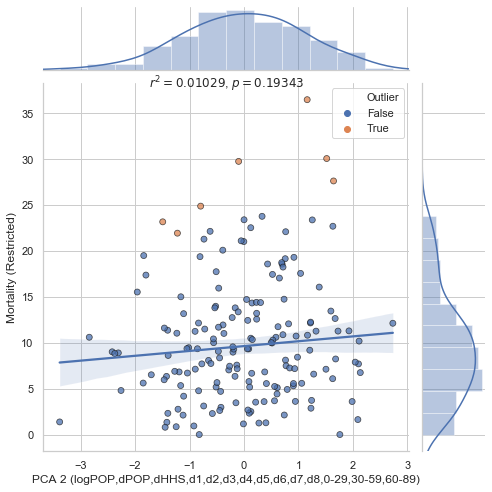

PCA3:  0.18001373780228325 0.01779098686720456


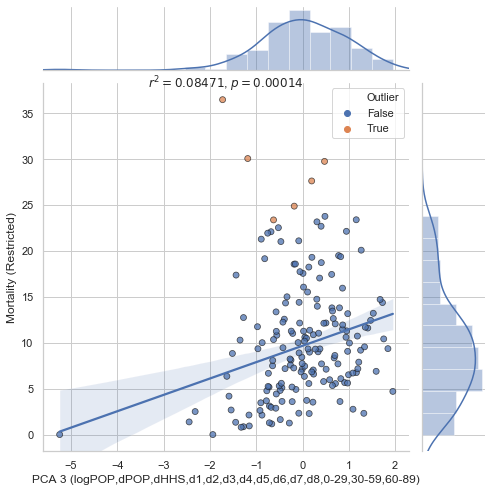

PCA4:  0.21765537096327614 0.0040195376860226095


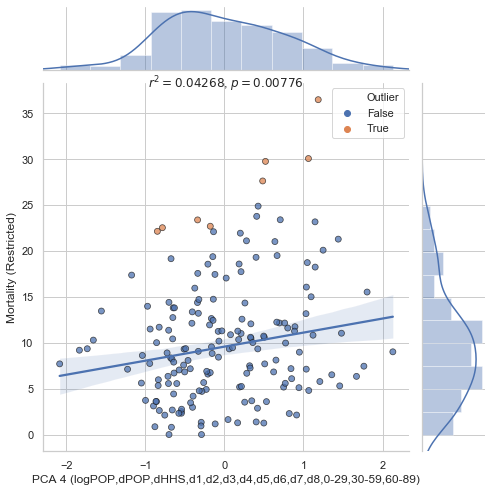

PCA5:  -0.04013261579703358 0.6001069952589198
PCA6:  0.054213393299296433 0.4786859357512913
PCA7:  0.040874171285180054 0.5933819936982906
PCA8:  0.01045949144663378 0.8913631662509719
PCA9:  0.007558332548683648 0.9213804071975171
PCA10:  -0.008218157944683183 0.9145421202458377
PCA11:  0.15846605244667225 0.03730946293981004


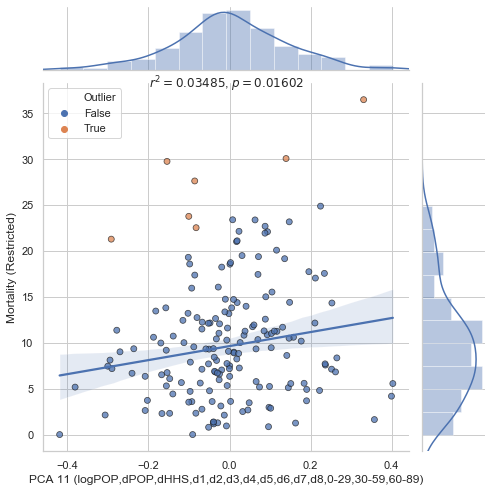

PCA12:  0.26226498136720067 0.0004907255975546068


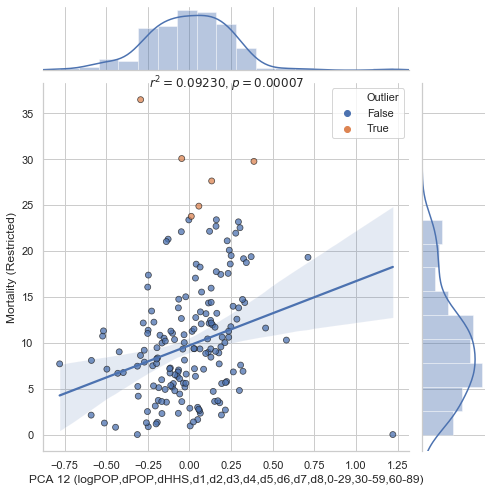

PCA13:  0.1256100445394222 0.09962106150347798


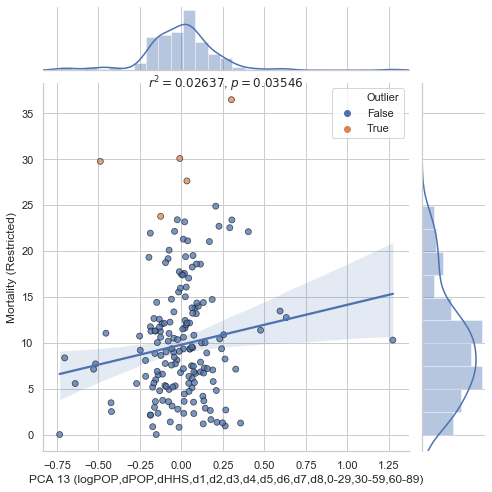

['PCA2', 'PCA3', 'PCA4', 'PCA11', 'PCA12', 'PCA13']


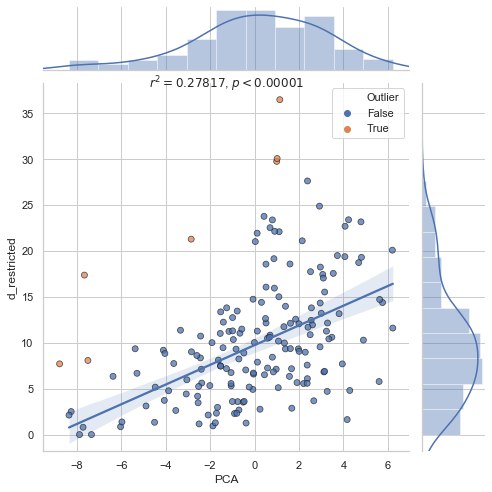

LinregressResult(slope=1.07426631585002, intercept=9.738399259550398, rvalue=0.5274207883252573, pvalue=2.8621028581651627e-13, stderr=0.13512927483786677)


logPOP    1.650497
dPOP     -0.384599
dHHS     -1.718455
d1        0.157816
d2       -3.152256
d3       -0.678329
d4        6.524566
d5       -7.416544
d6       -2.118055
d7        3.395206
d8       -0.120645
0-29      1.143616
30-59    -0.232120
60-89    -0.803007
dtype: float64

In [10]:
df = uk.loc[:,['population','dPOP','dHHS','1','2','3','4','5','6','7','8','households',"d_restricted", "0-29", "30-59", "60-89"]].copy()
df['logPOP'] = scale(df['population'].map(np.log))
df['dPOP'] = scale((df['dPOP']).map(np.log))
df['dHHS'] = scale(df['dHHS'])
df['0-29'] = scale(df['0-29'])
df['30-59'] = scale(df['30-59'])
df['60-89'] = scale(df['60-89'])
df['d1'] = scale((df['1']/df['households']).map(np.log))
df['d2'] = scale((df['2']/df['households']).map(np.log))
df['d3'] = scale((df['3']/df['households']).map(np.log))
df['d4'] = scale((df['4']/df['households']).map(np.log))
df['d5'] = scale((df['5']/df['households']).map(np.log))
df['d6'] = scale((df['6']/df['households']).map(np.log))
df['d7'] = scale((df['7']/df['households']).map(np.log))
df['d8'] = scale((df['8']/df['households']).map(np.log))

factors = ['logPOP','dPOP','dHHS','d1','d2','d3','d4','d5','d6','d7','d8',"0-29", "30-59", "60-89"]
C = df.loc[:,factors].corr().to_numpy()
e, v = linalg.eig(C)

print("Eigenvalues", e)
results = {}
results['components'] = factors
results['eigenvalues'] = e

components_restricted = []
for i in range(len(e)):
    df[f'PCA{i}'] = (df.loc[:,factors]*v[:,i]).sum(axis=1)    
    r, p = stats.pearsonr(df[f'PCA{i}'],df["d_restricted"])
    print(f"PCA{i}: ", r, p)
    if p < 0.1 or np.abs(r) > 0.1:    
        regress = corrfit(df, X=f'PCA{i}', Y="d_restricted", 
                        xlabel=f"PCA {i} ({','.join(factors)})", ylabel="Mortality (Restricted)", 
                        log=(False, False))
        results[f'PCA{i}'] = {
            'eigenvector': v[:,i],
            'fit': regress
        }
        components_restricted.append(f'PCA{i}')

print(components_restricted)
df['PCA'] = 0
weights = np.zeros_like(results['PCA2']['eigenvector'])
for pca in components_restricted:
    df['PCA'] += results[pca]['fit'].slope*df[pca]
    weights += results[pca]['fit'].slope*results[pca]['eigenvector']
r = corrfit(df,'PCA','d_restricted')
df["PCR"] = r.intercept + r.slope*df["PCA"]
print(r)
data = df.copy()
pd.Series(weights, index=results['components'])


In [11]:
components_restricted

['PCA2', 'PCA3', 'PCA4', 'PCA11', 'PCA12', 'PCA13']

In [12]:
# df = data
# df["error"] = (df["d_general"] - df["PCR"])
# df["perror"] = (df["error"]/df["PCR"]).round(3)*100
# df.loc[:,["population","PCA","PCR","d_general","error","perror"]].sort_values("perror")

In [13]:
df = data
df["error"] = (df["d_restricted"] - df["PCR"])
df["perror"] = (df["error"]/df["PCR"]).round(3)*100
df.loc[:,["population","PCA","PCR","d_restricted","error","perror"]].sort_values("perror")

population       PCA        PCR  d_restricted      error  perror
code                                                                       
W06000001     70043.0 -7.874347   1.279254      0.000000  -1.279254  -100.0
E06000053      2224.0 -7.336804   1.856717      0.000000  -1.856717  -100.0
E06000036    122549.0  4.165579  14.213340      1.632000 -12.581340   -88.5
E06000032    213052.0 -1.871575   7.727829      0.938738  -6.789091   -87.9
E06000012    159563.0 -0.381577   9.328484      1.253423  -8.075060   -86.6
...               ...       ...        ...           ...        ...     ...
E06000002    140980.0 -2.849985   6.676756     21.279614  14.602858   218.7
W06000024     60326.0  1.134748  10.957421     36.468521  25.511100   232.8
E06000027    136264.0 -7.496950   1.684679      8.072565   6.387886   379.2
W06000023    132435.0 -7.653371   1.516641     17.367010  15.850369  1045.1
E09000030    324745.0 -8.769321   0.317813      7.698348   7.380535  2322.3

[173 rows x 6 columns]

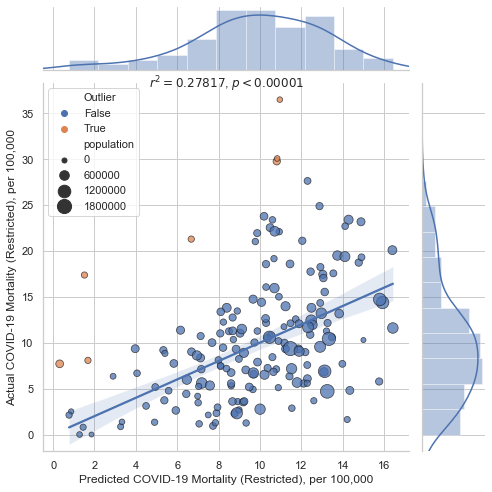

LinregressResult(slope=1.0000000000000007, intercept=-7.105427357601002e-15, rvalue=0.5274207883252577, pvalue=2.8621028581649976e-13, stderr=0.1257875005891298)

In [14]:
corrfit(df, X="PCR", Y="d_restricted",
        xlabel="Predicted COVID-19 Mortality (Restricted), per 100,000",
        ylabel="Actual COVID-19 Mortality (Restricted), per 100,000",
        log=(False,False), size="population")

In [ ]:
['PCA0','PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7','PCA8','PCA9','PCA10','PCA11','PCA12','PCA13']

In [523]:
eign = [7.22928677e+00, 3.08659118e+00, 1.23234076e+00, 8.98065955e-01, 5.93101939e-01, 3.73348974e-01, 1.87024050e-01, 1.36966261e-01,1.17514700e-01, 1.66164558e-04, 1.27750045e-02, 2.07443953e-02, 6.28805799e-02, 4.91932664e-02]

In [524]:
eign

[7.22928677,
 3.08659118,
 1.23234076,
 0.898065955,
 0.593101939,
 0.373348974,
 0.18702405,
 0.136966261,
 0.1175147,
 0.000166164558,
 0.0127750045,
 0.0207443953,
 0.0628805799,
 0.0491932664]

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

Using TensorFlow backend.


In [16]:
# X = df.loc[:,'PCA0':'PCA13']
X = df.loc[:,components_restricted]
# X = df.loc[:,['PCA0', 'PCA2', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA12']]

In [17]:
# y = df['d_general']
y = uk['d_restricted']

In [18]:
X_train = X.to_numpy()

In [19]:
X_train.shape

(173, 6)

In [20]:
# model_restricted = Sequential()
# model_restricted.add(Dense(6,activation='sigmoid'))
# model_restricted.add(Dense(3))
# model_restricted.add(Dense(1))
# model_restricted.compile(optimizer='adam',loss='mse')
# model_restricted.fit(x=X_train,y=y.values,epochs=5000)

In [444]:
# model1 = Sequential()
# model1.add(Dense(14))
# model1.add(Dense(7))
# model1.add(Dense(1))
# model1.compile(optimizer='adam',loss='mse')
# model1.fit(x=X_train,y=y.values,epochs=1000)

In [91]:
model = Sequential()
model.add(Dense(6,activation='sigmoid',kernel_regularizer=regularizers.l2(l=0.1)))
model.add(Dense(3,kernel_regularizer=regularizers.l2(l=0.1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
model.fit(x=X_train,y=y.values,epochs=40000)

Epoch 1/40000
173/173 [==============================] - 0s 547us/step - loss: 161.0697
Epoch 2/40000
173/173 [==============================] - 0s 46us/step - loss: 160.0974
Epoch 3/40000
173/173 [==============================] - 0s 52us/step - loss: 159.1239
Epoch 4/40000
173/173 [==============================] - 0s 52us/step - loss: 158.2034
Epoch 5/40000
173/173 [==============================] - 0s 63us/step - loss: 157.3236
Epoch 6/40000
173/173 [==============================] - 0s 69us/step - loss: 156.4402
Epoch 7/40000
173/173 [==============================] - 0s 69us/step - loss: 155.6042
Epoch 8/40000
173/173 [==============================] - 0s 52us/step - loss: 154.7828
Epoch 9/40000
173/173 [==============================] - 0s 46us/step - loss: 154.0075
Epoch 10/40000
173/173 [==============================] - 0s 63us/step - loss: 153.2212
Epoch 11/40000
173/173 [==============================] - 0s 46us/step - loss: 152.4648
Epoch 12/40000
173/173 [================

173/173 [==============================] - 0s 58us/step - loss: 40.5417
Epoch 187/40000
173/173 [==============================] - 0s 52us/step - loss: 40.5495
Epoch 188/40000
173/173 [==============================] - 0s 69us/step - loss: 40.5323
Epoch 189/40000
173/173 [==============================] - 0s 52us/step - loss: 40.5247
Epoch 190/40000
173/173 [==============================] - 0s 58us/step - loss: 40.5215
Epoch 191/40000
173/173 [==============================] - 0s 58us/step - loss: 40.5116
Epoch 192/40000
173/173 [==============================] - 0s 52us/step - loss: 40.5030
Epoch 193/40000
173/173 [==============================] - 0s 63us/step - loss: 40.5012
Epoch 194/40000
173/173 [==============================] - 0s 63us/step - loss: 40.4921
Epoch 195/40000
173/173 [==============================] - 0s 58us/step - loss: 40.4994
Epoch 196/40000
173/173 [==============================] - 0s 63us/step - loss: 40.4881
Epoch 197/40000
173/173 [=======================

173/173 [==============================] - 0s 58us/step - loss: 39.8795
Epoch 373/40000
173/173 [==============================] - 0s 52us/step - loss: 39.8772
Epoch 374/40000
173/173 [==============================] - 0s 58us/step - loss: 39.8771
Epoch 375/40000
173/173 [==============================] - 0s 52us/step - loss: 39.8702
Epoch 376/40000
173/173 [==============================] - 0s 52us/step - loss: 39.8727
Epoch 377/40000
173/173 [==============================] - 0s 46us/step - loss: 39.8649
Epoch 378/40000
173/173 [==============================] - 0s 63us/step - loss: 39.8650
Epoch 379/40000
173/173 [==============================] - 0s 69us/step - loss: 39.8637
Epoch 380/40000
173/173 [==============================] - 0s 58us/step - loss: 39.8730
Epoch 381/40000
173/173 [==============================] - 0s 46us/step - loss: 39.8561
Epoch 382/40000
173/173 [==============================] - 0s 52us/step - loss: 39.8556
Epoch 383/40000
173/173 [=======================

173/173 [==============================] - 0s 69us/step - loss: 39.4808
Epoch 559/40000
173/173 [==============================] - 0s 69us/step - loss: 39.5046
Epoch 560/40000
173/173 [==============================] - 0s 63us/step - loss: 39.4764
Epoch 561/40000
173/173 [==============================] - 0s 58us/step - loss: 39.4764
Epoch 562/40000
173/173 [==============================] - 0s 63us/step - loss: 39.4712
Epoch 563/40000
173/173 [==============================] - 0s 52us/step - loss: 39.4715
Epoch 564/40000
173/173 [==============================] - 0s 63us/step - loss: 39.4746
Epoch 565/40000
173/173 [==============================] - 0s 86us/step - loss: 39.4728
Epoch 566/40000
173/173 [==============================] - 0s 63us/step - loss: 39.4628
Epoch 567/40000
173/173 [==============================] - 0s 75us/step - loss: 39.4648
Epoch 568/40000
173/173 [==============================] - 0s 58us/step - loss: 39.4749
Epoch 569/40000
173/173 [=======================

173/173 [==============================] - 0s 52us/step - loss: 39.1673
Epoch 745/40000
173/173 [==============================] - 0s 52us/step - loss: 39.1627
Epoch 746/40000
173/173 [==============================] - 0s 52us/step - loss: 39.1741
Epoch 747/40000
173/173 [==============================] - 0s 58us/step - loss: 39.1631
Epoch 748/40000
173/173 [==============================] - 0s 52us/step - loss: 39.1539
Epoch 749/40000
173/173 [==============================] - 0s 58us/step - loss: 39.1539
Epoch 750/40000
173/173 [==============================] - 0s 58us/step - loss: 39.1469
Epoch 751/40000
173/173 [==============================] - 0s 58us/step - loss: 39.1487
Epoch 752/40000
173/173 [==============================] - 0s 58us/step - loss: 39.1461
Epoch 753/40000
173/173 [==============================] - 0s 52us/step - loss: 39.1377
Epoch 754/40000
173/173 [==============================] - 0s 63us/step - loss: 39.1336
Epoch 755/40000
173/173 [=======================

Epoch 837/40000
173/173 [==============================] - 0s 52us/step - loss: 39.0085
Epoch 838/40000
173/173 [==============================] - 0s 63us/step - loss: 39.0192
Epoch 839/40000
173/173 [==============================] - 0s 58us/step - loss: 39.0075
Epoch 840/40000
173/173 [==============================] - 0s 58us/step - loss: 38.9976
Epoch 841/40000
173/173 [==============================] - 0s 63us/step - loss: 39.0085
Epoch 842/40000
173/173 [==============================] - 0s 58us/step - loss: 38.9917
Epoch 843/40000
173/173 [==============================] - 0s 58us/step - loss: 38.9968
Epoch 844/40000
173/173 [==============================] - 0s 75us/step - loss: 38.9949
Epoch 845/40000
173/173 [==============================] - 0s 86us/step - loss: 38.9926
Epoch 846/40000
173/173 [==============================] - 0s 58us/step - loss: 38.9869
Epoch 847/40000
173/173 [==============================] - 0s 52us/step - loss: 38.9888
Epoch 848/40000
173/173 [=======

173/173 [==============================] - 0s 58us/step - loss: 38.8864
Epoch 931/40000
173/173 [==============================] - 0s 52us/step - loss: 38.8780
Epoch 932/40000
173/173 [==============================] - 0s 58us/step - loss: 38.8918
Epoch 933/40000
173/173 [==============================] - 0s 52us/step - loss: 38.8784
Epoch 934/40000
173/173 [==============================] - 0s 52us/step - loss: 38.8825
Epoch 935/40000
173/173 [==============================] - 0s 52us/step - loss: 38.8759
Epoch 936/40000
173/173 [==============================] - 0s 63us/step - loss: 38.8694
Epoch 937/40000
173/173 [==============================] - 0s 63us/step - loss: 38.8733
Epoch 938/40000
173/173 [==============================] - 0s 58us/step - loss: 38.8971
Epoch 939/40000
173/173 [==============================] - 0s 69us/step - loss: 38.8647
Epoch 940/40000
173/173 [==============================] - 0s 52us/step - loss: 38.8621
Epoch 941/40000
173/173 [=======================

Epoch 1114/40000
173/173 [==============================] - 0s 52us/step - loss: 38.6611
Epoch 1115/40000
173/173 [==============================] - 0s 46us/step - loss: 38.6565
Epoch 1116/40000
173/173 [==============================] - 0s 63us/step - loss: 38.6573
Epoch 1117/40000
173/173 [==============================] - 0s 58us/step - loss: 38.6606
Epoch 1118/40000
173/173 [==============================] - 0s 58us/step - loss: 38.6577
Epoch 1119/40000
173/173 [==============================] - 0s 52us/step - loss: 38.6557
Epoch 1120/40000
173/173 [==============================] - 0s 52us/step - loss: 38.6581
Epoch 1121/40000
173/173 [==============================] - 0s 63us/step - loss: 38.6681
Epoch 1122/40000
173/173 [==============================] - 0s 52us/step - loss: 38.6510
Epoch 1123/40000
173/173 [==============================] - 0s 63us/step - loss: 38.6556
Epoch 1124/40000
173/173 [==============================] - 0s 46us/step - loss: 38.6711
Epoch 1125/40000
173/

173/173 [==============================] - 0s 46us/step - loss: 38.5621
Epoch 1207/40000
173/173 [==============================] - 0s 46us/step - loss: 38.5707
Epoch 1208/40000
173/173 [==============================] - 0s 46us/step - loss: 38.5736
Epoch 1209/40000
173/173 [==============================] - 0s 63us/step - loss: 38.5719
Epoch 1210/40000
173/173 [==============================] - 0s 58us/step - loss: 38.5649
Epoch 1211/40000
173/173 [==============================] - 0s 52us/step - loss: 38.5595
Epoch 1212/40000
173/173 [==============================] - 0s 58us/step - loss: 38.5689
Epoch 1213/40000
173/173 [==============================] - 0s 52us/step - loss: 38.5689
Epoch 1214/40000
173/173 [==============================] - 0s 58us/step - loss: 38.5650
Epoch 1215/40000
173/173 [==============================] - 0s 46us/step - loss: 38.5607
Epoch 1216/40000
173/173 [==============================] - 0s 46us/step - loss: 38.5634
Epoch 1217/40000
173/173 [============

Epoch 1298/40000
173/173 [==============================] - 0s 63us/step - loss: 38.4823
Epoch 1299/40000
173/173 [==============================] - 0s 46us/step - loss: 38.4954
Epoch 1300/40000
173/173 [==============================] - 0s 46us/step - loss: 38.5211
Epoch 1301/40000
173/173 [==============================] - 0s 52us/step - loss: 38.4839
Epoch 1302/40000
173/173 [==============================] - 0s 52us/step - loss: 38.4882
Epoch 1303/40000
173/173 [==============================] - 0s 58us/step - loss: 38.4803
Epoch 1304/40000
173/173 [==============================] - 0s 52us/step - loss: 38.4784
Epoch 1305/40000
173/173 [==============================] - 0s 58us/step - loss: 38.4834
Epoch 1306/40000
173/173 [==============================] - 0s 46us/step - loss: 38.4824
Epoch 1307/40000
173/173 [==============================] - 0s 58us/step - loss: 38.4759
Epoch 1308/40000
173/173 [==============================] - 0s 58us/step - loss: 38.4829
Epoch 1309/40000
173/

173/173 [==============================] - 0s 75us/step - loss: 38.4194
Epoch 1391/40000
173/173 [==============================] - 0s 63us/step - loss: 38.4104
Epoch 1392/40000
173/173 [==============================] - 0s 58us/step - loss: 38.4112
Epoch 1393/40000
173/173 [==============================] - 0s 58us/step - loss: 38.4121
Epoch 1394/40000
173/173 [==============================] - 0s 52us/step - loss: 38.4082
Epoch 1395/40000
173/173 [==============================] - 0s 52us/step - loss: 38.4231
Epoch 1396/40000
173/173 [==============================] - 0s 46us/step - loss: 38.4092
Epoch 1397/40000
173/173 [==============================] - 0s 58us/step - loss: 38.4075
Epoch 1398/40000
173/173 [==============================] - 0s 46us/step - loss: 38.4026
Epoch 1399/40000
173/173 [==============================] - 0s 52us/step - loss: 38.4045
Epoch 1400/40000
173/173 [==============================] - 0s 52us/step - loss: 38.4071
Epoch 1401/40000
173/173 [============

Epoch 1482/40000
173/173 [==============================] - 0s 46us/step - loss: 38.3470
Epoch 1483/40000
173/173 [==============================] - 0s 46us/step - loss: 38.3446
Epoch 1484/40000
173/173 [==============================] - 0s 58us/step - loss: 38.3431
Epoch 1485/40000
173/173 [==============================] - 0s 52us/step - loss: 38.3453
Epoch 1486/40000
173/173 [==============================] - 0s 58us/step - loss: 38.3411
Epoch 1487/40000
173/173 [==============================] - 0s 52us/step - loss: 38.3437
Epoch 1488/40000
173/173 [==============================] - 0s 58us/step - loss: 38.3489
Epoch 1489/40000
173/173 [==============================] - 0s 52us/step - loss: 38.3500
Epoch 1490/40000
173/173 [==============================] - 0s 52us/step - loss: 38.3391
Epoch 1491/40000
173/173 [==============================] - 0s 58us/step - loss: 38.3383
Epoch 1492/40000
173/173 [==============================] - 0s 52us/step - loss: 38.3387
Epoch 1493/40000
173/

173/173 [==============================] - 0s 52us/step - loss: 38.2795
Epoch 1575/40000
173/173 [==============================] - 0s 58us/step - loss: 38.2884
Epoch 1576/40000
173/173 [==============================] - 0s 52us/step - loss: 38.2832
Epoch 1577/40000
173/173 [==============================] - 0s 46us/step - loss: 38.2905
Epoch 1578/40000
173/173 [==============================] - 0s 52us/step - loss: 38.2832
Epoch 1579/40000
173/173 [==============================] - 0s 58us/step - loss: 38.2884
Epoch 1580/40000
173/173 [==============================] - 0s 52us/step - loss: 38.2885
Epoch 1581/40000
173/173 [==============================] - 0s 52us/step - loss: 38.2744
Epoch 1582/40000
173/173 [==============================] - 0s 63us/step - loss: 38.2724
Epoch 1583/40000
173/173 [==============================] - 0s 52us/step - loss: 38.2748
Epoch 1584/40000
173/173 [==============================] - 0s 46us/step - loss: 38.2695
Epoch 1585/40000
173/173 [============

Epoch 1758/40000
173/173 [==============================] - 0s 58us/step - loss: 38.1726
Epoch 1759/40000
173/173 [==============================] - 0s 46us/step - loss: 38.1613
Epoch 1760/40000
173/173 [==============================] - 0s 52us/step - loss: 38.1731
Epoch 1761/40000
173/173 [==============================] - 0s 58us/step - loss: 38.1691
Epoch 1762/40000
173/173 [==============================] - 0s 52us/step - loss: 38.1636
Epoch 1763/40000
173/173 [==============================] - 0s 46us/step - loss: 38.1561
Epoch 1764/40000
173/173 [==============================] - 0s 58us/step - loss: 38.1615
Epoch 1765/40000
173/173 [==============================] - 0s 63us/step - loss: 38.1545
Epoch 1766/40000
173/173 [==============================] - 0s 52us/step - loss: 38.1634
Epoch 1767/40000
173/173 [==============================] - 0s 63us/step - loss: 38.1829
Epoch 1768/40000
173/173 [==============================] - 0s 63us/step - loss: 38.1531
Epoch 1769/40000
173/

173/173 [==============================] - 0s 75us/step - loss: 38.1079
Epoch 1851/40000
173/173 [==============================] - 0s 58us/step - loss: 38.1076
Epoch 1852/40000
173/173 [==============================] - 0s 63us/step - loss: 38.1040
Epoch 1853/40000
173/173 [==============================] - 0s 52us/step - loss: 38.1005
Epoch 1854/40000
173/173 [==============================] - 0s 63us/step - loss: 38.1118
Epoch 1855/40000
173/173 [==============================] - 0s 52us/step - loss: 38.1109
Epoch 1856/40000
173/173 [==============================] - 0s 58us/step - loss: 38.1081
Epoch 1857/40000
173/173 [==============================] - 0s 63us/step - loss: 38.1018
Epoch 1858/40000
173/173 [==============================] - 0s 52us/step - loss: 38.1162
Epoch 1859/40000
173/173 [==============================] - 0s 58us/step - loss: 38.1362
Epoch 1860/40000
173/173 [==============================] - 0s 52us/step - loss: 38.1128
Epoch 1861/40000
173/173 [============

Epoch 1942/40000
173/173 [==============================] - 0s 58us/step - loss: 38.0554
Epoch 1943/40000
173/173 [==============================] - 0s 63us/step - loss: 38.0512
Epoch 1944/40000
173/173 [==============================] - 0s 58us/step - loss: 38.0539
Epoch 1945/40000
173/173 [==============================] - 0s 52us/step - loss: 38.0484
Epoch 1946/40000
173/173 [==============================] - 0s 46us/step - loss: 38.0526
Epoch 1947/40000
173/173 [==============================] - 0s 69us/step - loss: 38.0529
Epoch 1948/40000
173/173 [==============================] - 0s 52us/step - loss: 38.0527
Epoch 1949/40000
173/173 [==============================] - 0s 52us/step - loss: 38.0688
Epoch 1950/40000
173/173 [==============================] - 0s 58us/step - loss: 38.0538
Epoch 1951/40000
173/173 [==============================] - 0s 52us/step - loss: 38.0570
Epoch 1952/40000
173/173 [==============================] - 0s 58us/step - loss: 38.0469
Epoch 1953/40000
173/

173/173 [==============================] - 0s 52us/step - loss: 38.0046
Epoch 2035/40000
173/173 [==============================] - 0s 58us/step - loss: 38.0185
Epoch 2036/40000
173/173 [==============================] - 0s 58us/step - loss: 38.0075
Epoch 2037/40000
173/173 [==============================] - 0s 58us/step - loss: 38.0023
Epoch 2038/40000
173/173 [==============================] - 0s 63us/step - loss: 38.0026
Epoch 2039/40000
173/173 [==============================] - 0s 69us/step - loss: 38.0107
Epoch 2040/40000
173/173 [==============================] - 0s 63us/step - loss: 38.0015
Epoch 2041/40000
173/173 [==============================] - 0s 52us/step - loss: 38.0039
Epoch 2042/40000
173/173 [==============================] - 0s 58us/step - loss: 38.0042
Epoch 2043/40000
173/173 [==============================] - 0s 46us/step - loss: 38.0048
Epoch 2044/40000
173/173 [==============================] - 0s 46us/step - loss: 38.0126
Epoch 2045/40000
173/173 [============

173/173 [==============================] - 0s 46us/step - loss: 37.9233
Epoch 2219/40000
173/173 [==============================] - 0s 52us/step - loss: 37.9224
Epoch 2220/40000
173/173 [==============================] - 0s 58us/step - loss: 37.9147
Epoch 2221/40000
173/173 [==============================] - 0s 46us/step - loss: 37.9204
Epoch 2222/40000
173/173 [==============================] - 0s 58us/step - loss: 37.9222
Epoch 2223/40000
173/173 [==============================] - 0s 58us/step - loss: 37.9115
Epoch 2224/40000
173/173 [==============================] - 0s 52us/step - loss: 37.9130
Epoch 2225/40000
173/173 [==============================] - 0s 52us/step - loss: 37.9161
Epoch 2226/40000
173/173 [==============================] - 0s 58us/step - loss: 37.9105
Epoch 2227/40000
173/173 [==============================] - 0s 63us/step - loss: 37.9102
Epoch 2228/40000
173/173 [==============================] - 0s 46us/step - loss: 37.9067
Epoch 2229/40000
173/173 [============

Epoch 2310/40000
173/173 [==============================] - 0s 63us/step - loss: 37.8749
Epoch 2311/40000
173/173 [==============================] - 0s 63us/step - loss: 37.8867
Epoch 2312/40000
173/173 [==============================] - 0s 52us/step - loss: 37.8661
Epoch 2313/40000
173/173 [==============================] - 0s 63us/step - loss: 37.8702
Epoch 2314/40000
173/173 [==============================] - 0s 58us/step - loss: 37.8677
Epoch 2315/40000
173/173 [==============================] - 0s 58us/step - loss: 37.8649
Epoch 2316/40000
173/173 [==============================] - 0s 52us/step - loss: 37.8657
Epoch 2317/40000
173/173 [==============================] - 0s 69us/step - loss: 37.8621
Epoch 2318/40000
173/173 [==============================] - 0s 58us/step - loss: 37.8709
Epoch 2319/40000
173/173 [==============================] - 0s 46us/step - loss: 37.8682
Epoch 2320/40000
173/173 [==============================] - 0s 69us/step - loss: 37.8616
Epoch 2321/40000
173/

Epoch 2493/40000
173/173 [==============================] - 0s 58us/step - loss: 37.7836
Epoch 2494/40000
173/173 [==============================] - 0s 46us/step - loss: 37.7853
Epoch 2495/40000
173/173 [==============================] - 0s 52us/step - loss: 37.7860
Epoch 2496/40000
173/173 [==============================] - 0s 52us/step - loss: 37.7884
Epoch 2497/40000
173/173 [==============================] - 0s 46us/step - loss: 37.7790
Epoch 2498/40000
173/173 [==============================] - 0s 46us/step - loss: 37.7844
Epoch 2499/40000
173/173 [==============================] - 0s 69us/step - loss: 37.8054
Epoch 2500/40000
173/173 [==============================] - 0s 69us/step - loss: 37.8133
Epoch 2501/40000
173/173 [==============================] - 0s 58us/step - loss: 37.8149
Epoch 2502/40000
173/173 [==============================] - 0s 58us/step - loss: 37.8000
Epoch 2503/40000
173/173 [==============================] - 0s 58us/step - loss: 37.7941
Epoch 2504/40000
173/

173/173 [==============================] - 0s 58us/step - loss: 37.7595
Epoch 2586/40000
173/173 [==============================] - 0s 75us/step - loss: 37.7549
Epoch 2587/40000
173/173 [==============================] - 0s 63us/step - loss: 37.7460
Epoch 2588/40000
173/173 [==============================] - 0s 63us/step - loss: 37.7459
Epoch 2589/40000
173/173 [==============================] - 0s 58us/step - loss: 37.7564
Epoch 2590/40000
173/173 [==============================] - 0s 63us/step - loss: 37.7482
Epoch 2591/40000
173/173 [==============================] - 0s 52us/step - loss: 37.7571
Epoch 2592/40000
173/173 [==============================] - 0s 63us/step - loss: 37.7402
Epoch 2593/40000
173/173 [==============================] - 0s 46us/step - loss: 37.7461
Epoch 2594/40000
173/173 [==============================] - 0s 58us/step - loss: 37.7313
Epoch 2595/40000
173/173 [==============================] - 0s 58us/step - loss: 37.7433
Epoch 2596/40000
173/173 [============

173/173 [==============================] - 0s 52us/step - loss: 37.6767
Epoch 2770/40000
173/173 [==============================] - 0s 58us/step - loss: 37.6841
Epoch 2771/40000
173/173 [==============================] - 0s 52us/step - loss: 37.6833
Epoch 2772/40000
173/173 [==============================] - 0s 58us/step - loss: 37.6764
Epoch 2773/40000
173/173 [==============================] - 0s 46us/step - loss: 37.6790
Epoch 2774/40000
173/173 [==============================] - 0s 58us/step - loss: 37.6819
Epoch 2775/40000
173/173 [==============================] - 0s 63us/step - loss: 37.6710
Epoch 2776/40000
173/173 [==============================] - 0s 52us/step - loss: 37.6692
Epoch 2777/40000
173/173 [==============================] - 0s 52us/step - loss: 37.6623
Epoch 2778/40000
173/173 [==============================] - 0s 46us/step - loss: 37.6777
Epoch 2779/40000
173/173 [==============================] - 0s 46us/step - loss: 37.6548
Epoch 2780/40000
173/173 [============

173/173 [==============================] - 0s 69us/step - loss: 37.5872
Epoch 2954/40000
173/173 [==============================] - 0s 46us/step - loss: 37.5777
Epoch 2955/40000
173/173 [==============================] - 0s 46us/step - loss: 37.5886
Epoch 2956/40000
173/173 [==============================] - 0s 58us/step - loss: 37.6003
Epoch 2957/40000
173/173 [==============================] - 0s 52us/step - loss: 37.5990
Epoch 2958/40000
173/173 [==============================] - 0s 46us/step - loss: 37.5894
Epoch 2959/40000
173/173 [==============================] - 0s 52us/step - loss: 37.5808
Epoch 2960/40000
173/173 [==============================] - 0s 63us/step - loss: 37.5810
Epoch 2961/40000
173/173 [==============================] - 0s 46us/step - loss: 37.5777
Epoch 2962/40000
173/173 [==============================] - 0s 58us/step - loss: 37.5969
Epoch 2963/40000
173/173 [==============================] - 0s 58us/step - loss: 37.5747
Epoch 2964/40000
173/173 [============

Epoch 3045/40000
173/173 [==============================] - 0s 52us/step - loss: 37.5275
Epoch 3046/40000
173/173 [==============================] - 0s 63us/step - loss: 37.5273
Epoch 3047/40000
173/173 [==============================] - 0s 52us/step - loss: 37.5574
Epoch 3048/40000
173/173 [==============================] - 0s 63us/step - loss: 37.5423
Epoch 3049/40000
173/173 [==============================] - 0s 58us/step - loss: 37.5349
Epoch 3050/40000
173/173 [==============================] - 0s 52us/step - loss: 37.5430
Epoch 3051/40000
173/173 [==============================] - 0s 58us/step - loss: 37.5324
Epoch 3052/40000
173/173 [==============================] - 0s 52us/step - loss: 37.5357
Epoch 3053/40000
173/173 [==============================] - 0s 58us/step - loss: 37.5316
Epoch 3054/40000
173/173 [==============================] - 0s 52us/step - loss: 37.5256
Epoch 3055/40000
173/173 [==============================] - 0s 63us/step - loss: 37.5370
Epoch 3056/40000
173/

173/173 [==============================] - 0s 52us/step - loss: 37.4585
Epoch 3229/40000
173/173 [==============================] - 0s 58us/step - loss: 37.4538
Epoch 3230/40000
173/173 [==============================] - 0s 52us/step - loss: 37.4603
Epoch 3231/40000
173/173 [==============================] - 0s 52us/step - loss: 37.4621
Epoch 3232/40000
173/173 [==============================] - 0s 52us/step - loss: 37.4560
Epoch 3233/40000
173/173 [==============================] - 0s 52us/step - loss: 37.4440
Epoch 3234/40000
173/173 [==============================] - 0s 46us/step - loss: 37.4471
Epoch 3235/40000
173/173 [==============================] - ETA: 0s - loss: 37.89 - 0s 58us/step - loss: 37.4410
Epoch 3236/40000
173/173 [==============================] - 0s 52us/step - loss: 37.4488
Epoch 3237/40000
173/173 [==============================] - 0s 46us/step - loss: 37.4426
Epoch 3238/40000
173/173 [==============================] - 0s 52us/step - loss: 37.4488
Epoch 3239/400

Epoch 3320/40000
173/173 [==============================] - 0s 58us/step - loss: 37.4099
Epoch 3321/40000
173/173 [==============================] - 0s 52us/step - loss: 37.4094
Epoch 3322/40000
173/173 [==============================] - 0s 63us/step - loss: 37.4147
Epoch 3323/40000
173/173 [==============================] - 0s 58us/step - loss: 37.4042
Epoch 3324/40000
173/173 [==============================] - 0s 52us/step - loss: 37.4065
Epoch 3325/40000
173/173 [==============================] - 0s 52us/step - loss: 37.4048
Epoch 3326/40000
173/173 [==============================] - 0s 46us/step - loss: 37.3947
Epoch 3327/40000
173/173 [==============================] - 0s 58us/step - loss: 37.4056
Epoch 3328/40000
173/173 [==============================] - 0s 52us/step - loss: 37.3953
Epoch 3329/40000
173/173 [==============================] - ETA: 0s - loss: 48.76 - 0s 63us/step - loss: 37.3941
Epoch 3330/40000
173/173 [==============================] - 0s 58us/step - loss: 37.39

173/173 [==============================] - 0s 63us/step - loss: 37.3126
Epoch 3504/40000
173/173 [==============================] - 0s 52us/step - loss: 37.3348
Epoch 3505/40000
173/173 [==============================] - 0s 52us/step - loss: 37.2908
Epoch 3506/40000
173/173 [==============================] - 0s 58us/step - loss: 37.2913
Epoch 3507/40000
173/173 [==============================] - 0s 52us/step - loss: 37.2954
Epoch 3508/40000
173/173 [==============================] - 0s 52us/step - loss: 37.3140
Epoch 3509/40000
173/173 [==============================] - 0s 58us/step - loss: 37.2892
Epoch 3510/40000
173/173 [==============================] - 0s 58us/step - loss: 37.2908
Epoch 3511/40000
173/173 [==============================] - 0s 52us/step - loss: 37.2939
Epoch 3512/40000
173/173 [==============================] - 0s 58us/step - loss: 37.2939
Epoch 3513/40000
173/173 [==============================] - 0s 63us/step - loss: 37.2937
Epoch 3514/40000
173/173 [============

173/173 [==============================] - 0s 58us/step - loss: 37.1916
Epoch 3688/40000
173/173 [==============================] - 0s 52us/step - loss: 37.1792
Epoch 3689/40000
173/173 [==============================] - 0s 63us/step - loss: 37.2002
Epoch 3690/40000
173/173 [==============================] - 0s 52us/step - loss: 37.1771
Epoch 3691/40000
173/173 [==============================] - 0s 46us/step - loss: 37.1820
Epoch 3692/40000
173/173 [==============================] - 0s 52us/step - loss: 37.1763
Epoch 3693/40000
173/173 [==============================] - 0s 63us/step - loss: 37.1671
Epoch 3694/40000
173/173 [==============================] - 0s 52us/step - loss: 37.1773
Epoch 3695/40000
173/173 [==============================] - 0s 58us/step - loss: 37.1869
Epoch 3696/40000
173/173 [==============================] - 0s 58us/step - loss: 37.1653
Epoch 3697/40000
173/173 [==============================] - 0s 52us/step - loss: 37.1738
Epoch 3698/40000
173/173 [============

173/173 [==============================] - 0s 46us/step - loss: 37.0392
Epoch 3872/40000
173/173 [==============================] - 0s 58us/step - loss: 37.0325
Epoch 3873/40000
173/173 [==============================] - 0s 46us/step - loss: 37.0427
Epoch 3874/40000
173/173 [==============================] - 0s 46us/step - loss: 37.0157
Epoch 3875/40000
173/173 [==============================] - 0s 52us/step - loss: 37.0407
Epoch 3876/40000
173/173 [==============================] - 0s 46us/step - loss: 37.0079
Epoch 3877/40000
173/173 [==============================] - 0s 52us/step - loss: 37.0173
Epoch 3878/40000
173/173 [==============================] - 0s 46us/step - loss: 37.0468
Epoch 3879/40000
173/173 [==============================] - 0s 58us/step - loss: 37.0276
Epoch 3880/40000
173/173 [==============================] - 0s 46us/step - loss: 37.0110
Epoch 3881/40000
173/173 [==============================] - 0s 58us/step - loss: 37.0128
Epoch 3882/40000
173/173 [============

Epoch 4055/40000
173/173 [==============================] - 0s 52us/step - loss: 36.8490
Epoch 4056/40000
173/173 [==============================] - 0s 52us/step - loss: 36.8442
Epoch 4057/40000
173/173 [==============================] - 0s 52us/step - loss: 36.8421
Epoch 4058/40000
173/173 [==============================] - 0s 52us/step - loss: 36.8407
Epoch 4059/40000
173/173 [==============================] - 0s 58us/step - loss: 36.8365
Epoch 4060/40000
173/173 [==============================] - 0s 52us/step - loss: 36.8318
Epoch 4061/40000
173/173 [==============================] - 0s 52us/step - loss: 36.8754
Epoch 4062/40000
173/173 [==============================] - 0s 58us/step - loss: 36.8397
Epoch 4063/40000
173/173 [==============================] - 0s 58us/step - loss: 36.8345
Epoch 4064/40000
173/173 [==============================] - 0s 63us/step - loss: 36.8422
Epoch 4065/40000
173/173 [==============================] - 0s 138us/step - loss: 36.8301
Epoch 4066/40000
173

173/173 [==============================] - 0s 52us/step - loss: 36.6491
Epoch 4239/40000
173/173 [==============================] - 0s 46us/step - loss: 36.6454
Epoch 4240/40000
173/173 [==============================] - 0s 52us/step - loss: 36.6851
Epoch 4241/40000
173/173 [==============================] - 0s 52us/step - loss: 36.6365
Epoch 4242/40000
173/173 [==============================] - 0s 52us/step - loss: 36.6421
Epoch 4243/40000
173/173 [==============================] - 0s 46us/step - loss: 36.6414
Epoch 4244/40000
173/173 [==============================] - 0s 46us/step - loss: 36.6505
Epoch 4245/40000
173/173 [==============================] - 0s 63us/step - loss: 36.6421
Epoch 4246/40000
173/173 [==============================] - 0s 52us/step - loss: 36.6442
Epoch 4247/40000
173/173 [==============================] - 0s 52us/step - loss: 36.6315
Epoch 4248/40000
173/173 [==============================] - 0s 52us/step - loss: 36.6257
Epoch 4249/40000
173/173 [============

Epoch 4330/40000
173/173 [==============================] - 0s 52us/step - loss: 36.5424
Epoch 4331/40000
173/173 [==============================] - 0s 52us/step - loss: 36.5223
Epoch 4332/40000
173/173 [==============================] - 0s 63us/step - loss: 36.5461
Epoch 4333/40000
173/173 [==============================] - 0s 52us/step - loss: 36.5438
Epoch 4334/40000
173/173 [==============================] - 0s 52us/step - loss: 36.5214
Epoch 4335/40000
173/173 [==============================] - 0s 63us/step - loss: 36.5356
Epoch 4336/40000
173/173 [==============================] - 0s 46us/step - loss: 36.5123
Epoch 4337/40000
173/173 [==============================] - 0s 52us/step - loss: 36.5225
Epoch 4338/40000
173/173 [==============================] - 0s 45us/step - loss: 36.5366
Epoch 4339/40000
173/173 [==============================] - 0s 58us/step - loss: 36.5197
Epoch 4340/40000
173/173 [==============================] - 0s 58us/step - loss: 36.5288
Epoch 4341/40000
173/

173/173 [==============================] - 0s 58us/step - loss: 36.3093
Epoch 4514/40000
173/173 [==============================] - 0s 58us/step - loss: 36.2888
Epoch 4515/40000
173/173 [==============================] - 0s 52us/step - loss: 36.2946
Epoch 4516/40000
173/173 [==============================] - 0s 52us/step - loss: 36.2885
Epoch 4517/40000
173/173 [==============================] - 0s 52us/step - loss: 36.2948
Epoch 4518/40000
173/173 [==============================] - 0s 52us/step - loss: 36.2965
Epoch 4519/40000
173/173 [==============================] - 0s 52us/step - loss: 36.3069
Epoch 4520/40000
173/173 [==============================] - 0s 46us/step - loss: 36.2873
Epoch 4521/40000
173/173 [==============================] - 0s 63us/step - loss: 36.3055
Epoch 4522/40000
173/173 [==============================] - 0s 58us/step - loss: 36.2823
Epoch 4523/40000
173/173 [==============================] - 0s 46us/step - loss: 36.2916
Epoch 4524/40000
173/173 [============

Epoch 4605/40000
173/173 [==============================] - 0s 52us/step - loss: 36.1882
Epoch 4606/40000
173/173 [==============================] - 0s 69us/step - loss: 36.1766
Epoch 4607/40000
173/173 [==============================] - ETA: 0s - loss: 27.06 - 0s 69us/step - loss: 36.1807
Epoch 4608/40000
173/173 [==============================] - 0s 58us/step - loss: 36.1678
Epoch 4609/40000
173/173 [==============================] - 0s 58us/step - loss: 36.1627
Epoch 4610/40000
173/173 [==============================] - 0s 58us/step - loss: 36.1713
Epoch 4611/40000
173/173 [==============================] - 0s 52us/step - loss: 36.1572
Epoch 4612/40000
173/173 [==============================] - 0s 52us/step - loss: 36.1724
Epoch 4613/40000
173/173 [==============================] - 0s 63us/step - loss: 36.1499
Epoch 4614/40000
173/173 [==============================] - 0s 52us/step - loss: 36.1734
Epoch 4615/40000
173/173 [==============================] - ETA: 0s - loss: 22.12 - 0s

173/173 [==============================] - 0s 52us/step - loss: 35.9698
Epoch 4789/40000
173/173 [==============================] - 0s 58us/step - loss: 35.9489
Epoch 4790/40000
173/173 [==============================] - 0s 58us/step - loss: 35.9356
Epoch 4791/40000
173/173 [==============================] - 0s 52us/step - loss: 35.9570
Epoch 4792/40000
173/173 [==============================] - 0s 52us/step - loss: 35.9526
Epoch 4793/40000
173/173 [==============================] - 0s 52us/step - loss: 35.9408
Epoch 4794/40000
173/173 [==============================] - 0s 58us/step - loss: 35.9268
Epoch 4795/40000
173/173 [==============================] - 0s 58us/step - loss: 35.9293
Epoch 4796/40000
173/173 [==============================] - 0s 58us/step - loss: 35.9287
Epoch 4797/40000
173/173 [==============================] - 0s 58us/step - loss: 35.9393
Epoch 4798/40000
173/173 [==============================] - 0s 63us/step - loss: 35.9344
Epoch 4799/40000
173/173 [============

173/173 [==============================] - 0s 52us/step - loss: 35.7067
Epoch 4972/40000
173/173 [==============================] - 0s 52us/step - loss: 35.7031
Epoch 4973/40000
173/173 [==============================] - 0s 46us/step - loss: 35.7147
Epoch 4974/40000
173/173 [==============================] - 0s 52us/step - loss: 35.7174
Epoch 4975/40000
173/173 [==============================] - 0s 58us/step - loss: 35.7207
Epoch 4976/40000
173/173 [==============================] - 0s 52us/step - loss: 35.6961
Epoch 4977/40000
173/173 [==============================] - 0s 58us/step - loss: 35.7003
Epoch 4978/40000
173/173 [==============================] - 0s 52us/step - loss: 35.7054
Epoch 4979/40000
173/173 [==============================] - 0s 52us/step - loss: 35.6971
Epoch 4980/40000
173/173 [==============================] - 0s 58us/step - loss: 35.6985
Epoch 4981/40000
173/173 [==============================] - 0s 52us/step - loss: 35.7440
Epoch 4982/40000
173/173 [============

Epoch 5155/40000
173/173 [==============================] - 0s 46us/step - loss: 35.4628
Epoch 5156/40000
173/173 [==============================] - 0s 52us/step - loss: 35.4646
Epoch 5157/40000
173/173 [==============================] - 0s 52us/step - loss: 35.4473
Epoch 5158/40000
173/173 [==============================] - 0s 52us/step - loss: 35.4341
Epoch 5159/40000
173/173 [==============================] - 0s 46us/step - loss: 35.4657
Epoch 5160/40000
173/173 [==============================] - 0s 58us/step - loss: 35.4359
Epoch 5161/40000
173/173 [==============================] - 0s 52us/step - loss: 35.4474
Epoch 5162/40000
173/173 [==============================] - 0s 63us/step - loss: 35.4422
Epoch 5163/40000
173/173 [==============================] - 0s 63us/step - loss: 35.4432
Epoch 5164/40000
173/173 [==============================] - 0s 58us/step - loss: 35.4286
Epoch 5165/40000
173/173 [==============================] - 0s 58us/step - loss: 35.4275
Epoch 5166/40000
173/

173/173 [==============================] - 0s 75us/step - loss: 35.1664
Epoch 5339/40000
173/173 [==============================] - 0s 63us/step - loss: 35.1782
Epoch 5340/40000
173/173 [==============================] - 0s 52us/step - loss: 35.1670
Epoch 5341/40000
173/173 [==============================] - 0s 58us/step - loss: 35.1736
Epoch 5342/40000
173/173 [==============================] - 0s 63us/step - loss: 35.1712
Epoch 5343/40000
173/173 [==============================] - 0s 58us/step - loss: 35.1696
Epoch 5344/40000
173/173 [==============================] - 0s 52us/step - loss: 35.1910
Epoch 5345/40000
173/173 [==============================] - 0s 52us/step - loss: 35.2376
Epoch 5346/40000
173/173 [==============================] - 0s 63us/step - loss: 35.1786
Epoch 5347/40000
173/173 [==============================] - 0s 52us/step - loss: 35.1699
Epoch 5348/40000
173/173 [==============================] - 0s 63us/step - loss: 35.1547
Epoch 5349/40000
173/173 [============

Epoch 5430/40000
173/173 [==============================] - 0s 63us/step - loss: 35.0295
Epoch 5431/40000
173/173 [==============================] - 0s 58us/step - loss: 35.0317
Epoch 5432/40000
173/173 [==============================] - 0s 52us/step - loss: 35.0243
Epoch 5433/40000
173/173 [==============================] - 0s 52us/step - loss: 35.0634
Epoch 5434/40000
173/173 [==============================] - 0s 69us/step - loss: 35.0690
Epoch 5435/40000
173/173 [==============================] - 0s 58us/step - loss: 35.0256
Epoch 5436/40000
173/173 [==============================] - 0s 52us/step - loss: 35.0633
Epoch 5437/40000
173/173 [==============================] - 0s 52us/step - loss: 35.0300
Epoch 5438/40000
173/173 [==============================] - 0s 52us/step - loss: 35.0128
Epoch 5439/40000
173/173 [==============================] - 0s 58us/step - loss: 35.0156
Epoch 5440/40000
173/173 [==============================] - 0s 46us/step - loss: 35.0180
Epoch 5441/40000
173/

173/173 [==============================] - 0s 69us/step - loss: 34.8966
Epoch 5523/40000
173/173 [==============================] - 0s 58us/step - loss: 34.8941
Epoch 5524/40000
173/173 [==============================] - 0s 52us/step - loss: 34.9068
Epoch 5525/40000
173/173 [==============================] - 0s 58us/step - loss: 34.8967
Epoch 5526/40000
173/173 [==============================] - 0s 58us/step - loss: 34.8943
Epoch 5527/40000
173/173 [==============================] - 0s 46us/step - loss: 34.8879
Epoch 5528/40000
173/173 [==============================] - 0s 63us/step - loss: 34.8863
Epoch 5529/40000
173/173 [==============================] - 0s 58us/step - loss: 34.8887
Epoch 5530/40000
173/173 [==============================] - 0s 63us/step - loss: 34.8860
Epoch 5531/40000
173/173 [==============================] - 0s 52us/step - loss: 34.8900
Epoch 5532/40000
173/173 [==============================] - 0s 69us/step - loss: 34.8962
Epoch 5533/40000
173/173 [============

Epoch 5614/40000
173/173 [==============================] - 0s 58us/step - loss: 34.7836
Epoch 5615/40000
173/173 [==============================] - 0s 69us/step - loss: 34.8040
Epoch 5616/40000
173/173 [==============================] - 0s 52us/step - loss: 34.7816
Epoch 5617/40000
173/173 [==============================] - 0s 52us/step - loss: 34.7448
Epoch 5618/40000
173/173 [==============================] - 0s 75us/step - loss: 34.7843
Epoch 5619/40000
173/173 [==============================] - 0s 52us/step - loss: 34.7596
Epoch 5620/40000
173/173 [==============================] - 0s 75us/step - loss: 34.7609
Epoch 5621/40000
173/173 [==============================] - 0s 58us/step - loss: 34.7547
Epoch 5622/40000
173/173 [==============================] - 0s 81us/step - loss: 34.7414
Epoch 5623/40000
173/173 [==============================] - 0s 69us/step - loss: 34.7872
Epoch 5624/40000
173/173 [==============================] - 0s 58us/step - loss: 34.7733
Epoch 5625/40000
173/

Epoch 5797/40000
173/173 [==============================] - 0s 69us/step - loss: 34.5346
Epoch 5798/40000
173/173 [==============================] - 0s 63us/step - loss: 34.5280
Epoch 5799/40000
173/173 [==============================] - 0s 52us/step - loss: 34.5360
Epoch 5800/40000
173/173 [==============================] - 0s 58us/step - loss: 34.5403
Epoch 5801/40000
173/173 [==============================] - 0s 69us/step - loss: 34.5668
Epoch 5802/40000
173/173 [==============================] - 0s 58us/step - loss: 34.5468
Epoch 5803/40000
173/173 [==============================] - 0s 46us/step - loss: 34.5420
Epoch 5804/40000
173/173 [==============================] - 0s 58us/step - loss: 34.5346
Epoch 5805/40000
173/173 [==============================] - 0s 63us/step - loss: 34.5310
Epoch 5806/40000
173/173 [==============================] - 0s 58us/step - loss: 34.5326
Epoch 5807/40000
173/173 [==============================] - 0s 69us/step - loss: 34.5347
Epoch 5808/40000
173/

173/173 [==============================] - 0s 63us/step - loss: 34.3503
Epoch 5981/40000
173/173 [==============================] - 0s 63us/step - loss: 34.3487
Epoch 5982/40000
173/173 [==============================] - 0s 69us/step - loss: 34.3757
Epoch 5983/40000
173/173 [==============================] - 0s 92us/step - loss: 34.3396
Epoch 5984/40000
173/173 [==============================] - 0s 69us/step - loss: 34.3531
Epoch 5985/40000
173/173 [==============================] - 0s 81us/step - loss: 34.3459
Epoch 5986/40000
173/173 [==============================] - 0s 52us/step - loss: 34.3422
Epoch 5987/40000
173/173 [==============================] - 0s 92us/step - loss: 34.3411
Epoch 5988/40000
173/173 [==============================] - 0s 52us/step - loss: 34.3429
Epoch 5989/40000
173/173 [==============================] - 0s 75us/step - loss: 34.3339
Epoch 5990/40000
173/173 [==============================] - 0s 69us/step - loss: 34.3536
Epoch 5991/40000
173/173 [============

173/173 [==============================] - 0s 58us/step - loss: 34.2065
Epoch 6165/40000
173/173 [==============================] - 0s 52us/step - loss: 34.2024
Epoch 6166/40000
173/173 [==============================] - 0s 46us/step - loss: 34.1784
Epoch 6167/40000
173/173 [==============================] - 0s 46us/step - loss: 34.1915
Epoch 6168/40000
173/173 [==============================] - 0s 52us/step - loss: 34.2077
Epoch 6169/40000
173/173 [==============================] - 0s 52us/step - loss: 34.1859
Epoch 6170/40000
173/173 [==============================] - 0s 63us/step - loss: 34.1896
Epoch 6171/40000
173/173 [==============================] - 0s 46us/step - loss: 34.1766
Epoch 6172/40000
173/173 [==============================] - 0s 52us/step - loss: 34.1781
Epoch 6173/40000
173/173 [==============================] - 0s 52us/step - loss: 34.1895
Epoch 6174/40000
173/173 [==============================] - 0s 63us/step - loss: 34.1946
Epoch 6175/40000
173/173 [============

Epoch 6256/40000
173/173 [==============================] - 0s 75us/step - loss: 34.1163
Epoch 6257/40000
173/173 [==============================] - 0s 52us/step - loss: 34.1174
Epoch 6258/40000
173/173 [==============================] - 0s 86us/step - loss: 34.1166
Epoch 6259/40000
173/173 [==============================] - 0s 63us/step - loss: 34.1140
Epoch 6260/40000
173/173 [==============================] - 0s 58us/step - loss: 34.1164
Epoch 6261/40000
173/173 [==============================] - 0s 58us/step - loss: 34.1215
Epoch 6262/40000
173/173 [==============================] - 0s 63us/step - loss: 34.1051
Epoch 6263/40000
173/173 [==============================] - 0s 58us/step - loss: 34.1055
Epoch 6264/40000
173/173 [==============================] - 0s 86us/step - loss: 34.1177
Epoch 6265/40000
173/173 [==============================] - 0s 52us/step - loss: 34.1097
Epoch 6266/40000
173/173 [==============================] - 0s 58us/step - loss: 34.1022
Epoch 6267/40000
173/

Epoch 6439/40000
173/173 [==============================] - 0s 58us/step - loss: 33.9799
Epoch 6440/40000
173/173 [==============================] - 0s 58us/step - loss: 33.9900
Epoch 6441/40000
173/173 [==============================] - 0s 58us/step - loss: 33.9820
Epoch 6442/40000
173/173 [==============================] - 0s 63us/step - loss: 33.9741
Epoch 6443/40000
173/173 [==============================] - 0s 86us/step - loss: 33.9778
Epoch 6444/40000
173/173 [==============================] - 0s 104us/step - loss: 33.9801
Epoch 6445/40000
173/173 [==============================] - 0s 69us/step - loss: 33.9966
Epoch 6446/40000
173/173 [==============================] - 0s 69us/step - loss: 33.9943
Epoch 6447/40000
173/173 [==============================] - 0s 75us/step - loss: 33.9853
Epoch 6448/40000
173/173 [==============================] - 0s 104us/step - loss: 33.9913
Epoch 6449/40000
173/173 [==============================] - 0s 63us/step - loss: 33.9964
Epoch 6450/40000
17

173/173 [==============================] - 0s 58us/step - loss: 33.8423
Epoch 6622/40000
173/173 [==============================] - 0s 58us/step - loss: 33.8617
Epoch 6623/40000
173/173 [==============================] - 0s 63us/step - loss: 33.8534
Epoch 6624/40000
173/173 [==============================] - 0s 46us/step - loss: 33.8639
Epoch 6625/40000
173/173 [==============================] - 0s 52us/step - loss: 33.8538
Epoch 6626/40000
173/173 [==============================] - 0s 52us/step - loss: 33.8855
Epoch 6627/40000
173/173 [==============================] - 0s 52us/step - loss: 33.8563
Epoch 6628/40000
173/173 [==============================] - 0s 58us/step - loss: 33.8451
Epoch 6629/40000
173/173 [==============================] - 0s 52us/step - loss: 33.8353
Epoch 6630/40000
173/173 [==============================] - 0s 63us/step - loss: 33.8420
Epoch 6631/40000
173/173 [==============================] - 0s 52us/step - loss: 33.8669
Epoch 6632/40000
173/173 [============

Epoch 6713/40000
173/173 [==============================] - 0s 69us/step - loss: 33.7874
Epoch 6714/40000
173/173 [==============================] - 0s 52us/step - loss: 33.8154
Epoch 6715/40000
173/173 [==============================] - 0s 52us/step - loss: 33.7890
Epoch 6716/40000
173/173 [==============================] - 0s 63us/step - loss: 33.7879
Epoch 6717/40000
173/173 [==============================] - 0s 58us/step - loss: 33.7871
Epoch 6718/40000
173/173 [==============================] - 0s 69us/step - loss: 33.7897
Epoch 6719/40000
173/173 [==============================] - 0s 52us/step - loss: 33.7922
Epoch 6720/40000
173/173 [==============================] - 0s 58us/step - loss: 33.7931
Epoch 6721/40000
173/173 [==============================] - 0s 63us/step - loss: 33.7931
Epoch 6722/40000
173/173 [==============================] - 0s 63us/step - loss: 33.8067
Epoch 6723/40000
173/173 [==============================] - 0s 69us/step - loss: 33.7895
Epoch 6724/40000
173/

173/173 [==============================] - 0s 52us/step - loss: 33.7405
Epoch 6806/40000
173/173 [==============================] - 0s 46us/step - loss: 33.8212
Epoch 6807/40000
173/173 [==============================] - 0s 63us/step - loss: 33.7591
Epoch 6808/40000
173/173 [==============================] - 0s 52us/step - loss: 33.7588
Epoch 6809/40000
173/173 [==============================] - 0s 46us/step - loss: 33.7539
Epoch 6810/40000
173/173 [==============================] - ETA: 0s - loss: 43.87 - 0s 63us/step - loss: 33.7505
Epoch 6811/40000
173/173 [==============================] - 0s 52us/step - loss: 33.7602
Epoch 6812/40000
173/173 [==============================] - 0s 46us/step - loss: 33.7437
Epoch 6813/40000
173/173 [==============================] - 0s 63us/step - loss: 33.7328
Epoch 6814/40000
173/173 [==============================] - 0s 52us/step - loss: 33.7709
Epoch 6815/40000
173/173 [==============================] - 0s 63us/step - loss: 33.7381
Epoch 6816/400

Epoch 6897/40000
173/173 [==============================] - 0s 52us/step - loss: 33.7115
Epoch 6898/40000
173/173 [==============================] - 0s 58us/step - loss: 33.6832
Epoch 6899/40000
173/173 [==============================] - 0s 58us/step - loss: 33.6891
Epoch 6900/40000
173/173 [==============================] - 0s 52us/step - loss: 33.6766
Epoch 6901/40000
173/173 [==============================] - 0s 52us/step - loss: 33.6764
Epoch 6902/40000
173/173 [==============================] - 0s 58us/step - loss: 33.6885
Epoch 6903/40000
173/173 [==============================] - 0s 52us/step - loss: 33.6963
Epoch 6904/40000
173/173 [==============================] - 0s 46us/step - loss: 33.6806
Epoch 6905/40000
173/173 [==============================] - 0s 75us/step - loss: 33.6717
Epoch 6906/40000
173/173 [==============================] - 0s 63us/step - loss: 33.6922
Epoch 6907/40000
173/173 [==============================] - 0s 58us/step - loss: 33.6834
Epoch 6908/40000
173/

173/173 [==============================] - 0s 58us/step - loss: 33.6331
Epoch 6990/40000
173/173 [==============================] - 0s 63us/step - loss: 33.6502
Epoch 6991/40000
173/173 [==============================] - 0s 52us/step - loss: 33.6281
Epoch 6992/40000
173/173 [==============================] - 0s 52us/step - loss: 33.6497
Epoch 6993/40000
173/173 [==============================] - 0s 63us/step - loss: 33.6390
Epoch 6994/40000
173/173 [==============================] - 0s 63us/step - loss: 33.6464
Epoch 6995/40000
173/173 [==============================] - 0s 52us/step - loss: 33.6103
Epoch 6996/40000
173/173 [==============================] - 0s 69us/step - loss: 33.6454
Epoch 6997/40000
173/173 [==============================] - 0s 58us/step - loss: 33.6402
Epoch 6998/40000
173/173 [==============================] - 0s 58us/step - loss: 33.6464
Epoch 6999/40000
173/173 [==============================] - 0s 52us/step - loss: 33.6398
Epoch 7000/40000
173/173 [============

173/173 [==============================] - 0s 58us/step - loss: 33.5427
Epoch 7173/40000
173/173 [==============================] - 0s 52us/step - loss: 33.5380
Epoch 7174/40000
173/173 [==============================] - 0s 63us/step - loss: 33.5475
Epoch 7175/40000
173/173 [==============================] - 0s 58us/step - loss: 33.5475
Epoch 7176/40000
173/173 [==============================] - 0s 52us/step - loss: 33.5540
Epoch 7177/40000
173/173 [==============================] - 0s 58us/step - loss: 33.5365
Epoch 7178/40000
173/173 [==============================] - 0s 46us/step - loss: 33.5238
Epoch 7179/40000
173/173 [==============================] - 0s 63us/step - loss: 33.5412
Epoch 7180/40000
173/173 [==============================] - 0s 58us/step - loss: 33.5294
Epoch 7181/40000
173/173 [==============================] - 0s 63us/step - loss: 33.5428
Epoch 7182/40000
173/173 [==============================] - 0s 52us/step - loss: 33.5994
Epoch 7183/40000
173/173 [============

Epoch 7264/40000
173/173 [==============================] - 0s 58us/step - loss: 33.5002
Epoch 7265/40000
173/173 [==============================] - 0s 52us/step - loss: 33.4942
Epoch 7266/40000
173/173 [==============================] - 0s 46us/step - loss: 33.4922
Epoch 7267/40000
173/173 [==============================] - 0s 63us/step - loss: 33.5022
Epoch 7268/40000
173/173 [==============================] - 0s 52us/step - loss: 33.4950
Epoch 7269/40000
173/173 [==============================] - 0s 52us/step - loss: 33.4907
Epoch 7270/40000
173/173 [==============================] - 0s 46us/step - loss: 33.4909
Epoch 7271/40000
173/173 [==============================] - 0s 69us/step - loss: 33.4987
Epoch 7272/40000
173/173 [==============================] - 0s 46us/step - loss: 33.5057
Epoch 7273/40000
173/173 [==============================] - 0s 63us/step - loss: 33.4994
Epoch 7274/40000
173/173 [==============================] - 0s 52us/step - loss: 33.5400
Epoch 7275/40000
173/

173/173 [==============================] - 0s 58us/step - loss: 33.4318
Epoch 7448/40000
173/173 [==============================] - 0s 52us/step - loss: 33.4111
Epoch 7449/40000
173/173 [==============================] - 0s 52us/step - loss: 33.4215
Epoch 7450/40000
173/173 [==============================] - 0s 63us/step - loss: 33.4210
Epoch 7451/40000
173/173 [==============================] - 0s 52us/step - loss: 33.4064
Epoch 7452/40000
173/173 [==============================] - 0s 52us/step - loss: 33.4291
Epoch 7453/40000
173/173 [==============================] - 0s 52us/step - loss: 33.4046
Epoch 7454/40000
173/173 [==============================] - 0s 63us/step - loss: 33.4120
Epoch 7455/40000
173/173 [==============================] - 0s 52us/step - loss: 33.4263
Epoch 7456/40000
173/173 [==============================] - 0s 75us/step - loss: 33.4693
Epoch 7457/40000
173/173 [==============================] - 0s 52us/step - loss: 33.4118
Epoch 7458/40000
173/173 [============

173/173 [==============================] - 0s 58us/step - loss: 33.3326
Epoch 7632/40000
173/173 [==============================] - 0s 52us/step - loss: 33.3473
Epoch 7633/40000
173/173 [==============================] - 0s 52us/step - loss: 33.3417
Epoch 7634/40000
173/173 [==============================] - 0s 58us/step - loss: 33.3284
Epoch 7635/40000
173/173 [==============================] - 0s 52us/step - loss: 33.3330
Epoch 7636/40000
173/173 [==============================] - 0s 52us/step - loss: 33.3309
Epoch 7637/40000
173/173 [==============================] - 0s 58us/step - loss: 33.3347
Epoch 7638/40000
173/173 [==============================] - 0s 63us/step - loss: 33.3190
Epoch 7639/40000
173/173 [==============================] - 0s 58us/step - loss: 33.3017
Epoch 7640/40000
173/173 [==============================] - 0s 63us/step - loss: 33.3115
Epoch 7641/40000
173/173 [==============================] - 0s 52us/step - loss: 33.3574
Epoch 7642/40000
173/173 [============

Epoch 7815/40000
173/173 [==============================] - 0s 58us/step - loss: 33.2536
Epoch 7816/40000
173/173 [==============================] - 0s 52us/step - loss: 33.2581
Epoch 7817/40000
173/173 [==============================] - 0s 52us/step - loss: 33.2742
Epoch 7818/40000
173/173 [==============================] - 0s 52us/step - loss: 33.2752
Epoch 7819/40000
173/173 [==============================] - 0s 52us/step - loss: 33.2723
Epoch 7820/40000
173/173 [==============================] - 0s 52us/step - loss: 33.2807
Epoch 7821/40000
173/173 [==============================] - 0s 69us/step - loss: 33.2457
Epoch 7822/40000
173/173 [==============================] - 0s 52us/step - loss: 33.2731
Epoch 7823/40000
173/173 [==============================] - 0s 63us/step - loss: 33.2669
Epoch 7824/40000
173/173 [==============================] - 0s 52us/step - loss: 33.2468
Epoch 7825/40000
173/173 [==============================] - 0s 69us/step - loss: 33.2571
Epoch 7826/40000
173/

Epoch 7907/40000
173/173 [==============================] - 0s 173us/step - loss: 33.2378
Epoch 7908/40000
173/173 [==============================] - 0s 75us/step - loss: 33.2258
Epoch 7909/40000
173/173 [==============================] - 0s 75us/step - loss: 33.2149
Epoch 7910/40000
173/173 [==============================] - 0s 69us/step - loss: 33.2162
Epoch 7911/40000
173/173 [==============================] - 0s 1ms/step - loss: 33.2195
Epoch 7912/40000
173/173 [==============================] - 0s 138us/step - loss: 33.2262
Epoch 7913/40000
173/173 [==============================] - 0s 81us/step - loss: 33.2123
Epoch 7914/40000
173/173 [==============================] - 0s 92us/step - loss: 33.2156
Epoch 7915/40000
173/173 [==============================] - 0s 75us/step - loss: 33.2094
Epoch 7916/40000
173/173 [==============================] - 0s 69us/step - loss: 33.2118
Epoch 7917/40000
173/173 [==============================] - 0s 75us/step - loss: 33.2044
Epoch 7918/40000
173

D:\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103722). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/173 [==============================] - 0s 69us/step - loss: 33.2560
Epoch 7922/40000
173/173 [==============================] - 0s 92us/step - loss: 33.2113
Epoch 7923/40000
173/173 [==============================] - 0s 63us/step - loss: 33.2657
Epoch 7924/40000
173/173 [==============================] - 0s 81us/step - loss: 33.2314
Epoch 7925/40000
173/173 [==============================] - 0s 86us/step - loss: 33.2289
Epoch 7926/40000
173/173 [==============================] - 0s 104us/step - loss: 33.2274
Epoch 7927/40000
173/173 [==============================] - 0s 75us/step - loss: 33.2121
Epoch 7928/40000
173/173 [==============================] - 0s 69us/step - loss: 33.2330
Epoch 7929/40000
173/173 [==============================] - 0s 69us/step - loss: 33.2060
Epoch 7930/40000
173/173 [==============================] - 0s 69us/step - loss: 33.2149
Epoch 7931/40000
173/173 [==============================] - 0s 58us/step - loss: 33.2443
Epoch 7932/40000
173/173 [===========

173/173 [==============================] - 0s 58us/step - loss: 33.1658
Epoch 8104/40000
173/173 [==============================] - 0s 75us/step - loss: 33.1362
Epoch 8105/40000
173/173 [==============================] - ETA: 0s - loss: 27.79 - 0s 58us/step - loss: 33.1881
Epoch 8106/40000
173/173 [==============================] - 0s 63us/step - loss: 33.1407
Epoch 8107/40000
173/173 [==============================] - 0s 58us/step - loss: 33.1455
Epoch 8108/40000
173/173 [==============================] - 0s 46us/step - loss: 33.1565
Epoch 8109/40000
173/173 [==============================] - 0s 52us/step - loss: 33.1579
Epoch 8110/40000
173/173 [==============================] - 0s 52us/step - loss: 33.1349
Epoch 8111/40000
173/173 [==============================] - 0s 63us/step - loss: 33.1426
Epoch 8112/40000
173/173 [==============================] - 0s 46us/step - loss: 33.1327
Epoch 8113/40000
173/173 [==============================] - 0s 63us/step - loss: 33.1480
Epoch 8114/400

173/173 [==============================] - 0s 63us/step - loss: 33.1071
Epoch 8287/40000
173/173 [==============================] - 0s 52us/step - loss: 33.0869
Epoch 8288/40000
173/173 [==============================] - 0s 63us/step - loss: 33.0699
Epoch 8289/40000
173/173 [==============================] - 0s 63us/step - loss: 33.1066
Epoch 8290/40000
173/173 [==============================] - 0s 52us/step - loss: 33.1021
Epoch 8291/40000
173/173 [==============================] - 0s 46us/step - loss: 33.0860
Epoch 8292/40000
173/173 [==============================] - 0s 63us/step - loss: 33.0949
Epoch 8293/40000
173/173 [==============================] - 0s 52us/step - loss: 33.0933
Epoch 8294/40000
173/173 [==============================] - 0s 52us/step - loss: 33.1041
Epoch 8295/40000
173/173 [==============================] - 0s 46us/step - loss: 33.0894
Epoch 8296/40000
173/173 [==============================] - 0s 58us/step - loss: 33.0689
Epoch 8297/40000
173/173 [============

173/173 [==============================] - 0s 63us/step - loss: 32.9974
Epoch 8470/40000
173/173 [==============================] - 0s 46us/step - loss: 32.9886
Epoch 8471/40000
173/173 [==============================] - 0s 58us/step - loss: 32.9927
Epoch 8472/40000
173/173 [==============================] - 0s 63us/step - loss: 33.0130
Epoch 8473/40000
173/173 [==============================] - 0s 69us/step - loss: 33.0299
Epoch 8474/40000
173/173 [==============================] - 0s 121us/step - loss: 32.9989
Epoch 8475/40000
173/173 [==============================] - 0s 86us/step - loss: 33.0267
Epoch 8476/40000
173/173 [==============================] - 0s 75us/step - loss: 33.0373
Epoch 8477/40000
173/173 [==============================] - 0s 81us/step - loss: 33.0398
Epoch 8478/40000
173/173 [==============================] - 0s 69us/step - loss: 32.9938
Epoch 8479/40000
173/173 [==============================] - 0s 69us/step - loss: 33.0621
Epoch 8480/40000
173/173 [===========

Epoch 8561/40000
173/173 [==============================] - 0s 63us/step - loss: 32.9709
Epoch 8562/40000
173/173 [==============================] - 0s 46us/step - loss: 32.9687
Epoch 8563/40000
173/173 [==============================] - 0s 46us/step - loss: 32.9594
Epoch 8564/40000
173/173 [==============================] - 0s 58us/step - loss: 32.9662
Epoch 8565/40000
173/173 [==============================] - 0s 46us/step - loss: 32.9731
Epoch 8566/40000
173/173 [==============================] - 0s 52us/step - loss: 32.9699
Epoch 8567/40000
173/173 [==============================] - 0s 52us/step - loss: 33.0023
Epoch 8568/40000
173/173 [==============================] - 0s 63us/step - loss: 32.9807
Epoch 8569/40000
173/173 [==============================] - 0s 52us/step - loss: 32.9769
Epoch 8570/40000
173/173 [==============================] - 0s 69us/step - loss: 32.9616
Epoch 8571/40000
173/173 [==============================] - 0s 52us/step - loss: 32.9789
Epoch 8572/40000
173/

173/173 [==============================] - 0s 63us/step - loss: 32.8923
Epoch 8745/40000
173/173 [==============================] - 0s 58us/step - loss: 32.9186
Epoch 8746/40000
173/173 [==============================] - 0s 58us/step - loss: 32.9133
Epoch 8747/40000
173/173 [==============================] - 0s 63us/step - loss: 32.9007
Epoch 8748/40000
173/173 [==============================] - 0s 69us/step - loss: 32.9212
Epoch 8749/40000
173/173 [==============================] - 0s 63us/step - loss: 32.8997
Epoch 8750/40000
173/173 [==============================] - 0s 63us/step - loss: 32.8859
Epoch 8751/40000
173/173 [==============================] - 0s 81us/step - loss: 32.9879
Epoch 8752/40000
173/173 [==============================] - 0s 63us/step - loss: 32.9174
Epoch 8753/40000
173/173 [==============================] - 0s 75us/step - loss: 32.9290
Epoch 8754/40000
173/173 [==============================] - 0s 63us/step - loss: 32.8896
Epoch 8755/40000
173/173 [============

Epoch 8928/40000
173/173 [==============================] - 0s 63us/step - loss: 32.8343
Epoch 8929/40000
173/173 [==============================] - 0s 58us/step - loss: 32.8466
Epoch 8930/40000
173/173 [==============================] - 0s 63us/step - loss: 32.8547
Epoch 8931/40000
173/173 [==============================] - 0s 58us/step - loss: 32.8444
Epoch 8932/40000
173/173 [==============================] - 0s 58us/step - loss: 32.8227
Epoch 8933/40000
173/173 [==============================] - 0s 63us/step - loss: 32.8443
Epoch 8934/40000
173/173 [==============================] - 0s 63us/step - loss: 32.8189
Epoch 8935/40000
173/173 [==============================] - 0s 46us/step - loss: 32.8435
Epoch 8936/40000
173/173 [==============================] - 0s 58us/step - loss: 32.8459
Epoch 8937/40000
173/173 [==============================] - 0s 63us/step - loss: 32.8396
Epoch 8938/40000
173/173 [==============================] - 0s 52us/step - loss: 32.8484
Epoch 8939/40000
173/

173/173 [==============================] - 0s 46us/step - loss: 32.7839
Epoch 9112/40000
173/173 [==============================] - 0s 46us/step - loss: 32.7894
Epoch 9113/40000
173/173 [==============================] - 0s 52us/step - loss: 32.7666
Epoch 9114/40000
173/173 [==============================] - 0s 52us/step - loss: 32.8657
Epoch 9115/40000
173/173 [==============================] - 0s 46us/step - loss: 32.7515
Epoch 9116/40000
173/173 [==============================] - 0s 63us/step - loss: 32.7740
Epoch 9117/40000
173/173 [==============================] - 0s 46us/step - loss: 32.7793
Epoch 9118/40000
173/173 [==============================] - 0s 52us/step - loss: 32.7626
Epoch 9119/40000
173/173 [==============================] - 0s 46us/step - loss: 32.7905
Epoch 9120/40000
173/173 [==============================] - 0s 69us/step - loss: 32.7591
Epoch 9121/40000
173/173 [==============================] - 0s 52us/step - loss: 32.7633
Epoch 9122/40000
173/173 [============

Epoch 9203/40000
173/173 [==============================] - 0s 46us/step - loss: 32.7251
Epoch 9204/40000
173/173 [==============================] - 0s 52us/step - loss: 32.7440
Epoch 9205/40000
173/173 [==============================] - 0s 46us/step - loss: 32.8014
Epoch 9206/40000
173/173 [==============================] - 0s 52us/step - loss: 32.7627
Epoch 9207/40000
173/173 [==============================] - 0s 69us/step - loss: 32.8084
Epoch 9208/40000
173/173 [==============================] - 0s 52us/step - loss: 32.7407
Epoch 9209/40000
173/173 [==============================] - 0s 69us/step - loss: 32.7384
Epoch 9210/40000
173/173 [==============================] - 0s 52us/step - loss: 32.7211
Epoch 9211/40000
173/173 [==============================] - 0s 63us/step - loss: 32.7465
Epoch 9212/40000
173/173 [==============================] - 0s 46us/step - loss: 32.7265
Epoch 9213/40000
173/173 [==============================] - 0s 58us/step - loss: 32.7143
Epoch 9214/40000
173/

173/173 [==============================] - 0s 52us/step - loss: 32.7119
Epoch 9296/40000
173/173 [==============================] - 0s 52us/step - loss: 32.6954
Epoch 9297/40000
173/173 [==============================] - 0s 69us/step - loss: 32.6959
Epoch 9298/40000
173/173 [==============================] - 0s 46us/step - loss: 32.7039
Epoch 9299/40000
173/173 [==============================] - 0s 58us/step - loss: 32.7756
Epoch 9300/40000
173/173 [==============================] - 0s 52us/step - loss: 32.7299
Epoch 9301/40000
173/173 [==============================] - 0s 46us/step - loss: 32.7227
Epoch 9302/40000
173/173 [==============================] - 0s 46us/step - loss: 32.6961
Epoch 9303/40000
173/173 [==============================] - 0s 58us/step - loss: 32.6961
Epoch 9304/40000
173/173 [==============================] - 0s 52us/step - loss: 32.7115
Epoch 9305/40000
173/173 [==============================] - 0s 63us/step - loss: 32.6845
Epoch 9306/40000
173/173 [============

Epoch 9387/40000
173/173 [==============================] - 0s 52us/step - loss: 32.6935
Epoch 9388/40000
173/173 [==============================] - 0s 63us/step - loss: 32.6750
Epoch 9389/40000
173/173 [==============================] - 0s 69us/step - loss: 32.7029
Epoch 9390/40000
173/173 [==============================] - 0s 52us/step - loss: 32.6528
Epoch 9391/40000
173/173 [==============================] - 0s 69us/step - loss: 32.6617
Epoch 9392/40000
173/173 [==============================] - 0s 63us/step - loss: 32.6858
Epoch 9393/40000
173/173 [==============================] - 0s 52us/step - loss: 32.6619
Epoch 9394/40000
173/173 [==============================] - 0s 52us/step - loss: 32.6644
Epoch 9395/40000
173/173 [==============================] - 0s 63us/step - loss: 32.6548
Epoch 9396/40000
173/173 [==============================] - 0s 52us/step - loss: 32.6651
Epoch 9397/40000
173/173 [==============================] - 0s 46us/step - loss: 32.6817
Epoch 9398/40000
173/

173/173 [==============================] - 0s 52us/step - loss: 32.5865
Epoch 9570/40000
173/173 [==============================] - 0s 52us/step - loss: 32.6263
Epoch 9571/40000
173/173 [==============================] - 0s 69us/step - loss: 32.6393
Epoch 9572/40000
173/173 [==============================] - 0s 52us/step - loss: 32.6146
Epoch 9573/40000
173/173 [==============================] - 0s 46us/step - loss: 32.6066
Epoch 9574/40000
173/173 [==============================] - 0s 63us/step - loss: 32.6031
Epoch 9575/40000
173/173 [==============================] - 0s 63us/step - loss: 32.6253
Epoch 9576/40000
173/173 [==============================] - 0s 52us/step - loss: 32.6011
Epoch 9577/40000
173/173 [==============================] - 0s 58us/step - loss: 32.6059
Epoch 9578/40000
173/173 [==============================] - 0s 58us/step - loss: 32.6166
Epoch 9579/40000
173/173 [==============================] - 0s 58us/step - loss: 32.6446
Epoch 9580/40000
173/173 [============

173/173 [==============================] - 0s 63us/step - loss: 32.5924
Epoch 9662/40000
173/173 [==============================] - 0s 58us/step - loss: 32.5512
Epoch 9663/40000
173/173 [==============================] - 0s 58us/step - loss: 32.5917
Epoch 9664/40000
173/173 [==============================] - 0s 81us/step - loss: 32.5823
Epoch 9665/40000
173/173 [==============================] - 0s 63us/step - loss: 32.5736
Epoch 9666/40000
173/173 [==============================] - 0s 58us/step - loss: 32.5868
Epoch 9667/40000
173/173 [==============================] - 0s 63us/step - loss: 32.5771
Epoch 9668/40000
173/173 [==============================] - 0s 86us/step - loss: 32.5765
Epoch 9669/40000
173/173 [==============================] - 0s 86us/step - loss: 32.5722
Epoch 9670/40000
173/173 [==============================] - 0s 52us/step - loss: 32.5605
Epoch 9671/40000
173/173 [==============================] - 0s 63us/step - loss: 32.5883
Epoch 9672/40000
173/173 [============

173/173 [==============================] - 0s 58us/step - loss: 32.5568
Epoch 9753/40000
173/173 [==============================] - 0s 52us/step - loss: 32.6024
Epoch 9754/40000
173/173 [==============================] - 0s 52us/step - loss: 32.5687
Epoch 9755/40000
173/173 [==============================] - 0s 69us/step - loss: 32.5945
Epoch 9756/40000
173/173 [==============================] - 0s 86us/step - loss: 32.5235
Epoch 9757/40000
173/173 [==============================] - 0s 75us/step - loss: 32.5833
Epoch 9758/40000
173/173 [==============================] - 0s 86us/step - loss: 32.5420
Epoch 9759/40000
173/173 [==============================] - 0s 69us/step - loss: 32.5277
Epoch 9760/40000
173/173 [==============================] - 0s 86us/step - loss: 32.5258
Epoch 9761/40000
173/173 [==============================] - 0s 69us/step - loss: 32.5330
Epoch 9762/40000
173/173 [==============================] - 0s 81us/step - loss: 32.5364
Epoch 9763/40000
173/173 [============

173/173 [==============================] - 0s 52us/step - loss: 32.4658
Epoch 9937/40000
173/173 [==============================] - 0s 58us/step - loss: 32.4702
Epoch 9938/40000
173/173 [==============================] - 0s 58us/step - loss: 32.4693
Epoch 9939/40000
173/173 [==============================] - 0s 52us/step - loss: 32.4733
Epoch 9940/40000
173/173 [==============================] - 0s 52us/step - loss: 32.5197
Epoch 9941/40000
173/173 [==============================] - 0s 52us/step - loss: 32.4891
Epoch 9942/40000
173/173 [==============================] - 0s 52us/step - loss: 32.5036
Epoch 9943/40000
173/173 [==============================] - 0s 52us/step - loss: 32.5053
Epoch 9944/40000
173/173 [==============================] - 0s 46us/step - loss: 32.5296
Epoch 9945/40000
173/173 [==============================] - 0s 63us/step - loss: 32.5044
Epoch 9946/40000
173/173 [==============================] - 0s 52us/step - loss: 32.4742
Epoch 9947/40000
173/173 [============

173/173 [==============================] - 0s 58us/step - loss: 32.3974
Epoch 10119/40000
173/173 [==============================] - 0s 46us/step - loss: 32.4265
Epoch 10120/40000
173/173 [==============================] - 0s 63us/step - loss: 32.3875
Epoch 10121/40000
173/173 [==============================] - 0s 52us/step - loss: 32.3909
Epoch 10122/40000
173/173 [==============================] - 0s 52us/step - loss: 32.3922
Epoch 10123/40000
173/173 [==============================] - 0s 46us/step - loss: 32.4750
Epoch 10124/40000
173/173 [==============================] - ETA: 0s - loss: 29.27 - 0s 58us/step - loss: 32.3836
Epoch 10125/40000
173/173 [==============================] - 0s 63us/step - loss: 32.3803
Epoch 10126/40000
173/173 [==============================] - 0s 52us/step - loss: 32.3830
Epoch 10127/40000
173/173 [==============================] - 0s 63us/step - loss: 32.4197
Epoch 10128/40000
173/173 [==============================] - 0s 52us/step - loss: 32.4288
Epoc

173/173 [==============================] - 0s 52us/step - loss: 32.3813
Epoch 10209/40000
173/173 [==============================] - 0s 63us/step - loss: 32.4010
Epoch 10210/40000
173/173 [==============================] - 0s 63us/step - loss: 32.3670
Epoch 10211/40000
173/173 [==============================] - 0s 52us/step - loss: 32.3421
Epoch 10212/40000
173/173 [==============================] - 0s 58us/step - loss: 32.3766
Epoch 10213/40000
173/173 [==============================] - 0s 52us/step - loss: 32.4053
Epoch 10214/40000
173/173 [==============================] - 0s 46us/step - loss: 32.3998
Epoch 10215/40000
173/173 [==============================] - 0s 75us/step - loss: 32.3992
Epoch 10216/40000
173/173 [==============================] - 0s 63us/step - loss: 32.3970
Epoch 10217/40000
173/173 [==============================] - 0s 75us/step - loss: 32.3708
Epoch 10218/40000
173/173 [==============================] - 0s 46us/step - loss: 32.3447
Epoch 10219/40000
173/173 [=

Epoch 10390/40000
173/173 [==============================] - 0s 63us/step - loss: 32.2845
Epoch 10391/40000
173/173 [==============================] - 0s 69us/step - loss: 32.2931
Epoch 10392/40000
173/173 [==============================] - 0s 46us/step - loss: 32.3198
Epoch 10393/40000
173/173 [==============================] - 0s 58us/step - loss: 32.2871
Epoch 10394/40000
173/173 [==============================] - 0s 81us/step - loss: 32.3043
Epoch 10395/40000
173/173 [==============================] - 0s 58us/step - loss: 32.3374
Epoch 10396/40000
173/173 [==============================] - 0s 52us/step - loss: 32.2856
Epoch 10397/40000
173/173 [==============================] - ETA: 0s - loss: 35.62 - 0s 63us/step - loss: 32.3037
Epoch 10398/40000
173/173 [==============================] - 0s 63us/step - loss: 32.3117
Epoch 10399/40000
173/173 [==============================] - 0s 69us/step - loss: 32.3001
Epoch 10400/40000
173/173 [==============================] - 0s 52us/step - 

173/173 [==============================] - 0s 52us/step - loss: 32.2846
Epoch 10572/40000
173/173 [==============================] - 0s 46us/step - loss: 32.2169
Epoch 10573/40000
173/173 [==============================] - 0s 63us/step - loss: 32.2122
Epoch 10574/40000
173/173 [==============================] - 0s 52us/step - loss: 32.2283
Epoch 10575/40000
173/173 [==============================] - 0s 58us/step - loss: 32.2185
Epoch 10576/40000
173/173 [==============================] - 0s 58us/step - loss: 32.2411
Epoch 10577/40000
173/173 [==============================] - 0s 46us/step - loss: 32.2988
Epoch 10578/40000
173/173 [==============================] - 0s 52us/step - loss: 32.2251
Epoch 10579/40000
173/173 [==============================] - 0s 58us/step - loss: 32.2144
Epoch 10580/40000
173/173 [==============================] - 0s 52us/step - loss: 32.2428
Epoch 10581/40000
173/173 [==============================] - 0s 52us/step - loss: 32.2075
Epoch 10582/40000
173/173 [=

Epoch 10662/40000
173/173 [==============================] - 0s 63us/step - loss: 32.2198
Epoch 10663/40000
173/173 [==============================] - 0s 58us/step - loss: 32.1871
Epoch 10664/40000
173/173 [==============================] - 0s 75us/step - loss: 32.1812
Epoch 10665/40000
173/173 [==============================] - 0s 58us/step - loss: 32.1921
Epoch 10666/40000
173/173 [==============================] - 0s 63us/step - loss: 32.1810
Epoch 10667/40000
173/173 [==============================] - 0s 86us/step - loss: 32.2401
Epoch 10668/40000
173/173 [==============================] - 0s 81us/step - loss: 32.1947
Epoch 10669/40000
173/173 [==============================] - 0s 63us/step - loss: 32.2166
Epoch 10670/40000
173/173 [==============================] - 0s 58us/step - loss: 32.2123
Epoch 10671/40000
173/173 [==============================] - 0s 58us/step - loss: 32.2288
Epoch 10672/40000
173/173 [==============================] - 0s 58us/step - loss: 32.1984
Epoch 1067

173/173 [==============================] - 0s 52us/step - loss: 32.1658
Epoch 10754/40000
173/173 [==============================] - 0s 58us/step - loss: 32.1506
Epoch 10755/40000
173/173 [==============================] - 0s 92us/step - loss: 32.1402
Epoch 10756/40000
173/173 [==============================] - 0s 58us/step - loss: 32.1470
Epoch 10757/40000
173/173 [==============================] - 0s 58us/step - loss: 32.1681
Epoch 10758/40000
173/173 [==============================] - 0s 58us/step - loss: 32.1580
Epoch 10759/40000
173/173 [==============================] - 0s 75us/step - loss: 32.2035
Epoch 10760/40000
173/173 [==============================] - 0s 58us/step - loss: 32.1593
Epoch 10761/40000
173/173 [==============================] - 0s 63us/step - loss: 32.1423
Epoch 10762/40000
173/173 [==============================] - 0s 63us/step - loss: 32.1581
Epoch 10763/40000
173/173 [==============================] - 0s 69us/step - loss: 32.1151
Epoch 10764/40000
173/173 [=

173/173 [==============================] - 0s 69us/step - loss: 32.0695
Epoch 10936/40000
173/173 [==============================] - 0s 69us/step - loss: 32.0460
Epoch 10937/40000
173/173 [==============================] - 0s 63us/step - loss: 32.1199
Epoch 10938/40000
173/173 [==============================] - 0s 58us/step - loss: 32.1236
Epoch 10939/40000
173/173 [==============================] - 0s 58us/step - loss: 32.1447
Epoch 10940/40000
173/173 [==============================] - 0s 63us/step - loss: 32.1384
Epoch 10941/40000
173/173 [==============================] - 0s 58us/step - loss: 32.0840
Epoch 10942/40000
173/173 [==============================] - 0s 58us/step - loss: 32.0654
Epoch 10943/40000
173/173 [==============================] - 0s 63us/step - loss: 32.0672
Epoch 10944/40000
173/173 [==============================] - 0s 52us/step - loss: 32.0803
Epoch 10945/40000
173/173 [==============================] - 0s 58us/step - loss: 32.0761
Epoch 10946/40000
173/173 [=

Epoch 11117/40000
173/173 [==============================] - 0s 52us/step - loss: 32.0009
Epoch 11118/40000
173/173 [==============================] - 0s 52us/step - loss: 32.0060
Epoch 11119/40000
173/173 [==============================] - 0s 52us/step - loss: 31.9992
Epoch 11120/40000
173/173 [==============================] - 0s 58us/step - loss: 32.0206
Epoch 11121/40000
173/173 [==============================] - 0s 138us/step - loss: 32.0185
Epoch 11122/40000
173/173 [==============================] - 0s 58us/step - loss: 32.0264
Epoch 11123/40000
173/173 [==============================] - 0s 69us/step - loss: 32.0366
Epoch 11124/40000
173/173 [==============================] - 0s 52us/step - loss: 31.9550
Epoch 11125/40000
173/173 [==============================] - 0s 52us/step - loss: 31.9903
Epoch 11126/40000
173/173 [==============================] - 0s 52us/step - loss: 32.0270
Epoch 11127/40000
173/173 [==============================] - 0s 58us/step - loss: 32.0048
Epoch 111

173/173 [==============================] - 0s 58us/step - loss: 31.9382
Epoch 11299/40000
173/173 [==============================] - 0s 69us/step - loss: 31.9342
Epoch 11300/40000
173/173 [==============================] - 0s 69us/step - loss: 31.9317
Epoch 11301/40000
173/173 [==============================] - 0s 69us/step - loss: 31.9230
Epoch 11302/40000
173/173 [==============================] - 0s 63us/step - loss: 31.9090
Epoch 11303/40000
173/173 [==============================] - 0s 63us/step - loss: 31.9464
Epoch 11304/40000
173/173 [==============================] - 0s 52us/step - loss: 31.9239
Epoch 11305/40000
173/173 [==============================] - 0s 69us/step - loss: 31.9208
Epoch 11306/40000
173/173 [==============================] - 0s 69us/step - loss: 31.9364
Epoch 11307/40000
173/173 [==============================] - 0s 58us/step - loss: 31.9244
Epoch 11308/40000
173/173 [==============================] - 0s 63us/step - loss: 31.9180
Epoch 11309/40000
173/173 [=

Epoch 11389/40000
173/173 [==============================] - 0s 52us/step - loss: 31.8879
Epoch 11390/40000
173/173 [==============================] - 0s 46us/step - loss: 31.9096
Epoch 11391/40000
173/173 [==============================] - 0s 75us/step - loss: 31.9061
Epoch 11392/40000
173/173 [==============================] - 0s 52us/step - loss: 31.8893
Epoch 11393/40000
173/173 [==============================] - 0s 46us/step - loss: 31.8901
Epoch 11394/40000
173/173 [==============================] - 0s 63us/step - loss: 31.9014
Epoch 11395/40000
173/173 [==============================] - 0s 52us/step - loss: 31.9209
Epoch 11396/40000
173/173 [==============================] - 0s 46us/step - loss: 31.8925
Epoch 11397/40000
173/173 [==============================] - 0s 69us/step - loss: 31.8789
Epoch 11398/40000
173/173 [==============================] - 0s 52us/step - loss: 31.9044
Epoch 11399/40000
173/173 [==============================] - 0s 63us/step - loss: 31.9519
Epoch 1140

173/173 [==============================] - 0s 52us/step - loss: 31.8760
Epoch 11481/40000
173/173 [==============================] - 0s 46us/step - loss: 31.8507
Epoch 11482/40000
173/173 [==============================] - 0s 63us/step - loss: 31.8563
Epoch 11483/40000
173/173 [==============================] - 0s 52us/step - loss: 31.8538
Epoch 11484/40000
173/173 [==============================] - 0s 52us/step - loss: 31.8505
Epoch 11485/40000
173/173 [==============================] - 0s 46us/step - loss: 31.8540
Epoch 11486/40000
173/173 [==============================] - 0s 58us/step - loss: 31.8573
Epoch 11487/40000
173/173 [==============================] - 0s 52us/step - loss: 31.8584
Epoch 11488/40000
173/173 [==============================] - 0s 46us/step - loss: 31.8363
Epoch 11489/40000
173/173 [==============================] - 0s 63us/step - loss: 31.8525
Epoch 11490/40000
173/173 [==============================] - 0s 52us/step - loss: 31.8509
Epoch 11491/40000
173/173 [=

Epoch 11662/40000
173/173 [==============================] - 0s 52us/step - loss: 31.7921
Epoch 11663/40000
173/173 [==============================] - 0s 69us/step - loss: 31.7878
Epoch 11664/40000
173/173 [==============================] - 0s 63us/step - loss: 31.7862
Epoch 11665/40000
173/173 [==============================] - 0s 46us/step - loss: 31.7758
Epoch 11666/40000
173/173 [==============================] - 0s 58us/step - loss: 31.7682
Epoch 11667/40000
173/173 [==============================] - 0s 52us/step - loss: 31.7974
Epoch 11668/40000
173/173 [==============================] - 0s 52us/step - loss: 31.7732
Epoch 11669/40000
173/173 [==============================] - 0s 52us/step - loss: 31.7953
Epoch 11670/40000
173/173 [==============================] - 0s 63us/step - loss: 31.7663
Epoch 11671/40000
173/173 [==============================] - 0s 52us/step - loss: 31.7917
Epoch 11672/40000
173/173 [==============================] - 0s 52us/step - loss: 31.7793
Epoch 1167

173/173 [==============================] - 0s 69us/step - loss: 31.7311
Epoch 11754/40000
173/173 [==============================] - 0s 52us/step - loss: 31.7604
Epoch 11755/40000
173/173 [==============================] - 0s 58us/step - loss: 31.7437
Epoch 11756/40000
173/173 [==============================] - 0s 52us/step - loss: 31.7235
Epoch 11757/40000
173/173 [==============================] - 0s 58us/step - loss: 31.7408
Epoch 11758/40000
173/173 [==============================] - 0s 179us/step - loss: 31.7348
Epoch 11759/40000
173/173 [==============================] - 0s 58us/step - loss: 31.7252
Epoch 11760/40000
173/173 [==============================] - 0s 58us/step - loss: 31.7355
Epoch 11761/40000
173/173 [==============================] - 0s 58us/step - loss: 31.7246
Epoch 11762/40000
173/173 [==============================] - 0s 63us/step - loss: 31.7444
Epoch 11763/40000
173/173 [==============================] - 0s 52us/step - loss: 31.7316
Epoch 11764/40000
173/173 [

173/173 [==============================] - 0s 58us/step - loss: 31.6687
Epoch 11936/40000
173/173 [==============================] - 0s 63us/step - loss: 31.6456
Epoch 11937/40000
173/173 [==============================] - 0s 46us/step - loss: 31.6566
Epoch 11938/40000
173/173 [==============================] - 0s 46us/step - loss: 31.6997
Epoch 11939/40000
173/173 [==============================] - 0s 58us/step - loss: 31.6546
Epoch 11940/40000
173/173 [==============================] - 0s 46us/step - loss: 31.6993
Epoch 11941/40000
173/173 [==============================] - 0s 52us/step - loss: 31.6411
Epoch 11942/40000
173/173 [==============================] - 0s 46us/step - loss: 31.6347
Epoch 11943/40000
173/173 [==============================] - 0s 69us/step - loss: 31.6666
Epoch 11944/40000
173/173 [==============================] - 0s 58us/step - loss: 31.6874
Epoch 11945/40000
173/173 [==============================] - 0s 46us/step - loss: 31.6709
Epoch 11946/40000
173/173 [=

Epoch 12117/40000
173/173 [==============================] - 0s 58us/step - loss: 31.6334
Epoch 12118/40000
173/173 [==============================] - 0s 69us/step - loss: 31.6099
Epoch 12119/40000
173/173 [==============================] - 0s 58us/step - loss: 31.5740
Epoch 12120/40000
173/173 [==============================] - 0s 58us/step - loss: 31.6284
Epoch 12121/40000
173/173 [==============================] - 0s 69us/step - loss: 31.6902
Epoch 12122/40000
173/173 [==============================] - 0s 52us/step - loss: 31.6335
Epoch 12123/40000
173/173 [==============================] - 0s 52us/step - loss: 31.6043
Epoch 12124/40000
173/173 [==============================] - 0s 46us/step - loss: 31.5877
Epoch 12125/40000
173/173 [==============================] - 0s 69us/step - loss: 31.6097
Epoch 12126/40000
173/173 [==============================] - 0s 46us/step - loss: 31.5915
Epoch 12127/40000
173/173 [==============================] - 0s 69us/step - loss: 31.6001
Epoch 1212

173/173 [==============================] - 0s 52us/step - loss: 31.5722
Epoch 12298/40000
173/173 [==============================] - 0s 63us/step - loss: 31.5008
Epoch 12299/40000
173/173 [==============================] - 0s 52us/step - loss: 31.5073
Epoch 12300/40000
173/173 [==============================] - 0s 52us/step - loss: 31.5092
Epoch 12301/40000
173/173 [==============================] - 0s 63us/step - loss: 31.5416
Epoch 12302/40000
173/173 [==============================] - 0s 46us/step - loss: 31.5152
Epoch 12303/40000
173/173 [==============================] - 0s 52us/step - loss: 31.4947
Epoch 12304/40000
173/173 [==============================] - 0s 69us/step - loss: 31.5488
Epoch 12305/40000
173/173 [==============================] - 0s 63us/step - loss: 31.4983
Epoch 12306/40000
173/173 [==============================] - 0s 63us/step - loss: 31.5002
Epoch 12307/40000
173/173 [==============================] - 0s 52us/step - loss: 31.5424
Epoch 12308/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 31.4560
Epoch 12480/40000
173/173 [==============================] - 0s 58us/step - loss: 31.4421
Epoch 12481/40000
173/173 [==============================] - 0s 46us/step - loss: 31.4387
Epoch 12482/40000
173/173 [==============================] - 0s 52us/step - loss: 31.4407
Epoch 12483/40000
173/173 [==============================] - 0s 69us/step - loss: 31.4437
Epoch 12484/40000
173/173 [==============================] - 0s 46us/step - loss: 31.4606
Epoch 12485/40000
173/173 [==============================] - 0s 58us/step - loss: 31.4517
Epoch 12486/40000
173/173 [==============================] - 0s 52us/step - loss: 31.4381
Epoch 12487/40000
173/173 [==============================] - 0s 46us/step - loss: 31.4739
Epoch 12488/40000
173/173 [==============================] - 0s 63us/step - loss: 31.4286
Epoch 12489/40000
173/173 [==============================] - 0s 52us/step - loss: 31.4370
Epoch 12490/40000
173/173 [=

Epoch 12570/40000
173/173 [==============================] - 0s 52us/step - loss: 31.4004
Epoch 12571/40000
173/173 [==============================] - 0s 52us/step - loss: 31.4397
Epoch 12572/40000
173/173 [==============================] - 0s 58us/step - loss: 31.3927
Epoch 12573/40000
173/173 [==============================] - 0s 52us/step - loss: 31.4391
Epoch 12574/40000
173/173 [==============================] - 0s 46us/step - loss: 31.4442
Epoch 12575/40000
173/173 [==============================] - 0s 58us/step - loss: 31.4078
Epoch 12576/40000
173/173 [==============================] - 0s 58us/step - loss: 31.3986
Epoch 12577/40000
173/173 [==============================] - 0s 52us/step - loss: 31.4030
Epoch 12578/40000
173/173 [==============================] - 0s 58us/step - loss: 31.4090
Epoch 12579/40000
173/173 [==============================] - 0s 52us/step - loss: 31.4640
Epoch 12580/40000
173/173 [==============================] - 0s 58us/step - loss: 31.3894
Epoch 1258

173/173 [==============================] - 0s 52us/step - loss: 31.3462
Epoch 12752/40000
173/173 [==============================] - 0s 63us/step - loss: 31.3647
Epoch 12753/40000
173/173 [==============================] - 0s 52us/step - loss: 31.3905
Epoch 12754/40000
173/173 [==============================] - 0s 52us/step - loss: 31.3864
Epoch 12755/40000
173/173 [==============================] - 0s 46us/step - loss: 31.3797
Epoch 12756/40000
173/173 [==============================] - 0s 52us/step - loss: 31.3582
Epoch 12757/40000
173/173 [==============================] - 0s 52us/step - loss: 31.3443
Epoch 12758/40000
173/173 [==============================] - 0s 46us/step - loss: 31.3558
Epoch 12759/40000
173/173 [==============================] - 0s 69us/step - loss: 31.3643
Epoch 12760/40000
173/173 [==============================] - 0s 58us/step - loss: 31.3489
Epoch 12761/40000
173/173 [==============================] - 0s 58us/step - loss: 31.3653
Epoch 12762/40000
173/173 [=

Epoch 12933/40000
173/173 [==============================] - 0s 52us/step - loss: 31.2766
Epoch 12934/40000
173/173 [==============================] - 0s 52us/step - loss: 31.2955
Epoch 12935/40000
173/173 [==============================] - 0s 46us/step - loss: 31.2638
Epoch 12936/40000
173/173 [==============================] - 0s 52us/step - loss: 31.2617
Epoch 12937/40000
173/173 [==============================] - 0s 52us/step - loss: 31.3076
Epoch 12938/40000
173/173 [==============================] - 0s 52us/step - loss: 31.2703
Epoch 12939/40000
173/173 [==============================] - 0s 58us/step - loss: 31.2806
Epoch 12940/40000
173/173 [==============================] - 0s 46us/step - loss: 31.3035
Epoch 12941/40000
173/173 [==============================] - 0s 69us/step - loss: 31.3533
Epoch 12942/40000
173/173 [==============================] - 0s 52us/step - loss: 31.3071
Epoch 12943/40000
173/173 [==============================] - 0s 63us/step - loss: 31.2735
Epoch 1294

173/173 [==============================] - 0s 52us/step - loss: 31.2373
Epoch 13025/40000
173/173 [==============================] - 0s 46us/step - loss: 31.2271
Epoch 13026/40000
173/173 [==============================] - 0s 69us/step - loss: 31.2484
Epoch 13027/40000
173/173 [==============================] - 0s 58us/step - loss: 31.2579
Epoch 13028/40000
173/173 [==============================] - 0s 52us/step - loss: 31.2498
Epoch 13029/40000
173/173 [==============================] - 0s 63us/step - loss: 31.2272
Epoch 13030/40000
173/173 [==============================] - 0s 52us/step - loss: 31.2780
Epoch 13031/40000
173/173 [==============================] - 0s 46us/step - loss: 31.2594
Epoch 13032/40000
173/173 [==============================] - 0s 63us/step - loss: 31.2338
Epoch 13033/40000
173/173 [==============================] - 0s 52us/step - loss: 31.2403
Epoch 13034/40000
173/173 [==============================] - 0s 69us/step - loss: 31.2383
Epoch 13035/40000
173/173 [=

Epoch 13115/40000
173/173 [==============================] - 0s 52us/step - loss: 31.2196
Epoch 13116/40000
173/173 [==============================] - 0s 52us/step - loss: 31.1987
Epoch 13117/40000
173/173 [==============================] - 0s 58us/step - loss: 31.2536
Epoch 13118/40000
173/173 [==============================] - 0s 52us/step - loss: 31.1938
Epoch 13119/40000
173/173 [==============================] - 0s 52us/step - loss: 31.2074
Epoch 13120/40000
173/173 [==============================] - 0s 81us/step - loss: 31.1989
Epoch 13121/40000
173/173 [==============================] - 0s 52us/step - loss: 31.2214
Epoch 13122/40000
173/173 [==============================] - 0s 46us/step - loss: 31.2123
Epoch 13123/40000
173/173 [==============================] - 0s 63us/step - loss: 31.2555
Epoch 13124/40000
173/173 [==============================] - 0s 46us/step - loss: 31.2035
Epoch 13125/40000
173/173 [==============================] - 0s 69us/step - loss: 31.1989
Epoch 1312

173/173 [==============================] - 0s 46us/step - loss: 31.1726
Epoch 13207/40000
173/173 [==============================] - 0s 69us/step - loss: 31.1602
Epoch 13208/40000
173/173 [==============================] - 0s 46us/step - loss: 31.1592
Epoch 13209/40000
173/173 [==============================] - 0s 46us/step - loss: 31.1696
Epoch 13210/40000
173/173 [==============================] - 0s 63us/step - loss: 31.1917
Epoch 13211/40000
173/173 [==============================] - 0s 52us/step - loss: 31.1721
Epoch 13212/40000
173/173 [==============================] - 0s 52us/step - loss: 31.1616
Epoch 13213/40000
173/173 [==============================] - 0s 46us/step - loss: 31.1637
Epoch 13214/40000
173/173 [==============================] - 0s 59us/step - loss: 31.2091
Epoch 13215/40000
173/173 [==============================] - 0s 52us/step - loss: 31.1752
Epoch 13216/40000
173/173 [==============================] - 0s 69us/step - loss: 31.1818
Epoch 13217/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 31.1284
Epoch 13389/40000
173/173 [==============================] - 0s 52us/step - loss: 31.0861
Epoch 13390/40000
173/173 [==============================] - 0s 52us/step - loss: 31.1051
Epoch 13391/40000
173/173 [==============================] - 0s 63us/step - loss: 31.1211
Epoch 13392/40000
173/173 [==============================] - 0s 52us/step - loss: 31.1049
Epoch 13393/40000
173/173 [==============================] - 0s 52us/step - loss: 31.1202
Epoch 13394/40000
173/173 [==============================] - 0s 46us/step - loss: 31.1008
Epoch 13395/40000
173/173 [==============================] - 0s 52us/step - loss: 31.1447
Epoch 13396/40000
173/173 [==============================] - 0s 58us/step - loss: 31.1021
Epoch 13397/40000
173/173 [==============================] - 0s 52us/step - loss: 31.0954
Epoch 13398/40000
173/173 [==============================] - 0s 46us/step - loss: 31.1152
Epoch 13399/40000
173/173 [=

Epoch 13570/40000
173/173 [==============================] - 0s 63us/step - loss: 31.0520
Epoch 13571/40000
173/173 [==============================] - 0s 58us/step - loss: 31.0401
Epoch 13572/40000
173/173 [==============================] - 0s 46us/step - loss: 31.0447
Epoch 13573/40000
173/173 [==============================] - 0s 46us/step - loss: 31.0504
Epoch 13574/40000
173/173 [==============================] - 0s 52us/step - loss: 31.0502
Epoch 13575/40000
173/173 [==============================] - 0s 63us/step - loss: 31.0380
Epoch 13576/40000
173/173 [==============================] - 0s 58us/step - loss: 31.0594
Epoch 13577/40000
173/173 [==============================] - 0s 58us/step - loss: 31.0457
Epoch 13578/40000
173/173 [==============================] - 0s 63us/step - loss: 31.0442
Epoch 13579/40000
173/173 [==============================] - 0s 52us/step - loss: 31.0852
Epoch 13580/40000
173/173 [==============================] - 0s 52us/step - loss: 31.0961
Epoch 1358

173/173 [==============================] - 0s 63us/step - loss: 31.0079
Epoch 13662/40000
173/173 [==============================] - 0s 69us/step - loss: 31.0302
Epoch 13663/40000
173/173 [==============================] - 0s 58us/step - loss: 31.0285
Epoch 13664/40000
173/173 [==============================] - 0s 58us/step - loss: 31.0453
Epoch 13665/40000
173/173 [==============================] - 0s 58us/step - loss: 31.0854
Epoch 13666/40000
173/173 [==============================] - 0s 63us/step - loss: 31.0929
Epoch 13667/40000
173/173 [==============================] - 0s 52us/step - loss: 31.0829
Epoch 13668/40000
173/173 [==============================] - 0s 52us/step - loss: 31.0213
Epoch 13669/40000
173/173 [==============================] - 0s 58us/step - loss: 31.0164
Epoch 13670/40000
173/173 [==============================] - 0s 46us/step - loss: 31.0084
Epoch 13671/40000
173/173 [==============================] - 0s 46us/step - loss: 31.0473
Epoch 13672/40000
173/173 [=

173/173 [==============================] - 0s 46us/step - loss: 30.9453
Epoch 13844/40000
173/173 [==============================] - 0s 46us/step - loss: 30.9477
Epoch 13845/40000
173/173 [==============================] - 0s 52us/step - loss: 30.9536
Epoch 13846/40000
173/173 [==============================] - 0s 46us/step - loss: 30.9374
Epoch 13847/40000
173/173 [==============================] - 0s 63us/step - loss: 30.9821
Epoch 13848/40000
173/173 [==============================] - 0s 52us/step - loss: 30.9641
Epoch 13849/40000
173/173 [==============================] - 0s 58us/step - loss: 30.9394
Epoch 13850/40000
173/173 [==============================] - 0s 58us/step - loss: 30.9424
Epoch 13851/40000
173/173 [==============================] - 0s 86us/step - loss: 30.9553
Epoch 13852/40000
173/173 [==============================] - 0s 58us/step - loss: 30.9291
Epoch 13853/40000
173/173 [==============================] - 0s 63us/step - loss: 30.9289
Epoch 13854/40000
173/173 [=

173/173 [==============================] - 0s 58us/step - loss: 30.9052
Epoch 14026/40000
173/173 [==============================] - 0s 52us/step - loss: 30.8801
Epoch 14027/40000
173/173 [==============================] - 0s 81us/step - loss: 30.8853
Epoch 14028/40000
173/173 [==============================] - 0s 63us/step - loss: 30.9497
Epoch 14029/40000
173/173 [==============================] - 0s 63us/step - loss: 30.8882
Epoch 14030/40000
173/173 [==============================] - 0s 69us/step - loss: 30.9045
Epoch 14031/40000
173/173 [==============================] - 0s 63us/step - loss: 30.9005
Epoch 14032/40000
173/173 [==============================] - 0s 58us/step - loss: 30.9072
Epoch 14033/40000
173/173 [==============================] - 0s 58us/step - loss: 30.8877
Epoch 14034/40000
173/173 [==============================] - 0s 58us/step - loss: 30.8830
Epoch 14035/40000
173/173 [==============================] - 0s 63us/step - loss: 30.9105
Epoch 14036/40000
173/173 [=

Epoch 14116/40000
173/173 [==============================] - 0s 58us/step - loss: 30.8843
Epoch 14117/40000
173/173 [==============================] - 0s 63us/step - loss: 30.8979
Epoch 14118/40000
173/173 [==============================] - 0s 52us/step - loss: 30.8552
Epoch 14119/40000
173/173 [==============================] - 0s 58us/step - loss: 30.8585
Epoch 14120/40000
173/173 [==============================] - 0s 58us/step - loss: 30.8693
Epoch 14121/40000
173/173 [==============================] - 0s 63us/step - loss: 30.8496
Epoch 14122/40000
173/173 [==============================] - 0s 52us/step - loss: 30.8685
Epoch 14123/40000
173/173 [==============================] - 0s 46us/step - loss: 30.8704
Epoch 14124/40000
173/173 [==============================] - 0s 52us/step - loss: 30.8510
Epoch 14125/40000
173/173 [==============================] - 0s 52us/step - loss: 30.8304
Epoch 14126/40000
173/173 [==============================] - 0s 58us/step - loss: 30.8593
Epoch 1412

173/173 [==============================] - 0s 52us/step - loss: 30.8793
Epoch 14208/40000
173/173 [==============================] - 0s 46us/step - loss: 30.8275
Epoch 14209/40000
173/173 [==============================] - 0s 46us/step - loss: 30.8264
Epoch 14210/40000
173/173 [==============================] - 0s 58us/step - loss: 30.8262
Epoch 14211/40000
173/173 [==============================] - 0s 52us/step - loss: 30.8448
Epoch 14212/40000
173/173 [==============================] - 0s 58us/step - loss: 30.8231
Epoch 14213/40000
173/173 [==============================] - 0s 63us/step - loss: 30.8165
Epoch 14214/40000
173/173 [==============================] - 0s 52us/step - loss: 30.8464
Epoch 14215/40000
173/173 [==============================] - 0s 52us/step - loss: 30.8314
Epoch 14216/40000
173/173 [==============================] - 0s 69us/step - loss: 30.8400
Epoch 14217/40000
173/173 [==============================] - 0s 58us/step - loss: 30.8472
Epoch 14218/40000
173/173 [=

173/173 [==============================] - 0s 46us/step - loss: 30.8199
Epoch 14390/40000
173/173 [==============================] - 0s 52us/step - loss: 30.7922
Epoch 14391/40000
173/173 [==============================] - 0s 63us/step - loss: 30.7680
Epoch 14392/40000
173/173 [==============================] - 0s 52us/step - loss: 30.7540
Epoch 14393/40000
173/173 [==============================] - 0s 46us/step - loss: 30.7740
Epoch 14394/40000
173/173 [==============================] - 0s 69us/step - loss: 30.7996
Epoch 14395/40000
173/173 [==============================] - 0s 52us/step - loss: 30.7497
Epoch 14396/40000
173/173 [==============================] - 0s 52us/step - loss: 30.7950
Epoch 14397/40000
173/173 [==============================] - 0s 63us/step - loss: 30.7801
Epoch 14398/40000
173/173 [==============================] - 0s 52us/step - loss: 30.8013
Epoch 14399/40000
173/173 [==============================] - 0s 58us/step - loss: 30.7583
Epoch 14400/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 30.7152
Epoch 14572/40000
173/173 [==============================] - 0s 63us/step - loss: 30.7173
Epoch 14573/40000
173/173 [==============================] - 0s 52us/step - loss: 30.7177
Epoch 14574/40000
173/173 [==============================] - 0s 58us/step - loss: 30.7592
Epoch 14575/40000
173/173 [==============================] - 0s 58us/step - loss: 30.7588
Epoch 14576/40000
173/173 [==============================] - 0s 46us/step - loss: 30.7235
Epoch 14577/40000
173/173 [==============================] - 0s 46us/step - loss: 30.6921
Epoch 14578/40000
173/173 [==============================] - 0s 63us/step - loss: 30.7017
Epoch 14579/40000
173/173 [==============================] - 0s 58us/step - loss: 30.7194
Epoch 14580/40000
173/173 [==============================] - 0s 63us/step - loss: 30.7390
Epoch 14581/40000
173/173 [==============================] - 0s 58us/step - loss: 30.7086
Epoch 14582/40000
173/173 [=

Epoch 14753/40000
173/173 [==============================] - 0s 52us/step - loss: 30.6518
Epoch 14754/40000
173/173 [==============================] - 0s 52us/step - loss: 30.7329
Epoch 14755/40000
173/173 [==============================] - 0s 52us/step - loss: 30.6481
Epoch 14756/40000
173/173 [==============================] - 0s 52us/step - loss: 30.7019
Epoch 14757/40000
173/173 [==============================] - 0s 52us/step - loss: 30.6579
Epoch 14758/40000
173/173 [==============================] - 0s 46us/step - loss: 30.7246
Epoch 14759/40000
173/173 [==============================] - 0s 52us/step - loss: 30.6890
Epoch 14760/40000
173/173 [==============================] - 0s 46us/step - loss: 30.8500
Epoch 14761/40000
173/173 [==============================] - 0s 63us/step - loss: 30.6798
Epoch 14762/40000
173/173 [==============================] - 0s 69us/step - loss: 30.6598
Epoch 14763/40000
173/173 [==============================] - 0s 58us/step - loss: 30.6895
Epoch 1476

173/173 [==============================] - 0s 52us/step - loss: 30.5814
Epoch 14935/40000
173/173 [==============================] - 0s 63us/step - loss: 30.6836
Epoch 14936/40000
173/173 [==============================] - 0s 52us/step - loss: 30.6791
Epoch 14937/40000
173/173 [==============================] - 0s 63us/step - loss: 30.6338
Epoch 14938/40000
173/173 [==============================] - 0s 46us/step - loss: 30.5761
Epoch 14939/40000
173/173 [==============================] - 0s 52us/step - loss: 30.5747
Epoch 14940/40000
173/173 [==============================] - 0s 58us/step - loss: 30.6053
Epoch 14941/40000
173/173 [==============================] - 0s 52us/step - loss: 30.6386
Epoch 14942/40000
173/173 [==============================] - 0s 46us/step - loss: 30.7076
Epoch 14943/40000
173/173 [==============================] - ETA: 0s - loss: 18.43 - 0s 63us/step - loss: 30.6172
Epoch 14944/40000
173/173 [==============================] - 0s 52us/step - loss: 30.5959
Epoc

Epoch 15115/40000
173/173 [==============================] - 0s 63us/step - loss: 30.5434
Epoch 15116/40000
173/173 [==============================] - 0s 52us/step - loss: 30.5406
Epoch 15117/40000
173/173 [==============================] - 0s 46us/step - loss: 30.5828
Epoch 15118/40000
173/173 [==============================] - 0s 63us/step - loss: 30.5822
Epoch 15119/40000
173/173 [==============================] - 0s 52us/step - loss: 30.5762
Epoch 15120/40000
173/173 [==============================] - 0s 46us/step - loss: 30.6103
Epoch 15121/40000
173/173 [==============================] - 0s 58us/step - loss: 30.5684
Epoch 15122/40000
173/173 [==============================] - 0s 52us/step - loss: 30.5957
Epoch 15123/40000
173/173 [==============================] - 0s 46us/step - loss: 30.5957
Epoch 15124/40000
173/173 [==============================] - 0s 63us/step - loss: 30.5513
Epoch 15125/40000
173/173 [==============================] - 0s 58us/step - loss: 30.6169
Epoch 1512

Epoch 15296/40000
173/173 [==============================] - 0s 58us/step - loss: 30.4787
Epoch 15297/40000
173/173 [==============================] - 0s 46us/step - loss: 30.5280
Epoch 15298/40000
173/173 [==============================] - 0s 52us/step - loss: 30.5436
Epoch 15299/40000
173/173 [==============================] - 0s 58us/step - loss: 30.4786
Epoch 15300/40000
173/173 [==============================] - 0s 58us/step - loss: 30.4918
Epoch 15301/40000
173/173 [==============================] - ETA: 0s - loss: 20.47 - 0s 58us/step - loss: 30.5291
Epoch 15302/40000
173/173 [==============================] - 0s 81us/step - loss: 30.4969
Epoch 15303/40000
173/173 [==============================] - 0s 63us/step - loss: 30.4943
Epoch 15304/40000
173/173 [==============================] - 0s 58us/step - loss: 30.4865
Epoch 15305/40000
173/173 [==============================] - 0s 69us/step - loss: 30.4964
Epoch 15306/40000
173/173 [==============================] - 0s 52us/step - 

Epoch 15477/40000
173/173 [==============================] - 0s 52us/step - loss: 30.4404
Epoch 15478/40000
173/173 [==============================] - 0s 52us/step - loss: 30.4757
Epoch 15479/40000
173/173 [==============================] - 0s 58us/step - loss: 30.4636
Epoch 15480/40000
173/173 [==============================] - 0s 52us/step - loss: 30.4910
Epoch 15481/40000
173/173 [==============================] - 0s 58us/step - loss: 30.4714
Epoch 15482/40000
173/173 [==============================] - 0s 52us/step - loss: 30.4552
Epoch 15483/40000
173/173 [==============================] - 0s 52us/step - loss: 30.4557
Epoch 15484/40000
173/173 [==============================] - 0s 52us/step - loss: 30.4325
Epoch 15485/40000
173/173 [==============================] - 0s 58us/step - loss: 30.4468
Epoch 15486/40000
173/173 [==============================] - 0s 52us/step - loss: 30.4988
Epoch 15487/40000
173/173 [==============================] - 0s 69us/step - loss: 30.4032
Epoch 1548

173/173 [==============================] - 0s 52us/step - loss: 30.4224
Epoch 15569/40000
173/173 [==============================] - 0s 58us/step - loss: 30.4161
Epoch 15570/40000
173/173 [==============================] - 0s 46us/step - loss: 30.4409
Epoch 15571/40000
173/173 [==============================] - 0s 52us/step - loss: 30.4823
Epoch 15572/40000
173/173 [==============================] - 0s 52us/step - loss: 30.4492
Epoch 15573/40000
173/173 [==============================] - 0s 63us/step - loss: 30.4458
Epoch 15574/40000
173/173 [==============================] - 0s 52us/step - loss: 30.4656
Epoch 15575/40000
173/173 [==============================] - 0s 52us/step - loss: 30.4332
Epoch 15576/40000
173/173 [==============================] - 0s 46us/step - loss: 30.4653
Epoch 15577/40000
173/173 [==============================] - 0s 63us/step - loss: 30.5075
Epoch 15578/40000
173/173 [==============================] - 0s 52us/step - loss: 30.4186
Epoch 15579/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 30.3749
Epoch 15751/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3905
Epoch 15752/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3943
Epoch 15753/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3930
Epoch 15754/40000
173/173 [==============================] - 0s 58us/step - loss: 30.3856
Epoch 15755/40000
173/173 [==============================] - 0s 52us/step - loss: 30.4009
Epoch 15756/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3840
Epoch 15757/40000
173/173 [==============================] - ETA: 0s - loss: 34.06 - 0s 52us/step - loss: 30.3641
Epoch 15758/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3391
Epoch 15759/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3994
Epoch 15760/40000
173/173 [==============================] - 0s 46us/step - loss: 30.4257
Epoc

Epoch 15841/40000
173/173 [==============================] - 0s 46us/step - loss: 30.3683
Epoch 15842/40000
173/173 [==============================] - 0s 58us/step - loss: 30.3552
Epoch 15843/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3669
Epoch 15844/40000
173/173 [==============================] - 0s 46us/step - loss: 30.3953
Epoch 15845/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3623
Epoch 15846/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3874
Epoch 15847/40000
173/173 [==============================] - 0s 46us/step - loss: 30.5325
Epoch 15848/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3417
Epoch 15849/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3497
Epoch 15850/40000
173/173 [==============================] - 0s 63us/step - loss: 30.3763
Epoch 15851/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3626
Epoch 1585

173/173 [==============================] - 0s 46us/step - loss: 30.3251
Epoch 15933/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3703
Epoch 15934/40000
173/173 [==============================] - 0s 63us/step - loss: 30.3786
Epoch 15935/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3249
Epoch 15936/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3311
Epoch 15937/40000
173/173 [==============================] - 0s 46us/step - loss: 30.3229
Epoch 15938/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3311
Epoch 15939/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3911
Epoch 15940/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3105
Epoch 15941/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3100
Epoch 15942/40000
173/173 [==============================] - 0s 63us/step - loss: 30.4426
Epoch 15943/40000
173/173 [=

Epoch 16114/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3213
Epoch 16115/40000
173/173 [==============================] - 0s 46us/step - loss: 30.2912
Epoch 16116/40000
173/173 [==============================] - 0s 75us/step - loss: 30.3557
Epoch 16117/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3915
Epoch 16118/40000
173/173 [==============================] - 0s 46us/step - loss: 30.3109
Epoch 16119/40000
173/173 [==============================] - 0s 63us/step - loss: 30.2748
Epoch 16120/40000
173/173 [==============================] - 0s 58us/step - loss: 30.4249
Epoch 16121/40000
173/173 [==============================] - 0s 46us/step - loss: 30.2885
Epoch 16122/40000
173/173 [==============================] - 0s 46us/step - loss: 30.2962
Epoch 16123/40000
173/173 [==============================] - 0s 69us/step - loss: 30.2971
Epoch 16124/40000
173/173 [==============================] - 0s 52us/step - loss: 30.2898
Epoch 1612

173/173 [==============================] - 0s 52us/step - loss: 30.2798
Epoch 16206/40000
173/173 [==============================] - 0s 52us/step - loss: 30.2956
Epoch 16207/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3222
Epoch 16208/40000
173/173 [==============================] - 0s 46us/step - loss: 30.2582
Epoch 16209/40000
173/173 [==============================] - 0s 63us/step - loss: 30.3802
Epoch 16210/40000
173/173 [==============================] - 0s 52us/step - loss: 30.2543
Epoch 16211/40000
173/173 [==============================] - 0s 46us/step - loss: 30.2455
Epoch 16212/40000
173/173 [==============================] - 0s 58us/step - loss: 30.2315
Epoch 16213/40000
173/173 [==============================] - 0s 63us/step - loss: 30.2659
Epoch 16214/40000
173/173 [==============================] - 0s 52us/step - loss: 30.2800
Epoch 16215/40000
173/173 [==============================] - 0s 58us/step - loss: 30.2736
Epoch 16216/40000
173/173 [=

Epoch 16296/40000
173/173 [==============================] - 0s 69us/step - loss: 30.2354
Epoch 16297/40000
173/173 [==============================] - 0s 52us/step - loss: 30.2197
Epoch 16298/40000
173/173 [==============================] - 0s 52us/step - loss: 30.2527
Epoch 16299/40000
173/173 [==============================] - 0s 63us/step - loss: 30.2550
Epoch 16300/40000
173/173 [==============================] - 0s 46us/step - loss: 30.2399
Epoch 16301/40000
173/173 [==============================] - 0s 52us/step - loss: 30.2381
Epoch 16302/40000
173/173 [==============================] - 0s 58us/step - loss: 30.2287
Epoch 16303/40000
173/173 [==============================] - 0s 52us/step - loss: 30.2292
Epoch 16304/40000
173/173 [==============================] - 0s 46us/step - loss: 30.2293
Epoch 16305/40000
173/173 [==============================] - 0s 52us/step - loss: 30.2697
Epoch 16306/40000
173/173 [==============================] - 0s 52us/step - loss: 30.2118
Epoch 1630

173/173 [==============================] - 0s 52us/step - loss: 30.2321
Epoch 16388/40000
173/173 [==============================] - 0s 46us/step - loss: 30.2327
Epoch 16389/40000
173/173 [==============================] - 0s 58us/step - loss: 30.2217
Epoch 16390/40000
173/173 [==============================] - 0s 52us/step - loss: 30.2657
Epoch 16391/40000
173/173 [==============================] - 0s 46us/step - loss: 30.2248
Epoch 16392/40000
173/173 [==============================] - 0s 58us/step - loss: 30.2413
Epoch 16393/40000
173/173 [==============================] - 0s 52us/step - loss: 30.2172
Epoch 16394/40000
173/173 [==============================] - 0s 52us/step - loss: 30.2362
Epoch 16395/40000
173/173 [==============================] - 0s 52us/step - loss: 30.2835
Epoch 16396/40000
173/173 [==============================] - 0s 52us/step - loss: 30.2159
Epoch 16397/40000
173/173 [==============================] - 0s 69us/step - loss: 30.2179
Epoch 16398/40000
173/173 [=

173/173 [==============================] - 0s 63us/step - loss: 30.1458
Epoch 16570/40000
173/173 [==============================] - 0s 52us/step - loss: 30.2128
Epoch 16571/40000
173/173 [==============================] - 0s 52us/step - loss: 30.1704
Epoch 16572/40000
173/173 [==============================] - 0s 52us/step - loss: 30.1811
Epoch 16573/40000
173/173 [==============================] - 0s 52us/step - loss: 30.1920
Epoch 16574/40000
173/173 [==============================] - 0s 63us/step - loss: 30.2392
Epoch 16575/40000
173/173 [==============================] - 0s 52us/step - loss: 30.3243
Epoch 16576/40000
173/173 [==============================] - 0s 46us/step - loss: 30.3107
Epoch 16577/40000
173/173 [==============================] - 0s 52us/step - loss: 30.2554
Epoch 16578/40000
173/173 [==============================] - 0s 58us/step - loss: 30.1883
Epoch 16579/40000
173/173 [==============================] - 0s 52us/step - loss: 30.1473
Epoch 16580/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 30.1113
Epoch 16751/40000
173/173 [==============================] - 0s 52us/step - loss: 30.1274
Epoch 16752/40000
173/173 [==============================] - 0s 52us/step - loss: 30.1586
Epoch 16753/40000
173/173 [==============================] - 0s 52us/step - loss: 30.1217
Epoch 16754/40000
173/173 [==============================] - 0s 52us/step - loss: 30.1243
Epoch 16755/40000
173/173 [==============================] - 0s 63us/step - loss: 30.1423
Epoch 16756/40000
173/173 [==============================] - 0s 52us/step - loss: 30.1227
Epoch 16757/40000
173/173 [==============================] - 0s 46us/step - loss: 30.1232
Epoch 16758/40000
173/173 [==============================] - 0s 58us/step - loss: 30.1297
Epoch 16759/40000
173/173 [==============================] - 0s 58us/step - loss: 30.1110
Epoch 16760/40000
173/173 [==============================] - 0s 63us/step - loss: 30.1095
Epoch 16761/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 30.0759
Epoch 16933/40000
173/173 [==============================] - 0s 46us/step - loss: 30.0989
Epoch 16934/40000
173/173 [==============================] - 0s 58us/step - loss: 30.0945
Epoch 16935/40000
173/173 [==============================] - 0s 58us/step - loss: 30.1043
Epoch 16936/40000
173/173 [==============================] - 0s 52us/step - loss: 30.1332
Epoch 16937/40000
173/173 [==============================] - 0s 46us/step - loss: 30.1064
Epoch 16938/40000
173/173 [==============================] - 0s 63us/step - loss: 30.1406
Epoch 16939/40000
173/173 [==============================] - 0s 52us/step - loss: 30.0600
Epoch 16940/40000
173/173 [==============================] - 0s 58us/step - loss: 30.0719
Epoch 16941/40000
173/173 [==============================] - 0s 52us/step - loss: 30.0626
Epoch 16942/40000
173/173 [==============================] - 0s 58us/step - loss: 30.0768
Epoch 16943/40000
173/173 [=

Epoch 17114/40000
173/173 [==============================] - 0s 63us/step - loss: 30.0753
Epoch 17115/40000
173/173 [==============================] - 0s 52us/step - loss: 30.0353
Epoch 17116/40000
173/173 [==============================] - 0s 58us/step - loss: 30.0266
Epoch 17117/40000
173/173 [==============================] - 0s 63us/step - loss: 30.0444
Epoch 17118/40000
173/173 [==============================] - 0s 52us/step - loss: 30.0428
Epoch 17119/40000
173/173 [==============================] - 0s 52us/step - loss: 30.0583
Epoch 17120/40000
173/173 [==============================] - 0s 52us/step - loss: 30.0382
Epoch 17121/40000
173/173 [==============================] - 0s 63us/step - loss: 30.0410
Epoch 17122/40000
173/173 [==============================] - 0s 63us/step - loss: 30.0349
Epoch 17123/40000
173/173 [==============================] - 0s 52us/step - loss: 30.0256
Epoch 17124/40000
173/173 [==============================] - 0s 46us/step - loss: 30.0243
Epoch 1712

173/173 [==============================] - 0s 52us/step - loss: 30.0631
Epoch 17206/40000
173/173 [==============================] - 0s 75us/step - loss: 30.0382
Epoch 17207/40000
173/173 [==============================] - 0s 52us/step - loss: 30.0273
Epoch 17208/40000
173/173 [==============================] - 0s 52us/step - loss: 30.0431
Epoch 17209/40000
173/173 [==============================] - 0s 63us/step - loss: 30.0406
Epoch 17210/40000
173/173 [==============================] - 0s 58us/step - loss: 30.0730
Epoch 17211/40000
173/173 [==============================] - 0s 52us/step - loss: 30.0418
Epoch 17212/40000
173/173 [==============================] - 0s 52us/step - loss: 30.0437
Epoch 17213/40000
173/173 [==============================] - 0s 58us/step - loss: 30.0315
Epoch 17214/40000
173/173 [==============================] - 0s 52us/step - loss: 30.0613
Epoch 17215/40000
173/173 [==============================] - 0s 52us/step - loss: 30.0303
Epoch 17216/40000
173/173 [=

Epoch 17296/40000
173/173 [==============================] - 0s 52us/step - loss: 29.9936
Epoch 17297/40000
173/173 [==============================] - 0s 58us/step - loss: 30.0365
Epoch 17298/40000
173/173 [==============================] - 0s 52us/step - loss: 30.0131
Epoch 17299/40000
173/173 [==============================] - 0s 52us/step - loss: 30.0131
Epoch 17300/40000
173/173 [==============================] - 0s 63us/step - loss: 29.9765
Epoch 17301/40000
173/173 [==============================] - 0s 58us/step - loss: 29.9958
Epoch 17302/40000
173/173 [==============================] - 0s 58us/step - loss: 29.9913
Epoch 17303/40000
173/173 [==============================] - 0s 46us/step - loss: 29.9744
Epoch 17304/40000
173/173 [==============================] - 0s 69us/step - loss: 30.0146
Epoch 17305/40000
173/173 [==============================] - 0s 63us/step - loss: 29.9822
Epoch 17306/40000
173/173 [==============================] - 0s 58us/step - loss: 30.0121
Epoch 1730

173/173 [==============================] - 0s 52us/step - loss: 29.9517
Epoch 17477/40000
173/173 [==============================] - 0s 58us/step - loss: 29.9679
Epoch 17478/40000
173/173 [==============================] - 0s 52us/step - loss: 29.9538
Epoch 17479/40000
173/173 [==============================] - 0s 46us/step - loss: 29.9826
Epoch 17480/40000
173/173 [==============================] - 0s 46us/step - loss: 29.9743
Epoch 17481/40000
173/173 [==============================] - 0s 46us/step - loss: 30.1195
Epoch 17482/40000
173/173 [==============================] - 0s 58us/step - loss: 29.9531
Epoch 17483/40000
173/173 [==============================] - 0s 52us/step - loss: 29.9535
Epoch 17484/40000
173/173 [==============================] - 0s 58us/step - loss: 29.9423
Epoch 17485/40000
173/173 [==============================] - 0s 69us/step - loss: 29.9780
Epoch 17486/40000
173/173 [==============================] - 0s 52us/step - loss: 29.9278
Epoch 17487/40000
173/173 [=

173/173 [==============================] - 0s 69us/step - loss: 29.9391
Epoch 17659/40000
173/173 [==============================] - 0s 46us/step - loss: 29.9546
Epoch 17660/40000
173/173 [==============================] - 0s 58us/step - loss: 29.9718
Epoch 17661/40000
173/173 [==============================] - 0s 52us/step - loss: 29.9429
Epoch 17662/40000
173/173 [==============================] - 0s 46us/step - loss: 29.9150
Epoch 17663/40000
173/173 [==============================] - 0s 52us/step - loss: 29.9044
Epoch 17664/40000
173/173 [==============================] - 0s 58us/step - loss: 29.8941
Epoch 17665/40000
173/173 [==============================] - 0s 46us/step - loss: 29.9733
Epoch 17666/40000
173/173 [==============================] - 0s 63us/step - loss: 29.9764
Epoch 17667/40000
173/173 [==============================] - 0s 52us/step - loss: 29.9794
Epoch 17668/40000
173/173 [==============================] - 0s 52us/step - loss: 29.8816
Epoch 17669/40000
173/173 [=

Epoch 17840/40000
173/173 [==============================] - 0s 46us/step - loss: 29.8976
Epoch 17841/40000
173/173 [==============================] - 0s 52us/step - loss: 29.8759
Epoch 17842/40000
173/173 [==============================] - 0s 46us/step - loss: 29.8823
Epoch 17843/40000
173/173 [==============================] - 0s 63us/step - loss: 29.8890
Epoch 17844/40000
173/173 [==============================] - 0s 52us/step - loss: 29.8688
Epoch 17845/40000
173/173 [==============================] - 0s 52us/step - loss: 29.9250
Epoch 17846/40000
173/173 [==============================] - 0s 46us/step - loss: 29.8981
Epoch 17847/40000
173/173 [==============================] - 0s 69us/step - loss: 29.8807
Epoch 17848/40000
173/173 [==============================] - 0s 52us/step - loss: 29.8747
Epoch 17849/40000
173/173 [==============================] - 0s 52us/step - loss: 29.8753
Epoch 17850/40000
173/173 [==============================] - 0s 58us/step - loss: 29.8780
Epoch 1785

173/173 [==============================] - 0s 52us/step - loss: 29.9204
Epoch 17932/40000
173/173 [==============================] - 0s 52us/step - loss: 29.8655
Epoch 17933/40000
173/173 [==============================] - 0s 69us/step - loss: 29.9157
Epoch 17934/40000
173/173 [==============================] - 0s 52us/step - loss: 29.8571
Epoch 17935/40000
173/173 [==============================] - 0s 52us/step - loss: 29.8619
Epoch 17936/40000
173/173 [==============================] - 0s 63us/step - loss: 29.8557
Epoch 17937/40000
173/173 [==============================] - 0s 46us/step - loss: 29.8706
Epoch 17938/40000
173/173 [==============================] - 0s 58us/step - loss: 29.8924
Epoch 17939/40000
173/173 [==============================] - 0s 52us/step - loss: 29.8885
Epoch 17940/40000
173/173 [==============================] - 0s 63us/step - loss: 29.9024
Epoch 17941/40000
173/173 [==============================] - 0s 52us/step - loss: 29.8800
Epoch 17942/40000
173/173 [=

Epoch 18022/40000
173/173 [==============================] - 0s 52us/step - loss: 29.8566
Epoch 18023/40000
173/173 [==============================] - 0s 58us/step - loss: 29.8529
Epoch 18024/40000
173/173 [==============================] - 0s 58us/step - loss: 29.8530
Epoch 18025/40000
173/173 [==============================] - 0s 75us/step - loss: 29.8499
Epoch 18026/40000
173/173 [==============================] - 0s 46us/step - loss: 29.8523
Epoch 18027/40000
173/173 [==============================] - 0s 58us/step - loss: 29.8924
Epoch 18028/40000
173/173 [==============================] - 0s 63us/step - loss: 29.8681
Epoch 18029/40000
173/173 [==============================] - 0s 58us/step - loss: 29.8336
Epoch 18030/40000
173/173 [==============================] - 0s 52us/step - loss: 29.8858
Epoch 18031/40000
173/173 [==============================] - 0s 52us/step - loss: 29.9993
Epoch 18032/40000
173/173 [==============================] - 0s 63us/step - loss: 29.8882
Epoch 1803

173/173 [==============================] - 0s 46us/step - loss: 29.8030
Epoch 18114/40000
173/173 [==============================] - 0s 52us/step - loss: 29.8991
Epoch 18115/40000
173/173 [==============================] - 0s 69us/step - loss: 29.8367
Epoch 18116/40000
173/173 [==============================] - 0s 52us/step - loss: 29.8880
Epoch 18117/40000
173/173 [==============================] - 0s 52us/step - loss: 29.8260
Epoch 18118/40000
173/173 [==============================] - 0s 58us/step - loss: 29.8207
Epoch 18119/40000
173/173 [==============================] - 0s 63us/step - loss: 29.8129
Epoch 18120/40000
173/173 [==============================] - 0s 75us/step - loss: 29.8625
Epoch 18121/40000
173/173 [==============================] - 0s 69us/step - loss: 29.8410
Epoch 18122/40000
173/173 [==============================] - 0s 58us/step - loss: 29.8383
Epoch 18123/40000
173/173 [==============================] - 0s 58us/step - loss: 29.8464
Epoch 18124/40000
173/173 [=

173/173 [==============================] - 0s 63us/step - loss: 29.7512
Epoch 18296/40000
173/173 [==============================] - 0s 52us/step - loss: 29.7830
Epoch 18297/40000
173/173 [==============================] - 0s 46us/step - loss: 29.7816
Epoch 18298/40000
173/173 [==============================] - 0s 52us/step - loss: 29.8902
Epoch 18299/40000
173/173 [==============================] - 0s 63us/step - loss: 29.8480
Epoch 18300/40000
173/173 [==============================] - 0s 52us/step - loss: 29.8030
Epoch 18301/40000
173/173 [==============================] - 0s 52us/step - loss: 29.7719
Epoch 18302/40000
173/173 [==============================] - 0s 58us/step - loss: 29.8337
Epoch 18303/40000
173/173 [==============================] - 0s 52us/step - loss: 29.7945
Epoch 18304/40000
173/173 [==============================] - 0s 46us/step - loss: 29.7601
Epoch 18305/40000
173/173 [==============================] - 0s 63us/step - loss: 29.7819
Epoch 18306/40000
173/173 [=

Epoch 18386/40000
173/173 [==============================] - 0s 52us/step - loss: 29.7846
Epoch 18387/40000
173/173 [==============================] - 0s 46us/step - loss: 29.7820
Epoch 18388/40000
173/173 [==============================] - 0s 52us/step - loss: 29.7382
Epoch 18389/40000
173/173 [==============================] - 0s 46us/step - loss: 29.7883
Epoch 18390/40000
173/173 [==============================] - 0s 46us/step - loss: 29.8194
Epoch 18391/40000
173/173 [==============================] - 0s 52us/step - loss: 29.7660
Epoch 18392/40000
173/173 [==============================] - 0s 69us/step - loss: 29.8448
Epoch 18393/40000
173/173 [==============================] - 0s 58us/step - loss: 29.7548
Epoch 18394/40000
173/173 [==============================] - 0s 46us/step - loss: 29.8570
Epoch 18395/40000
173/173 [==============================] - 0s 52us/step - loss: 29.7995
Epoch 18396/40000
173/173 [==============================] - 0s 69us/step - loss: 29.7877
Epoch 1839

Epoch 18567/40000
173/173 [==============================] - 0s 52us/step - loss: 29.7180
Epoch 18568/40000
173/173 [==============================] - 0s 58us/step - loss: 29.7294
Epoch 18569/40000
173/173 [==============================] - 0s 52us/step - loss: 29.7157
Epoch 18570/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6997
Epoch 18571/40000
173/173 [==============================] - 0s 52us/step - loss: 29.7545
Epoch 18572/40000
173/173 [==============================] - 0s 52us/step - loss: 29.7710
Epoch 18573/40000
173/173 [==============================] - 0s 52us/step - loss: 29.7560
Epoch 18574/40000
173/173 [==============================] - 0s 52us/step - loss: 29.7409
Epoch 18575/40000
173/173 [==============================] - 0s 63us/step - loss: 29.7119
Epoch 18576/40000
173/173 [==============================] - 0s 52us/step - loss: 29.7425
Epoch 18577/40000
173/173 [==============================] - 0s 63us/step - loss: 29.7216
Epoch 1857

Epoch 18658/40000
173/173 [==============================] - 0s 52us/step - loss: 29.7128
Epoch 18659/40000
173/173 [==============================] - 0s 58us/step - loss: 29.6889
Epoch 18660/40000
173/173 [==============================] - 0s 58us/step - loss: 29.7082
Epoch 18661/40000
173/173 [==============================] - 0s 46us/step - loss: 29.7477
Epoch 18662/40000
173/173 [==============================] - 0s 58us/step - loss: 29.7441
Epoch 18663/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6897
Epoch 18664/40000
173/173 [==============================] - 0s 52us/step - loss: 29.7152
Epoch 18665/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6868
Epoch 18666/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6926
Epoch 18667/40000
173/173 [==============================] - ETA: 0s - loss: 29.26 - 0s 52us/step - loss: 29.7230
Epoch 18668/40000
173/173 [==============================] - 0s 46us/step - 

Epoch 18839/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6786
Epoch 18840/40000
173/173 [==============================] - 0s 46us/step - loss: 29.6571
Epoch 18841/40000
173/173 [==============================] - 0s 58us/step - loss: 29.6505
Epoch 18842/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6466
Epoch 18843/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6560
Epoch 18844/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6544
Epoch 18845/40000
173/173 [==============================] - 0s 58us/step - loss: 29.6610
Epoch 18846/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6521
Epoch 18847/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6609
Epoch 18848/40000
173/173 [==============================] - 0s 63us/step - loss: 29.6789
Epoch 18849/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6459
Epoch 1885

173/173 [==============================] - 0s 52us/step - loss: 29.6474
Epoch 18931/40000
173/173 [==============================] - ETA: 0s - loss: 29.09 - 0s 46us/step - loss: 29.6814
Epoch 18932/40000
173/173 [==============================] - 0s 63us/step - loss: 29.6598
Epoch 18933/40000
173/173 [==============================] - 0s 58us/step - loss: 29.7057
Epoch 18934/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6675
Epoch 18935/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6963
Epoch 18936/40000
173/173 [==============================] - 0s 63us/step - loss: 29.6770
Epoch 18937/40000
173/173 [==============================] - 0s 46us/step - loss: 29.6592
Epoch 18938/40000
173/173 [==============================] - 0s 63us/step - loss: 29.6581
Epoch 18939/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6395
Epoch 18940/40000
173/173 [==============================] - 0s 69us/step - loss: 29.6449
Epoc

Epoch 19021/40000
173/173 [==============================] - 0s 69us/step - loss: 29.6301
Epoch 19022/40000
173/173 [==============================] - 0s 69us/step - loss: 29.6297
Epoch 19023/40000
173/173 [==============================] - 0s 46us/step - loss: 29.6614
Epoch 19024/40000
173/173 [==============================] - 0s 63us/step - loss: 29.6410
Epoch 19025/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6112
Epoch 19026/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6276
Epoch 19027/40000
173/173 [==============================] - 0s 58us/step - loss: 29.6549
Epoch 19028/40000
173/173 [==============================] - 0s 58us/step - loss: 29.6956
Epoch 19029/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6355
Epoch 19030/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6514
Epoch 19031/40000
173/173 [==============================] - 0s 58us/step - loss: 29.6385
Epoch 1903

173/173 [==============================] - 0s 52us/step - loss: 29.6327
Epoch 19113/40000
173/173 [==============================] - 0s 58us/step - loss: 29.6062
Epoch 19114/40000
173/173 [==============================] - 0s 58us/step - loss: 29.6118
Epoch 19115/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6172
Epoch 19116/40000
173/173 [==============================] - 0s 46us/step - loss: 29.6151
Epoch 19117/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6305
Epoch 19118/40000
173/173 [==============================] - 0s 46us/step - loss: 29.6365
Epoch 19119/40000
173/173 [==============================] - 0s 58us/step - loss: 29.6070
Epoch 19120/40000
173/173 [==============================] - 0s 46us/step - loss: 29.6161
Epoch 19121/40000
173/173 [==============================] - 0s 46us/step - loss: 29.6345
Epoch 19122/40000
173/173 [==============================] - 0s 63us/step - loss: 29.5953
Epoch 19123/40000
173/173 [=

173/173 [==============================] - 0s 58us/step - loss: 29.6430
Epoch 19295/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6203
Epoch 19296/40000
173/173 [==============================] - 0s 58us/step - loss: 29.6324
Epoch 19297/40000
173/173 [==============================] - 0s 58us/step - loss: 29.5872
Epoch 19298/40000
173/173 [==============================] - 0s 52us/step - loss: 29.5989
Epoch 19299/40000
173/173 [==============================] - 0s 46us/step - loss: 29.5731
Epoch 19300/40000
173/173 [==============================] - 0s 58us/step - loss: 29.6207
Epoch 19301/40000
173/173 [==============================] - 0s 46us/step - loss: 29.5908
Epoch 19302/40000
173/173 [==============================] - 0s 52us/step - loss: 29.5797
Epoch 19303/40000
173/173 [==============================] - 0s 58us/step - loss: 29.6123
Epoch 19304/40000
173/173 [==============================] - 0s 52us/step - loss: 29.6495
Epoch 19305/40000
173/173 [=

Epoch 19475/40000
173/173 [==============================] - 0s 46us/step - loss: 29.5435
Epoch 19476/40000
173/173 [==============================] - 0s 58us/step - loss: 29.5429
Epoch 19477/40000
173/173 [==============================] - 0s 58us/step - loss: 29.5706
Epoch 19478/40000
173/173 [==============================] - 0s 52us/step - loss: 29.5773
Epoch 19479/40000
173/173 [==============================] - 0s 81us/step - loss: 29.5531
Epoch 19480/40000
173/173 [==============================] - 0s 58us/step - loss: 29.5449
Epoch 19481/40000
173/173 [==============================] - 0s 58us/step - loss: 29.5649
Epoch 19482/40000
173/173 [==============================] - 0s 63us/step - loss: 29.5901
Epoch 19483/40000
173/173 [==============================] - 0s 63us/step - loss: 29.5503
Epoch 19484/40000
173/173 [==============================] - 0s 52us/step - loss: 29.5196
Epoch 19485/40000
173/173 [==============================] - 0s 58us/step - loss: 29.5690
Epoch 1948

173/173 [==============================] - 0s 52us/step - loss: 29.5084
Epoch 19656/40000
173/173 [==============================] - 0s 58us/step - loss: 29.5470
Epoch 19657/40000
173/173 [==============================] - 0s 52us/step - loss: 29.5115
Epoch 19658/40000
173/173 [==============================] - 0s 58us/step - loss: 29.5240
Epoch 19659/40000
173/173 [==============================] - 0s 52us/step - loss: 29.5200
Epoch 19660/40000
173/173 [==============================] - 0s 52us/step - loss: 29.5151
Epoch 19661/40000
173/173 [==============================] - 0s 52us/step - loss: 29.5167
Epoch 19662/40000
173/173 [==============================] - 0s 63us/step - loss: 29.5054
Epoch 19663/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4901
Epoch 19664/40000
173/173 [==============================] - 0s 63us/step - loss: 29.4986
Epoch 19665/40000
173/173 [==============================] - 0s 52us/step - loss: 29.5097
Epoch 19666/40000
173/173 [=

Epoch 19746/40000
173/173 [==============================] - 0s 52us/step - loss: 29.5765
Epoch 19747/40000
173/173 [==============================] - 0s 52us/step - loss: 29.5099
Epoch 19748/40000
173/173 [==============================] - 0s 46us/step - loss: 29.5227
Epoch 19749/40000
173/173 [==============================] - 0s 52us/step - loss: 29.5527
Epoch 19750/40000
173/173 [==============================] - 0s 58us/step - loss: 29.5028
Epoch 19751/40000
173/173 [==============================] - 0s 46us/step - loss: 29.5558
Epoch 19752/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4779
Epoch 19753/40000
173/173 [==============================] - 0s 58us/step - loss: 29.5403
Epoch 19754/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4917
Epoch 19755/40000
173/173 [==============================] - 0s 52us/step - loss: 29.5034
Epoch 19756/40000
173/173 [==============================] - 0s 63us/step - loss: 29.4655
Epoch 1975

173/173 [==============================] - 0s 46us/step - loss: 29.5370
Epoch 19838/40000
173/173 [==============================] - 0s 46us/step - loss: 29.5090
Epoch 19839/40000
173/173 [==============================] - 0s 63us/step - loss: 29.5473
Epoch 19840/40000
173/173 [==============================] - 0s 69us/step - loss: 29.4834
Epoch 19841/40000
173/173 [==============================] - 0s 52us/step - loss: 29.5049
Epoch 19842/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4823
Epoch 19843/40000
173/173 [==============================] - 0s 63us/step - loss: 29.5132
Epoch 19844/40000
173/173 [==============================] - 0s 46us/step - loss: 29.4800
Epoch 19845/40000
173/173 [==============================] - 0s 52us/step - loss: 29.5057
Epoch 19846/40000
173/173 [==============================] - 0s 46us/step - loss: 29.5119
Epoch 19847/40000
173/173 [==============================] - 0s 69us/step - loss: 29.5062
Epoch 19848/40000
173/173 [=

Epoch 20019/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4355
Epoch 20020/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4380
Epoch 20021/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4468
Epoch 20022/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4759
Epoch 20023/40000
173/173 [==============================] - 0s 46us/step - loss: 29.4109
Epoch 20024/40000
173/173 [==============================] - 0s 63us/step - loss: 29.4614
Epoch 20025/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4571
Epoch 20026/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4608
Epoch 20027/40000
173/173 [==============================] - 0s 46us/step - loss: 29.4756
Epoch 20028/40000
173/173 [==============================] - 0s 69us/step - loss: 29.5965
Epoch 20029/40000
173/173 [==============================] - 0s 52us/step - loss: 29.5134
Epoch 2003

173/173 [==============================] - 0s 63us/step - loss: 29.4382
Epoch 20111/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4405
Epoch 20112/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4296
Epoch 20113/40000
173/173 [==============================] - 0s 58us/step - loss: 29.4549
Epoch 20114/40000
173/173 [==============================] - 0s 58us/step - loss: 29.4716
Epoch 20115/40000
173/173 [==============================] - 0s 46us/step - loss: 29.4670
Epoch 20116/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4163
Epoch 20117/40000
173/173 [==============================] - 0s 63us/step - loss: 29.4162
Epoch 20118/40000
173/173 [==============================] - 0s 58us/step - loss: 29.4693
Epoch 20119/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4552
Epoch 20120/40000
173/173 [==============================] - 0s 69us/step - loss: 29.4452
Epoch 20121/40000
173/173 [=

173/173 [==============================] - 0s 58us/step - loss: 29.4025
Epoch 20293/40000
173/173 [==============================] - 0s 58us/step - loss: 29.4088
Epoch 20294/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4153
Epoch 20295/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4045
Epoch 20296/40000
173/173 [==============================] - 0s 63us/step - loss: 29.4347
Epoch 20297/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4165
Epoch 20298/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4313
Epoch 20299/40000
173/173 [==============================] - 0s 46us/step - loss: 29.4352
Epoch 20300/40000
173/173 [==============================] - 0s 69us/step - loss: 29.4660
Epoch 20301/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4382
Epoch 20302/40000
173/173 [==============================] - 0s 46us/step - loss: 29.4618
Epoch 20303/40000
173/173 [=

Epoch 20383/40000
173/173 [==============================] - 0s 58us/step - loss: 29.4025
Epoch 20384/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4999
Epoch 20385/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4175
Epoch 20386/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4046
Epoch 20387/40000
173/173 [==============================] - 0s 63us/step - loss: 29.3942
Epoch 20388/40000
173/173 [==============================] - 0s 52us/step - loss: 29.3585
Epoch 20389/40000
173/173 [==============================] - 0s 46us/step - loss: 29.4290
Epoch 20390/40000
173/173 [==============================] - 0s 46us/step - loss: 29.3851
Epoch 20391/40000
173/173 [==============================] - 0s 69us/step - loss: 29.3647
Epoch 20392/40000
173/173 [==============================] - 0s 52us/step - loss: 29.4131
Epoch 20393/40000
173/173 [==============================] - 0s 52us/step - loss: 29.5100
Epoch 2039

173/173 [==============================] - 0s 46us/step - loss: 29.3746
Epoch 20565/40000
173/173 [==============================] - 0s 63us/step - loss: 29.3496
Epoch 20566/40000
173/173 [==============================] - 0s 46us/step - loss: 29.3662
Epoch 20567/40000
173/173 [==============================] - 0s 52us/step - loss: 29.3499
Epoch 20568/40000
173/173 [==============================] - 0s 46us/step - loss: 29.3820
Epoch 20569/40000
173/173 [==============================] - 0s 69us/step - loss: 29.3405
Epoch 20570/40000
173/173 [==============================] - 0s 46us/step - loss: 29.3356
Epoch 20571/40000
173/173 [==============================] - 0s 52us/step - loss: 29.3783
Epoch 20572/40000
173/173 [==============================] - 0s 58us/step - loss: 29.3547
Epoch 20573/40000
173/173 [==============================] - 0s 58us/step - loss: 29.3461
Epoch 20574/40000
173/173 [==============================] - 0s 52us/step - loss: 29.3333
Epoch 20575/40000
173/173 [=

Epoch 20655/40000
173/173 [==============================] - 0s 46us/step - loss: 29.3624
Epoch 20656/40000
173/173 [==============================] - 0s 58us/step - loss: 29.3149
Epoch 20657/40000
173/173 [==============================] - 0s 63us/step - loss: 29.3490
Epoch 20658/40000
173/173 [==============================] - 0s 52us/step - loss: 29.3489
Epoch 20659/40000
173/173 [==============================] - 0s 46us/step - loss: 29.3288
Epoch 20660/40000
173/173 [==============================] - 0s 52us/step - loss: 29.2920
Epoch 20661/40000
173/173 [==============================] - 0s 63us/step - loss: 29.3765
Epoch 20662/40000
173/173 [==============================] - 0s 52us/step - loss: 29.3577
Epoch 20663/40000
173/173 [==============================] - 0s 58us/step - loss: 29.3305
Epoch 20664/40000
173/173 [==============================] - 0s 46us/step - loss: 29.3516
Epoch 20665/40000
173/173 [==============================] - 0s 69us/step - loss: 29.3282
Epoch 2066

173/173 [==============================] - 0s 58us/step - loss: 29.3186
Epoch 20747/40000
173/173 [==============================] - 0s 58us/step - loss: 29.3228
Epoch 20748/40000
173/173 [==============================] - 0s 63us/step - loss: 29.3190
Epoch 20749/40000
173/173 [==============================] - 0s 58us/step - loss: 29.3183
Epoch 20750/40000
173/173 [==============================] - 0s 58us/step - loss: 29.3054
Epoch 20751/40000
173/173 [==============================] - 0s 46us/step - loss: 29.3081
Epoch 20752/40000
173/173 [==============================] - 0s 52us/step - loss: 29.3016
Epoch 20753/40000
173/173 [==============================] - 0s 81us/step - loss: 29.3408
Epoch 20754/40000
173/173 [==============================] - 0s 58us/step - loss: 29.3162
Epoch 20755/40000
173/173 [==============================] - 0s 46us/step - loss: 29.3125
Epoch 20756/40000
173/173 [==============================] - 0s 58us/step - loss: 29.3533
Epoch 20757/40000
173/173 [=

173/173 [==============================] - 0s 46us/step - loss: 29.3759
Epoch 20928/40000
173/173 [==============================] - 0s 63us/step - loss: 29.3845
Epoch 20929/40000
173/173 [==============================] - 0s 46us/step - loss: 29.2980
Epoch 20930/40000
173/173 [==============================] - 0s 52us/step - loss: 29.3121
Epoch 20931/40000
173/173 [==============================] - 0s 46us/step - loss: 29.2902
Epoch 20932/40000
173/173 [==============================] - 0s 58us/step - loss: 29.3504
Epoch 20933/40000
173/173 [==============================] - 0s 52us/step - loss: 29.2776
Epoch 20934/40000
173/173 [==============================] - 0s 46us/step - loss: 29.2862
Epoch 20935/40000
173/173 [==============================] - 0s 46us/step - loss: 29.2641
Epoch 20936/40000
173/173 [==============================] - 0s 52us/step - loss: 29.2720
Epoch 20937/40000
173/173 [==============================] - 0s 52us/step - loss: 29.3399
Epoch 20938/40000
173/173 [=

173/173 [==============================] - 0s 46us/step - loss: 29.2907
Epoch 21110/40000
173/173 [==============================] - 0s 69us/step - loss: 29.2545
Epoch 21111/40000
173/173 [==============================] - 0s 52us/step - loss: 29.2651
Epoch 21112/40000
173/173 [==============================] - 0s 46us/step - loss: 29.3274
Epoch 21113/40000
173/173 [==============================] - 0s 46us/step - loss: 29.2388
Epoch 21114/40000
173/173 [==============================] - 0s 69us/step - loss: 29.2943
Epoch 21115/40000
173/173 [==============================] - 0s 46us/step - loss: 29.2582
Epoch 21116/40000
173/173 [==============================] - 0s 52us/step - loss: 29.2452
Epoch 21117/40000
173/173 [==============================] - 0s 52us/step - loss: 29.2664
Epoch 21118/40000
173/173 [==============================] - 0s 58us/step - loss: 29.2391
Epoch 21119/40000
173/173 [==============================] - 0s 52us/step - loss: 29.2330
Epoch 21120/40000
173/173 [=

Epoch 21290/40000
173/173 [==============================] - 0s 52us/step - loss: 29.2205
Epoch 21291/40000
173/173 [==============================] - 0s 52us/step - loss: 29.1952
Epoch 21292/40000
173/173 [==============================] - 0s 52us/step - loss: 29.2232
Epoch 21293/40000
173/173 [==============================] - 0s 58us/step - loss: 29.2834
Epoch 21294/40000
173/173 [==============================] - 0s 46us/step - loss: 29.2189
Epoch 21295/40000
173/173 [==============================] - 0s 58us/step - loss: 29.2603
Epoch 21296/40000
173/173 [==============================] - 0s 52us/step - loss: 29.2792
Epoch 21297/40000
173/173 [==============================] - 0s 52us/step - loss: 29.2221
Epoch 21298/40000
173/173 [==============================] - ETA: 0s - loss: 39.14 - 0s 52us/step - loss: 29.2844
Epoch 21299/40000
173/173 [==============================] - 0s 46us/step - loss: 29.2108
Epoch 21300/40000
173/173 [==============================] - 0s 63us/step - 

173/173 [==============================] - 0s 52us/step - loss: 29.1898
Epoch 21471/40000
173/173 [==============================] - 0s 58us/step - loss: 29.1942
Epoch 21472/40000
173/173 [==============================] - 0s 46us/step - loss: 29.2078
Epoch 21473/40000
173/173 [==============================] - 0s 58us/step - loss: 29.1889
Epoch 21474/40000
173/173 [==============================] - 0s 46us/step - loss: 29.2576
Epoch 21475/40000
173/173 [==============================] - 0s 63us/step - loss: 29.2225
Epoch 21476/40000
173/173 [==============================] - 0s 46us/step - loss: 29.2445
Epoch 21477/40000
173/173 [==============================] - 0s 58us/step - loss: 29.1883
Epoch 21478/40000
173/173 [==============================] - 0s 52us/step - loss: 29.2341
Epoch 21479/40000
173/173 [==============================] - 0s 52us/step - loss: 29.1795
Epoch 21480/40000
173/173 [==============================] - 0s 58us/step - loss: 29.1849
Epoch 21481/40000
173/173 [=

173/173 [==============================] - 0s 58us/step - loss: 29.1654
Epoch 21653/40000
173/173 [==============================] - 0s 52us/step - loss: 29.1582
Epoch 21654/40000
173/173 [==============================] - 0s 52us/step - loss: 29.2329
Epoch 21655/40000
173/173 [==============================] - 0s 46us/step - loss: 29.1919
Epoch 21656/40000
173/173 [==============================] - 0s 69us/step - loss: 29.1586
Epoch 21657/40000
173/173 [==============================] - 0s 46us/step - loss: 29.1588
Epoch 21658/40000
173/173 [==============================] - 0s 58us/step - loss: 29.1505
Epoch 21659/40000
173/173 [==============================] - 0s 52us/step - loss: 29.1610
Epoch 21660/40000
173/173 [==============================] - 0s 58us/step - loss: 29.1685
Epoch 21661/40000
173/173 [==============================] - 0s 58us/step - loss: 29.1425
Epoch 21662/40000
173/173 [==============================] - 0s 46us/step - loss: 29.1538
Epoch 21663/40000
173/173 [=

Epoch 21743/40000
173/173 [==============================] - 0s 46us/step - loss: 29.1400
Epoch 21744/40000
173/173 [==============================] - 0s 58us/step - loss: 29.1728
Epoch 21745/40000
173/173 [==============================] - 0s 52us/step - loss: 29.1146
Epoch 21746/40000
173/173 [==============================] - 0s 52us/step - loss: 29.1468
Epoch 21747/40000
173/173 [==============================] - 0s 46us/step - loss: 29.1819
Epoch 21748/40000
173/173 [==============================] - 0s 46us/step - loss: 29.1239
Epoch 21749/40000
173/173 [==============================] - 0s 58us/step - loss: 29.1298
Epoch 21750/40000
173/173 [==============================] - 0s 52us/step - loss: 29.1301
Epoch 21751/40000
173/173 [==============================] - 0s 52us/step - loss: 29.1372
Epoch 21752/40000
173/173 [==============================] - 0s 58us/step - loss: 29.1853
Epoch 21753/40000
173/173 [==============================] - 0s 58us/step - loss: 29.1554
Epoch 2175

173/173 [==============================] - 0s 52us/step - loss: 29.1125
Epoch 21835/40000
173/173 [==============================] - 0s 52us/step - loss: 29.2112
Epoch 21836/40000
173/173 [==============================] - 0s 52us/step - loss: 29.2218
Epoch 21837/40000
173/173 [==============================] - 0s 69us/step - loss: 29.1930
Epoch 21838/40000
173/173 [==============================] - 0s 52us/step - loss: 29.1526
Epoch 21839/40000
173/173 [==============================] - 0s 58us/step - loss: 29.1523
Epoch 21840/40000
173/173 [==============================] - 0s 63us/step - loss: 29.1639
Epoch 21841/40000
173/173 [==============================] - 0s 52us/step - loss: 29.1973
Epoch 21842/40000
173/173 [==============================] - 0s 52us/step - loss: 29.2263
Epoch 21843/40000
173/173 [==============================] - 0s 52us/step - loss: 29.1805
Epoch 21844/40000
173/173 [==============================] - 0s 63us/step - loss: 29.1149
Epoch 21845/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 29.1052
Epoch 22016/40000
173/173 [==============================] - 0s 69us/step - loss: 29.0945
Epoch 22017/40000
173/173 [==============================] - 0s 63us/step - loss: 29.0899
Epoch 22018/40000
173/173 [==============================] - 0s 58us/step - loss: 29.1315
Epoch 22019/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0878
Epoch 22020/40000
173/173 [==============================] - 0s 63us/step - loss: 29.0882
Epoch 22021/40000
173/173 [==============================] - 0s 58us/step - loss: 29.1018
Epoch 22022/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0562
Epoch 22023/40000
173/173 [==============================] - 0s 46us/step - loss: 29.1005
Epoch 22024/40000
173/173 [==============================] - 0s 52us/step - loss: 29.1244
Epoch 22025/40000
173/173 [==============================] - 0s 69us/step - loss: 29.1088
Epoch 22026/40000
173/173 [=

Epoch 22106/40000
173/173 [==============================] - 0s 52us/step - loss: 29.1262
Epoch 22107/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0753
Epoch 22108/40000
173/173 [==============================] - 0s 52us/step - loss: 29.1238
Epoch 22109/40000
173/173 [==============================] - 0s 46us/step - loss: 29.0951
Epoch 22110/40000
173/173 [==============================] - 0s 52us/step - loss: 29.1132
Epoch 22111/40000
173/173 [==============================] - 0s 52us/step - loss: 29.1106
Epoch 22112/40000
173/173 [==============================] - 0s 58us/step - loss: 29.1214
Epoch 22113/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0835
Epoch 22114/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0857
Epoch 22115/40000
173/173 [==============================] - 0s 52us/step - loss: 29.1142
Epoch 22116/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0708
Epoch 2211

173/173 [==============================] - 0s 52us/step - loss: 29.0807
Epoch 22198/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0566
Epoch 22199/40000
173/173 [==============================] - 0s 58us/step - loss: 29.0780
Epoch 22200/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0628
Epoch 22201/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0904
Epoch 22202/40000
173/173 [==============================] - 0s 46us/step - loss: 29.0528
Epoch 22203/40000
173/173 [==============================] - 0s 46us/step - loss: 29.1166
Epoch 22204/40000
173/173 [==============================] - 0s 63us/step - loss: 29.1186
Epoch 22205/40000
173/173 [==============================] - 0s 46us/step - loss: 29.1024
Epoch 22206/40000
173/173 [==============================] - 0s 46us/step - loss: 29.1074
Epoch 22207/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0710
Epoch 22208/40000
173/173 [=

Epoch 22379/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0809
Epoch 22380/40000
173/173 [==============================] - 0s 46us/step - loss: 29.0330
Epoch 22381/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0282
Epoch 22382/40000
173/173 [==============================] - 0s 46us/step - loss: 29.0288
Epoch 22383/40000
173/173 [==============================] - 0s 63us/step - loss: 29.0318
Epoch 22384/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0758
Epoch 22385/40000
173/173 [==============================] - 0s 58us/step - loss: 29.0828
Epoch 22386/40000
173/173 [==============================] - 0s 46us/step - loss: 29.1282
Epoch 22387/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0334
Epoch 22388/40000
173/173 [==============================] - 0s 46us/step - loss: 29.0612
Epoch 22389/40000
173/173 [==============================] - 0s 58us/step - loss: 29.0966
Epoch 2239

173/173 [==============================] - 0s 46us/step - loss: 29.0406
Epoch 22561/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0711
Epoch 22562/40000
173/173 [==============================] - 0s 46us/step - loss: 29.1016
Epoch 22563/40000
173/173 [==============================] - 0s 58us/step - loss: 28.9997
Epoch 22564/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0409
Epoch 22565/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0401
Epoch 22566/40000
173/173 [==============================] - 0s 46us/step - loss: 29.0500
Epoch 22567/40000
173/173 [==============================] - 0s 63us/step - loss: 29.0239
Epoch 22568/40000
173/173 [==============================] - 0s 58us/step - loss: 29.0038
Epoch 22569/40000
173/173 [==============================] - 0s 58us/step - loss: 29.0556
Epoch 22570/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0829
Epoch 22571/40000
173/173 [=

173/173 [==============================] - 0s 58us/step - loss: 28.9870
Epoch 22743/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9820
Epoch 22744/40000
173/173 [==============================] - 0s 58us/step - loss: 28.9620
Epoch 22745/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0410
Epoch 22746/40000
173/173 [==============================] - 0s 58us/step - loss: 28.9837
Epoch 22747/40000
173/173 [==============================] - 0s 46us/step - loss: 29.0074
Epoch 22748/40000
173/173 [==============================] - 0s 58us/step - loss: 29.0131
Epoch 22749/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9647
Epoch 22750/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9661
Epoch 22751/40000
173/173 [==============================] - 0s 58us/step - loss: 29.0074
Epoch 22752/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0268
Epoch 22753/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 28.9447
Epoch 22924/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9635
Epoch 22925/40000
173/173 [==============================] - 0s 63us/step - loss: 28.9428
Epoch 22926/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9443
Epoch 22927/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9447
Epoch 22928/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9416
Epoch 22929/40000
173/173 [==============================] - 0s 63us/step - loss: 28.9377
Epoch 22930/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9270
Epoch 22931/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9220
Epoch 22932/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9614
Epoch 22933/40000
173/173 [==============================] - 0s 58us/step - loss: 28.9606
Epoch 22934/40000
173/173 [=

Epoch 23014/40000
173/173 [==============================] - 0s 58us/step - loss: 28.9259
Epoch 23015/40000
173/173 [==============================] - 0s 46us/step - loss: 28.9147
Epoch 23016/40000
173/173 [==============================] - 0s 52us/step - loss: 29.0089
Epoch 23017/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9675
Epoch 23018/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9287
Epoch 23019/40000
173/173 [==============================] - 0s 58us/step - loss: 28.9166
Epoch 23020/40000
173/173 [==============================] - 0s 46us/step - loss: 28.9779
Epoch 23021/40000
173/173 [==============================] - 0s 69us/step - loss: 28.9687
Epoch 23022/40000
173/173 [==============================] - 0s 58us/step - loss: 28.9717
Epoch 23023/40000
173/173 [==============================] - 0s 58us/step - loss: 28.9416
Epoch 23024/40000
173/173 [==============================] - 0s 63us/step - loss: 28.9828
Epoch 2302

173/173 [==============================] - 0s 58us/step - loss: 28.9045
Epoch 23106/40000
173/173 [==============================] - 0s 75us/step - loss: 28.8909
Epoch 23107/40000
173/173 [==============================] - 0s 63us/step - loss: 28.9129
Epoch 23108/40000
173/173 [==============================] - 0s 58us/step - loss: 28.8950
Epoch 23109/40000
173/173 [==============================] - 0s 52us/step - loss: 28.8982
Epoch 23110/40000
173/173 [==============================] - 0s 58us/step - loss: 28.9060
Epoch 23111/40000
173/173 [==============================] - 0s 69us/step - loss: 28.8907
Epoch 23112/40000
173/173 [==============================] - 0s 58us/step - loss: 28.9412
Epoch 23113/40000
173/173 [==============================] - 0s 58us/step - loss: 28.9177
Epoch 23114/40000
173/173 [==============================] - 0s 58us/step - loss: 28.9279
Epoch 23115/40000
173/173 [==============================] - 0s 69us/step - loss: 28.9286
Epoch 23116/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 28.8906
Epoch 23288/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9436
Epoch 23289/40000
173/173 [==============================] - 0s 69us/step - loss: 28.9074
Epoch 23290/40000
173/173 [==============================] - 0s 63us/step - loss: 29.0469
Epoch 23291/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9162
Epoch 23292/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9698
Epoch 23293/40000
173/173 [==============================] - 0s 69us/step - loss: 28.8915
Epoch 23294/40000
173/173 [==============================] - 0s 58us/step - loss: 28.8793
Epoch 23295/40000
173/173 [==============================] - 0s 52us/step - loss: 28.8895
Epoch 23296/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9053
Epoch 23297/40000
173/173 [==============================] - 0s 63us/step - loss: 28.9379
Epoch 23298/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 28.8940
Epoch 23379/40000
173/173 [==============================] - 0s 58us/step - loss: 28.9267
Epoch 23380/40000
173/173 [==============================] - 0s 58us/step - loss: 28.8945
Epoch 23381/40000
173/173 [==============================] - 0s 46us/step - loss: 28.8750
Epoch 23382/40000
173/173 [==============================] - 0s 52us/step - loss: 28.8754
Epoch 23383/40000
173/173 [==============================] - 0s 63us/step - loss: 28.8861
Epoch 23384/40000
173/173 [==============================] - 0s 63us/step - loss: 28.8922
Epoch 23385/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9640
Epoch 23386/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9090
Epoch 23387/40000
173/173 [==============================] - 0s 52us/step - loss: 28.8804
Epoch 23388/40000
173/173 [==============================] - 0s 58us/step - loss: 28.8379
Epoch 23389/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 28.9101
Epoch 23560/40000
173/173 [==============================] - 0s 52us/step - loss: 28.8658
Epoch 23561/40000
173/173 [==============================] - 0s 52us/step - loss: 28.8343
Epoch 23562/40000
173/173 [==============================] - 0s 52us/step - loss: 28.8502
Epoch 23563/40000
173/173 [==============================] - 0s 63us/step - loss: 28.9168
Epoch 23564/40000
173/173 [==============================] - 0s 58us/step - loss: 28.8597
Epoch 23565/40000
173/173 [==============================] - 0s 52us/step - loss: 28.8443
Epoch 23566/40000
173/173 [==============================] - 0s 63us/step - loss: 28.8525
Epoch 23567/40000
173/173 [==============================] - 0s 63us/step - loss: 28.8366
Epoch 23568/40000
173/173 [==============================] - 0s 63us/step - loss: 28.9216
Epoch 23569/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9599
Epoch 23570/40000
173/173 [=

173/173 [==============================] - 0s 63us/step - loss: 28.8846
Epoch 23742/40000
173/173 [==============================] - 0s 52us/step - loss: 28.9522
Epoch 23743/40000
173/173 [==============================] - 0s 52us/step - loss: 28.8054
Epoch 23744/40000
173/173 [==============================] - 0s 58us/step - loss: 28.8285
Epoch 23745/40000
173/173 [==============================] - 0s 58us/step - loss: 28.7931
Epoch 23746/40000
173/173 [==============================] - 0s 69us/step - loss: 28.8360
Epoch 23747/40000
173/173 [==============================] - 0s 63us/step - loss: 28.7836
Epoch 23748/40000
173/173 [==============================] - 0s 58us/step - loss: 28.8476
Epoch 23749/40000
173/173 [==============================] - 0s 58us/step - loss: 28.8733
Epoch 23750/40000
173/173 [==============================] - 0s 58us/step - loss: 28.8950
Epoch 23751/40000
173/173 [==============================] - 0s 52us/step - loss: 28.8053
Epoch 23752/40000
173/173 [=

173/173 [==============================] - 0s 46us/step - loss: 28.7838
Epoch 23924/40000
173/173 [==============================] - 0s 52us/step - loss: 28.7809
Epoch 23925/40000
173/173 [==============================] - 0s 69us/step - loss: 28.7916
Epoch 23926/40000
173/173 [==============================] - 0s 52us/step - loss: 28.8679
Epoch 23927/40000
173/173 [==============================] - 0s 46us/step - loss: 28.7855
Epoch 23928/40000
173/173 [==============================] - 0s 58us/step - loss: 28.8137
Epoch 23929/40000
173/173 [==============================] - 0s 52us/step - loss: 28.7910
Epoch 23930/40000
173/173 [==============================] - 0s 58us/step - loss: 28.7846
Epoch 23931/40000
173/173 [==============================] - 0s 63us/step - loss: 28.7865
Epoch 23932/40000
173/173 [==============================] - 0s 58us/step - loss: 28.7683
Epoch 23933/40000
173/173 [==============================] - 0s 52us/step - loss: 28.8031
Epoch 23934/40000
173/173 [=

173/173 [==============================] - 0s 69us/step - loss: 28.7513
Epoch 24104/40000
173/173 [==============================] - 0s 52us/step - loss: 28.7644
Epoch 24105/40000
173/173 [==============================] - 0s 52us/step - loss: 28.7585
Epoch 24106/40000
173/173 [==============================] - 0s 52us/step - loss: 28.7357
Epoch 24107/40000
173/173 [==============================] - 0s 63us/step - loss: 28.7594
Epoch 24108/40000
173/173 [==============================] - 0s 58us/step - loss: 28.7611
Epoch 24109/40000
173/173 [==============================] - 0s 52us/step - loss: 28.8083
Epoch 24110/40000
173/173 [==============================] - 0s 52us/step - loss: 28.7616
Epoch 24111/40000
173/173 [==============================] - 0s 58us/step - loss: 28.8018
Epoch 24112/40000
173/173 [==============================] - 0s 58us/step - loss: 28.7647
Epoch 24113/40000
173/173 [==============================] - 0s 52us/step - loss: 28.7946
Epoch 24114/40000
173/173 [=

173/173 [==============================] - 0s 58us/step - loss: 28.7223
Epoch 24194/40000
173/173 [==============================] - 0s 58us/step - loss: 28.8259
Epoch 24195/40000
173/173 [==============================] - 0s 58us/step - loss: 28.8048
Epoch 24196/40000
173/173 [==============================] - 0s 52us/step - loss: 28.8884
Epoch 24197/40000
173/173 [==============================] - 0s 58us/step - loss: 28.7750
Epoch 24198/40000
173/173 [==============================] - 0s 58us/step - loss: 28.7845
Epoch 24199/40000
173/173 [==============================] - 0s 46us/step - loss: 28.7608
Epoch 24200/40000
173/173 [==============================] - 0s 52us/step - loss: 28.7427
Epoch 24201/40000
173/173 [==============================] - 0s 58us/step - loss: 28.7439
Epoch 24202/40000
173/173 [==============================] - 0s 63us/step - loss: 28.8121
Epoch 24203/40000
173/173 [==============================] - 0s 58us/step - loss: 28.7880
Epoch 24204/40000
173/173 [=

173/173 [==============================] - 0s 63us/step - loss: 28.7399
Epoch 24375/40000
173/173 [==============================] - 0s 52us/step - loss: 28.7644
Epoch 24376/40000
173/173 [==============================] - 0s 52us/step - loss: 28.7024
Epoch 24377/40000
173/173 [==============================] - 0s 58us/step - loss: 28.7136
Epoch 24378/40000
173/173 [==============================] - 0s 58us/step - loss: 28.7608
Epoch 24379/40000
173/173 [==============================] - 0s 52us/step - loss: 28.6861
Epoch 24380/40000
173/173 [==============================] - 0s 46us/step - loss: 28.7314
Epoch 24381/40000
173/173 [==============================] - 0s 63us/step - loss: 28.7623
Epoch 24382/40000
173/173 [==============================] - 0s 46us/step - loss: 28.8884
Epoch 24383/40000
173/173 [==============================] - 0s 52us/step - loss: 28.6870
Epoch 24384/40000
173/173 [==============================] - 0s 52us/step - loss: 28.7305
Epoch 24385/40000
173/173 [=

173/173 [==============================] - 0s 58us/step - loss: 28.7308
Epoch 24557/40000
173/173 [==============================] - 0s 52us/step - loss: 28.7238
Epoch 24558/40000
173/173 [==============================] - 0s 52us/step - loss: 28.7066
Epoch 24559/40000
173/173 [==============================] - 0s 52us/step - loss: 28.6996
Epoch 24560/40000
173/173 [==============================] - 0s 63us/step - loss: 28.6899
Epoch 24561/40000
173/173 [==============================] - 0s 69us/step - loss: 28.7644
Epoch 24562/40000
173/173 [==============================] - 0s 63us/step - loss: 28.7621
Epoch 24563/40000
173/173 [==============================] - 0s 52us/step - loss: 28.6989
Epoch 24564/40000
173/173 [==============================] - 0s 52us/step - loss: 28.6864
Epoch 24565/40000
173/173 [==============================] - 0s 69us/step - loss: 28.6756
Epoch 24566/40000
173/173 [==============================] - 0s 46us/step - loss: 28.7180
Epoch 24567/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 28.6765
Epoch 24739/40000
173/173 [==============================] - 0s 63us/step - loss: 28.7023
Epoch 24740/40000
173/173 [==============================] - 0s 58us/step - loss: 28.7054
Epoch 24741/40000
173/173 [==============================] - 0s 58us/step - loss: 28.6868
Epoch 24742/40000
173/173 [==============================] - 0s 69us/step - loss: 28.6943
Epoch 24743/40000
173/173 [==============================] - 0s 52us/step - loss: 28.7984
Epoch 24744/40000
173/173 [==============================] - 0s 121us/step - loss: 28.6695
Epoch 24745/40000
173/173 [==============================] - 0s 81us/step - loss: 28.6927
Epoch 24746/40000
173/173 [==============================] - 0s 63us/step - loss: 28.7063
Epoch 24747/40000
173/173 [==============================] - 0s 69us/step - loss: 28.6514
Epoch 24748/40000
173/173 [==============================] - 0s 86us/step - loss: 28.7634
Epoch 24749/40000
173/173 [

Epoch 24829/40000
173/173 [==============================] - 0s 63us/step - loss: 28.6660
Epoch 24830/40000
173/173 [==============================] - 0s 58us/step - loss: 28.6742
Epoch 24831/40000
173/173 [==============================] - 0s 63us/step - loss: 28.6547
Epoch 24832/40000
173/173 [==============================] - 0s 58us/step - loss: 28.7874
Epoch 24833/40000
173/173 [==============================] - 0s 58us/step - loss: 28.6656
Epoch 24834/40000
173/173 [==============================] - 0s 63us/step - loss: 28.6599
Epoch 24835/40000
173/173 [==============================] - 0s 63us/step - loss: 28.6583
Epoch 24836/40000
173/173 [==============================] - 0s 58us/step - loss: 28.6808
Epoch 24837/40000
173/173 [==============================] - 0s 52us/step - loss: 28.6421
Epoch 24838/40000
173/173 [==============================] - 0s 63us/step - loss: 28.6540
Epoch 24839/40000
173/173 [==============================] - 0s 63us/step - loss: 28.6664
Epoch 2484

173/173 [==============================] - 0s 52us/step - loss: 28.6921
Epoch 25011/40000
173/173 [==============================] - 0s 58us/step - loss: 28.6921
Epoch 25012/40000
173/173 [==============================] - 0s 52us/step - loss: 28.6780
Epoch 25013/40000
173/173 [==============================] - 0s 63us/step - loss: 28.6714
Epoch 25014/40000
173/173 [==============================] - 0s 58us/step - loss: 28.6914
Epoch 25015/40000
173/173 [==============================] - 0s 52us/step - loss: 28.6776
Epoch 25016/40000
173/173 [==============================] - 0s 52us/step - loss: 28.7436
Epoch 25017/40000
173/173 [==============================] - 0s 52us/step - loss: 28.6817
Epoch 25018/40000
173/173 [==============================] - 0s 58us/step - loss: 28.6539
Epoch 25019/40000
173/173 [==============================] - 0s 46us/step - loss: 28.5998
Epoch 25020/40000
173/173 [==============================] - 0s 52us/step - loss: 28.6808
Epoch 25021/40000
173/173 [=

Epoch 25101/40000
173/173 [==============================] - 0s 46us/step - loss: 28.6835
Epoch 25102/40000
173/173 [==============================] - 0s 69us/step - loss: 28.7010
Epoch 25103/40000
173/173 [==============================] - 0s 52us/step - loss: 28.6218
Epoch 25104/40000
173/173 [==============================] - 0s 58us/step - loss: 28.6027
Epoch 25105/40000
173/173 [==============================] - 0s 46us/step - loss: 28.6662
Epoch 25106/40000
173/173 [==============================] - ETA: 0s - loss: 25.83 - 0s 52us/step - loss: 28.8196
Epoch 25107/40000
173/173 [==============================] - 0s 58us/step - loss: 28.7347
Epoch 25108/40000
173/173 [==============================] - 0s 58us/step - loss: 28.6652
Epoch 25109/40000
173/173 [==============================] - 0s 52us/step - loss: 28.6135
Epoch 25110/40000
173/173 [==============================] - 0s 52us/step - loss: 28.6436
Epoch 25111/40000
173/173 [==============================] - 0s 63us/step - 

173/173 [==============================] - 0s 63us/step - loss: 28.6076
Epoch 25283/40000
173/173 [==============================] - 0s 46us/step - loss: 28.5902
Epoch 25284/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5963
Epoch 25285/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5815
Epoch 25286/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5783
Epoch 25287/40000
173/173 [==============================] - 0s 46us/step - loss: 28.6213
Epoch 25288/40000
173/173 [==============================] - 0s 58us/step - loss: 28.6146
Epoch 25289/40000
173/173 [==============================] - 0s 58us/step - loss: 28.6137
Epoch 25290/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5982
Epoch 25291/40000
173/173 [==============================] - 0s 58us/step - loss: 28.6045
Epoch 25292/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5879
Epoch 25293/40000
173/173 [=

Epoch 25464/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5692
Epoch 25465/40000
173/173 [==============================] - 0s 52us/step - loss: 28.6659
Epoch 25466/40000
173/173 [==============================] - 0s 69us/step - loss: 28.6478
Epoch 25467/40000
173/173 [==============================] - 0s 58us/step - loss: 28.5625
Epoch 25468/40000
173/173 [==============================] - 0s 52us/step - loss: 28.6138
Epoch 25469/40000
173/173 [==============================] - 0s 52us/step - loss: 28.6499
Epoch 25470/40000
173/173 [==============================] - 0s 63us/step - loss: 28.6323
Epoch 25471/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5790
Epoch 25472/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5885
Epoch 25473/40000
173/173 [==============================] - 0s 52us/step - loss: 28.6174
Epoch 25474/40000
173/173 [==============================] - 0s 58us/step - loss: 28.5938
Epoch 2547

173/173 [==============================] - 0s 52us/step - loss: 28.5756
Epoch 25556/40000
173/173 [==============================] - 0s 52us/step - loss: 28.6046
Epoch 25557/40000
173/173 [==============================] - 0s 58us/step - loss: 28.6067
Epoch 25558/40000
173/173 [==============================] - 0s 69us/step - loss: 28.5885
Epoch 25559/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5761
Epoch 25560/40000
173/173 [==============================] - 0s 58us/step - loss: 28.6718
Epoch 25561/40000
173/173 [==============================] - 0s 58us/step - loss: 28.5621
Epoch 25562/40000
173/173 [==============================] - 0s 46us/step - loss: 28.5514
Epoch 25563/40000
173/173 [==============================] - 0s 81us/step - loss: 28.5616
Epoch 25564/40000
173/173 [==============================] - 0s 63us/step - loss: 28.5823
Epoch 25565/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5887
Epoch 25566/40000
173/173 [=

Epoch 25646/40000
173/173 [==============================] - 0s 63us/step - loss: 28.5318
Epoch 25647/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5872
Epoch 25648/40000
173/173 [==============================] - 0s 63us/step - loss: 28.5442
Epoch 25649/40000
173/173 [==============================] - 0s 58us/step - loss: 28.5346
Epoch 25650/40000
173/173 [==============================] - 0s 46us/step - loss: 28.5390
Epoch 25651/40000
173/173 [==============================] - 0s 58us/step - loss: 28.5432
Epoch 25652/40000
173/173 [==============================] - 0s 46us/step - loss: 28.5495
Epoch 25653/40000
173/173 [==============================] - 0s 46us/step - loss: 28.5764
Epoch 25654/40000
173/173 [==============================] - 0s 69us/step - loss: 28.5404
Epoch 25655/40000
173/173 [==============================] - 0s 58us/step - loss: 28.5453
Epoch 25656/40000
173/173 [==============================] - 0s 58us/step - loss: 28.5271
Epoch 2565

173/173 [==============================] - 0s 63us/step - loss: 28.5352
Epoch 25827/40000
173/173 [==============================] - 0s 58us/step - loss: 28.5198
Epoch 25828/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5649
Epoch 25829/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5395
Epoch 25830/40000
173/173 [==============================] - 0s 58us/step - loss: 28.6502
Epoch 25831/40000
173/173 [==============================] - 0s 58us/step - loss: 28.5655
Epoch 25832/40000
173/173 [==============================] - 0s 46us/step - loss: 28.5251
Epoch 25833/40000
173/173 [==============================] - 0s 58us/step - loss: 28.5202
Epoch 25834/40000
173/173 [==============================] - 0s 63us/step - loss: 28.5251
Epoch 25835/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5153
Epoch 25836/40000
173/173 [==============================] - 0s 69us/step - loss: 28.5107
Epoch 25837/40000
173/173 [=

Epoch 26008/40000
173/173 [==============================] - 0s 58us/step - loss: 28.4978
Epoch 26009/40000
173/173 [==============================] - 0s 63us/step - loss: 28.5549
Epoch 26010/40000
173/173 [==============================] - 0s 58us/step - loss: 28.5052
Epoch 26011/40000
173/173 [==============================] - 0s 63us/step - loss: 28.4975
Epoch 26012/40000
173/173 [==============================] - 0s 69us/step - loss: 28.5306
Epoch 26013/40000
173/173 [==============================] - 0s 58us/step - loss: 28.5581
Epoch 26014/40000
173/173 [==============================] - 0s 63us/step - loss: 28.5224
Epoch 26015/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5026
Epoch 26016/40000
173/173 [==============================] - 0s 63us/step - loss: 28.5414
Epoch 26017/40000
173/173 [==============================] - 0s 58us/step - loss: 28.5194
Epoch 26018/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5335
Epoch 2601

173/173 [==============================] - 0s 52us/step - loss: 28.5020
Epoch 26100/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5208
Epoch 26101/40000
173/173 [==============================] - 0s 63us/step - loss: 28.5156
Epoch 26102/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4867
Epoch 26103/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4814
Epoch 26104/40000
173/173 [==============================] - 0s 58us/step - loss: 28.4892
Epoch 26105/40000
173/173 [==============================] - 0s 58us/step - loss: 28.5349
Epoch 26106/40000
173/173 [==============================] - 0s 81us/step - loss: 28.5219
Epoch 26107/40000
173/173 [==============================] - 0s 58us/step - loss: 28.5388
Epoch 26108/40000
173/173 [==============================] - 0s 69us/step - loss: 28.5429
Epoch 26109/40000
173/173 [==============================] - 0s 58us/step - loss: 28.4782
Epoch 26110/40000
173/173 [=

173/173 [==============================] - 0s 58us/step - loss: 28.4606
Epoch 26281/40000
173/173 [==============================] - 0s 69us/step - loss: 28.4622
Epoch 26282/40000
173/173 [==============================] - 0s 58us/step - loss: 28.4755
Epoch 26283/40000
173/173 [==============================] - 0s 58us/step - loss: 28.4934
Epoch 26284/40000
173/173 [==============================] - 0s 58us/step - loss: 28.4656
Epoch 26285/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4729
Epoch 26286/40000
173/173 [==============================] - 0s 63us/step - loss: 28.5823
Epoch 26287/40000
173/173 [==============================] - 0s 58us/step - loss: 28.5979
Epoch 26288/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5039
Epoch 26289/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5108
Epoch 26290/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4796
Epoch 26291/40000
173/173 [=

173/173 [==============================] - 0s 58us/step - loss: 28.4646
Epoch 26463/40000
173/173 [==============================] - 0s 58us/step - loss: 28.4536
Epoch 26464/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4758
Epoch 26465/40000
173/173 [==============================] - 0s 63us/step - loss: 28.5512
Epoch 26466/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4934
Epoch 26467/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4473
Epoch 26468/40000
173/173 [==============================] - 0s 58us/step - loss: 28.5194
Epoch 26469/40000
173/173 [==============================] - 0s 58us/step - loss: 28.4614
Epoch 26470/40000
173/173 [==============================] - 0s 63us/step - loss: 28.4626
Epoch 26471/40000
173/173 [==============================] - 0s 46us/step - loss: 28.4585
Epoch 26472/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4400
Epoch 26473/40000
173/173 [=

Epoch 26644/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4218
Epoch 26645/40000
173/173 [==============================] - 0s 46us/step - loss: 28.4664
Epoch 26646/40000
173/173 [==============================] - 0s 69us/step - loss: 28.4603
Epoch 26647/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4330
Epoch 26648/40000
173/173 [==============================] - 0s 58us/step - loss: 28.4336
Epoch 26649/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4455
Epoch 26650/40000
173/173 [==============================] - 0s 52us/step - loss: 28.5690
Epoch 26651/40000
173/173 [==============================] - 0s 58us/step - loss: 28.4539
Epoch 26652/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4321
Epoch 26653/40000
173/173 [==============================] - 0s 46us/step - loss: 28.5333
Epoch 26654/40000
173/173 [==============================] - 0s 46us/step - loss: 28.4430
Epoch 2665

173/173 [==============================] - 0s 52us/step - loss: 28.4358
Epoch 26826/40000
173/173 [==============================] - 0s 58us/step - loss: 28.4255
Epoch 26827/40000
173/173 [==============================] - 0s 58us/step - loss: 28.3987
Epoch 26828/40000
173/173 [==============================] - 0s 46us/step - loss: 28.4802
Epoch 26829/40000
173/173 [==============================] - 0s 75us/step - loss: 28.5010
Epoch 26830/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4382
Epoch 26831/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4378
Epoch 26832/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4107
Epoch 26833/40000
173/173 [==============================] - 0s 58us/step - loss: 28.4042
Epoch 26834/40000
173/173 [==============================] - 0s 63us/step - loss: 28.5518
Epoch 26835/40000
173/173 [==============================] - 0s 46us/step - loss: 28.5176
Epoch 26836/40000
173/173 [=

173/173 [==============================] - 0s 58us/step - loss: 28.4459
Epoch 27008/40000
173/173 [==============================] - 0s 46us/step - loss: 28.4842
Epoch 27009/40000
173/173 [==============================] - 0s 63us/step - loss: 28.4634
Epoch 27010/40000
173/173 [==============================] - 0s 58us/step - loss: 28.4041
Epoch 27011/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4112
Epoch 27012/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4366
Epoch 27013/40000
173/173 [==============================] - 0s 63us/step - loss: 28.4143
Epoch 27014/40000
173/173 [==============================] - 0s 58us/step - loss: 28.4277
Epoch 27015/40000
173/173 [==============================] - 0s 58us/step - loss: 28.4013
Epoch 27016/40000
173/173 [==============================] - 0s 46us/step - loss: 28.3887
Epoch 27017/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4231
Epoch 27018/40000
173/173 [=

Epoch 27098/40000
173/173 [==============================] - 0s 46us/step - loss: 28.4410
Epoch 27099/40000
173/173 [==============================] - 0s 63us/step - loss: 28.3925
Epoch 27100/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3985
Epoch 27101/40000
173/173 [==============================] - 0s 58us/step - loss: 28.3776
Epoch 27102/40000
173/173 [==============================] - 0s 46us/step - loss: 28.3787
Epoch 27103/40000
173/173 [==============================] - 0s 58us/step - loss: 28.4252
Epoch 27104/40000
173/173 [==============================] - 0s 69us/step - loss: 28.3806
Epoch 27105/40000
173/173 [==============================] - 0s 58us/step - loss: 28.4046
Epoch 27106/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4054
Epoch 27107/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3709
Epoch 27108/40000
173/173 [==============================] - 0s 58us/step - loss: 28.3815
Epoch 2710

Epoch 27279/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4518
Epoch 27280/40000
173/173 [==============================] - 0s 46us/step - loss: 28.4017
Epoch 27281/40000
173/173 [==============================] - 0s 75us/step - loss: 28.3824
Epoch 27282/40000
173/173 [==============================] - 0s 63us/step - loss: 28.4533
Epoch 27283/40000
173/173 [==============================] - 0s 58us/step - loss: 28.3726
Epoch 27284/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3774
Epoch 27285/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3787
Epoch 27286/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3749
Epoch 27287/40000
173/173 [==============================] - 0s 69us/step - loss: 28.3645
Epoch 27288/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4452
Epoch 27289/40000
173/173 [==============================] - 0s 58us/step - loss: 28.3730
Epoch 2729

173/173 [==============================] - 0s 52us/step - loss: 28.3849
Epoch 27461/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3912
Epoch 27462/40000
173/173 [==============================] - 0s 75us/step - loss: 28.3327
Epoch 27463/40000
173/173 [==============================] - 0s 58us/step - loss: 28.3838
Epoch 27464/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3756
Epoch 27465/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3738
Epoch 27466/40000
173/173 [==============================] - 0s 58us/step - loss: 28.3322
Epoch 27467/40000
173/173 [==============================] - 0s 63us/step - loss: 28.3483
Epoch 27468/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3500
Epoch 27469/40000
173/173 [==============================] - 0s 58us/step - loss: 28.3302
Epoch 27470/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3541
Epoch 27471/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 28.3529
Epoch 27641/40000
173/173 [==============================] - 0s 69us/step - loss: 28.3333
Epoch 27642/40000
173/173 [==============================] - 0s 92us/step - loss: 28.3207
Epoch 27643/40000
173/173 [==============================] - 0s 69us/step - loss: 28.3247
Epoch 27644/40000
173/173 [==============================] - 0s 63us/step - loss: 28.3225
Epoch 27645/40000
173/173 [==============================] - 0s 63us/step - loss: 28.4731
Epoch 27646/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3447
Epoch 27647/40000
173/173 [==============================] - 0s 63us/step - loss: 28.4379
Epoch 27648/40000
173/173 [==============================] - 0s 63us/step - loss: 28.3134
Epoch 27649/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3206
Epoch 27650/40000
173/173 [==============================] - 0s 75us/step - loss: 28.3155
Epoch 27651/40000
173/173 [=

173/173 [==============================] - 0s 58us/step - loss: 28.3036
Epoch 27823/40000
173/173 [==============================] - 0s 58us/step - loss: 28.3039
Epoch 27824/40000
173/173 [==============================] - 0s 58us/step - loss: 28.3222
Epoch 27825/40000
173/173 [==============================] - 0s 63us/step - loss: 28.3248
Epoch 27826/40000
173/173 [==============================] - 0s 63us/step - loss: 28.3072
Epoch 27827/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3719
Epoch 27828/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3610
Epoch 27829/40000
173/173 [==============================] - 0s 58us/step - loss: 28.3241
Epoch 27830/40000
173/173 [==============================] - 0s 58us/step - loss: 28.3795
Epoch 27831/40000
173/173 [==============================] - 0s 63us/step - loss: 28.3083
Epoch 27832/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4286
Epoch 27833/40000
173/173 [=

Epoch 27913/40000
173/173 [==============================] - 0s 52us/step - loss: 28.4164
Epoch 27914/40000
173/173 [==============================] - 0s 63us/step - loss: 28.2979
Epoch 27915/40000
173/173 [==============================] - 0s 58us/step - loss: 28.3284
Epoch 27916/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3439
Epoch 27917/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3711
Epoch 27918/40000
173/173 [==============================] - 0s 63us/step - loss: 28.3373
Epoch 27919/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3396
Epoch 27920/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3274
Epoch 27921/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3544
Epoch 27922/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2998
Epoch 27923/40000
173/173 [==============================] - 0s 63us/step - loss: 28.3409
Epoch 2792

173/173 [==============================] - 0s 69us/step - loss: 28.3502
Epoch 28005/40000
173/173 [==============================] - 0s 46us/step - loss: 28.2864
Epoch 28006/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2891
Epoch 28007/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3292
Epoch 28008/40000
173/173 [==============================] - 0s 46us/step - loss: 28.4498
Epoch 28009/40000
173/173 [==============================] - 0s 75us/step - loss: 28.4029
Epoch 28010/40000
173/173 [==============================] - 0s 58us/step - loss: 28.3359
Epoch 28011/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3408
Epoch 28012/40000
173/173 [==============================] - 0s 46us/step - loss: 28.3039
Epoch 28013/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3063
Epoch 28014/40000
173/173 [==============================] - 0s 81us/step - loss: 28.3302
Epoch 28015/40000
173/173 [=

Epoch 28095/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3366
Epoch 28096/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3551
Epoch 28097/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2843
Epoch 28098/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3230
Epoch 28099/40000
173/173 [==============================] - 0s 63us/step - loss: 28.3184
Epoch 28100/40000
173/173 [==============================] - 0s 69us/step - loss: 28.2792
Epoch 28101/40000
173/173 [==============================] - 0s 58us/step - loss: 28.2843
Epoch 28102/40000
173/173 [==============================] - 0s 58us/step - loss: 28.2770
Epoch 28103/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3156
Epoch 28104/40000
173/173 [==============================] - 0s 58us/step - loss: 28.2663
Epoch 28105/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3062
Epoch 2810

173/173 [==============================] - 0s 52us/step - loss: 28.2641
Epoch 28187/40000
173/173 [==============================] - 0s 69us/step - loss: 28.2867
Epoch 28188/40000
173/173 [==============================] - 0s 58us/step - loss: 28.3102
Epoch 28189/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3910
Epoch 28190/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3373
Epoch 28191/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2461
Epoch 28192/40000
173/173 [==============================] - 0s 69us/step - loss: 28.3032
Epoch 28193/40000
173/173 [==============================] - 0s 58us/step - loss: 28.3586
Epoch 28194/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3232
Epoch 28195/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2816
Epoch 28196/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2696
Epoch 28197/40000
173/173 [=

173/173 [==============================] - 0s 46us/step - loss: 28.2534
Epoch 28369/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2786
Epoch 28370/40000
173/173 [==============================] - 0s 58us/step - loss: 28.2624
Epoch 28371/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2346
Epoch 28372/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3374
Epoch 28373/40000
173/173 [==============================] - 0s 46us/step - loss: 28.2912
Epoch 28374/40000
173/173 [==============================] - 0s 46us/step - loss: 28.2328
Epoch 28375/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2694
Epoch 28376/40000
173/173 [==============================] - 0s 63us/step - loss: 28.2928
Epoch 28377/40000
173/173 [==============================] - 0s 58us/step - loss: 28.2672
Epoch 28378/40000
173/173 [==============================] - 0s 58us/step - loss: 28.4390
Epoch 28379/40000
173/173 [=

173/173 [==============================] - 0s 46us/step - loss: 28.2528
Epoch 28551/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2437
Epoch 28552/40000
173/173 [==============================] - 0s 69us/step - loss: 28.2570
Epoch 28553/40000
173/173 [==============================] - 0s 46us/step - loss: 28.2262
Epoch 28554/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2291
Epoch 28555/40000
173/173 [==============================] - 0s 40us/step - loss: 28.3266
Epoch 28556/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2898
Epoch 28557/40000
173/173 [==============================] - 0s 58us/step - loss: 28.2025
Epoch 28558/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2178
Epoch 28559/40000
173/173 [==============================] - 0s 46us/step - loss: 28.2449
Epoch 28560/40000
173/173 [==============================] - 0s 46us/step - loss: 28.3079
Epoch 28561/40000
173/173 [=

Epoch 28731/40000
173/173 [==============================] - 0s 58us/step - loss: 28.2369
Epoch 28732/40000
173/173 [==============================] - 0s 63us/step - loss: 28.1919
Epoch 28733/40000
173/173 [==============================] - 0s 58us/step - loss: 28.2762
Epoch 28734/40000
173/173 [==============================] - 0s 63us/step - loss: 28.2460
Epoch 28735/40000
173/173 [==============================] - 0s 69us/step - loss: 28.2290
Epoch 28736/40000
173/173 [==============================] - 0s 63us/step - loss: 28.2775
Epoch 28737/40000
173/173 [==============================] - 0s 58us/step - loss: 28.2326
Epoch 28738/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1978
Epoch 28739/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2373
Epoch 28740/40000
173/173 [==============================] - 0s 81us/step - loss: 28.3746
Epoch 28741/40000
173/173 [==============================] - 0s 58us/step - loss: 28.3226
Epoch 2874

Epoch 28912/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2832
Epoch 28913/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2308
Epoch 28914/40000
173/173 [==============================] - 0s 58us/step - loss: 28.2629
Epoch 28915/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2378
Epoch 28916/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2510
Epoch 28917/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2191
Epoch 28918/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2013
Epoch 28919/40000
173/173 [==============================] - 0s 69us/step - loss: 28.2446
Epoch 28920/40000
173/173 [==============================] - 0s 69us/step - loss: 28.2134
Epoch 28921/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1840
Epoch 28922/40000
173/173 [==============================] - 0s 58us/step - loss: 28.2042
Epoch 2892

173/173 [==============================] - 0s 52us/step - loss: 28.2246
Epoch 29004/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2344
Epoch 29005/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2461
Epoch 29006/40000
173/173 [==============================] - 0s 69us/step - loss: 28.2375
Epoch 29007/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2577
Epoch 29008/40000
173/173 [==============================] - 0s 46us/step - loss: 28.2774
Epoch 29009/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2131
Epoch 29010/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2355
Epoch 29011/40000
173/173 [==============================] - 0s 63us/step - loss: 28.3120
Epoch 29012/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2423
Epoch 29013/40000
173/173 [==============================] - 0s 63us/step - loss: 28.2817
Epoch 29014/40000
173/173 [=

Epoch 29094/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2059
Epoch 29095/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1986
Epoch 29096/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2151
Epoch 29097/40000
173/173 [==============================] - 0s 58us/step - loss: 28.2305
Epoch 29098/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2335
Epoch 29099/40000
173/173 [==============================] - 0s 63us/step - loss: 28.1931
Epoch 29100/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1654
Epoch 29101/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2664
Epoch 29102/40000
173/173 [==============================] - 0s 69us/step - loss: 28.2678
Epoch 29103/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1650
Epoch 29104/40000
173/173 [==============================] - 0s 46us/step - loss: 28.1959
Epoch 2910

173/173 [==============================] - 0s 52us/step - loss: 28.1959
Epoch 29186/40000
173/173 [==============================] - 0s 58us/step - loss: 28.2196
Epoch 29187/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2267
Epoch 29188/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2098
Epoch 29189/40000
173/173 [==============================] - 0s 69us/step - loss: 28.1674
Epoch 29190/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1983
Epoch 29191/40000
173/173 [==============================] - 0s 58us/step - loss: 28.3069
Epoch 29192/40000
173/173 [==============================] - 0s 69us/step - loss: 28.2054
Epoch 29193/40000
173/173 [==============================] - 0s 63us/step - loss: 28.2515
Epoch 29194/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1768
Epoch 29195/40000
173/173 [==============================] - 0s 46us/step - loss: 28.2570
Epoch 29196/40000
173/173 [=

Epoch 29276/40000
173/173 [==============================] - 0s 58us/step - loss: 28.2220
Epoch 29277/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1842
Epoch 29278/40000
173/173 [==============================] - 0s 52us/step - loss: 28.3214
Epoch 29279/40000
173/173 [==============================] - 0s 58us/step - loss: 28.2057
Epoch 29280/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1962
Epoch 29281/40000
173/173 [==============================] - 0s 46us/step - loss: 28.2013
Epoch 29282/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2078
Epoch 29283/40000
173/173 [==============================] - 0s 63us/step - loss: 28.2811
Epoch 29284/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1897
Epoch 29285/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1645
Epoch 29286/40000
173/173 [==============================] - 0s 46us/step - loss: 28.2096
Epoch 2928

173/173 [==============================] - 0s 63us/step - loss: 28.2046
Epoch 29458/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1670
Epoch 29459/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1578
Epoch 29460/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1579
Epoch 29461/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1964
Epoch 29462/40000
173/173 [==============================] - 0s 69us/step - loss: 28.1748
Epoch 29463/40000
173/173 [==============================] - 0s 63us/step - loss: 28.1982
Epoch 29464/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1943
Epoch 29465/40000
173/173 [==============================] - 0s 46us/step - loss: 28.1714
Epoch 29466/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1533
Epoch 29467/40000
173/173 [==============================] - 0s 63us/step - loss: 28.1502
Epoch 29468/40000
173/173 [=

173/173 [==============================] - 0s 58us/step - loss: 28.1482
Epoch 29639/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1856
Epoch 29640/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2168
Epoch 29641/40000
173/173 [==============================] - 0s 63us/step - loss: 28.1488
Epoch 29642/40000
173/173 [==============================] - 0s 63us/step - loss: 28.2651
Epoch 29643/40000
173/173 [==============================] - 0s 46us/step - loss: 28.2801
Epoch 29644/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1951
Epoch 29645/40000
173/173 [==============================] - 0s 63us/step - loss: 28.1838
Epoch 29646/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1795
Epoch 29647/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1925
Epoch 29648/40000
173/173 [==============================] - 0s 46us/step - loss: 28.2402
Epoch 29649/40000
173/173 [=

173/173 [==============================] - 0s 63us/step - loss: 28.1790
Epoch 29821/40000
173/173 [==============================] - 0s 46us/step - loss: 28.1428
Epoch 29822/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1522
Epoch 29823/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1832
Epoch 29824/40000
173/173 [==============================] - 0s 46us/step - loss: 28.1739
Epoch 29825/40000
173/173 [==============================] - 0s 75us/step - loss: 28.1510
Epoch 29826/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1522
Epoch 29827/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1230
Epoch 29828/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1297
Epoch 29829/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1415
Epoch 29830/40000
173/173 [==============================] - 0s 63us/step - loss: 28.1245
Epoch 29831/40000
173/173 [=

Epoch 30001/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1762
Epoch 30002/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1724
Epoch 30003/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1453
Epoch 30004/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1970
Epoch 30005/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1010
Epoch 30006/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1007
Epoch 30007/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1214
Epoch 30008/40000
173/173 [==============================] - 0s 63us/step - loss: 28.1943
Epoch 30009/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1026
Epoch 30010/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1681
Epoch 30011/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1651
Epoch 3001

Epoch 30182/40000
173/173 [==============================] - 0s 46us/step - loss: 28.0885
Epoch 30183/40000
173/173 [==============================] - 0s 69us/step - loss: 28.1456
Epoch 30184/40000
173/173 [==============================] - 0s 63us/step - loss: 28.1956
Epoch 30185/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1674
Epoch 30186/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1146
Epoch 30187/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1243
Epoch 30188/40000
173/173 [==============================] - 0s 46us/step - loss: 28.1899
Epoch 30189/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1042
Epoch 30190/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0848
Epoch 30191/40000
173/173 [==============================] - 0s 69us/step - loss: 28.0831
Epoch 30192/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1214
Epoch 3019

173/173 [==============================] - 0s 58us/step - loss: 28.1832
Epoch 30274/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1545
Epoch 30275/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1172
Epoch 30276/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0920
Epoch 30277/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1909
Epoch 30278/40000
173/173 [==============================] - 0s 63us/step - loss: 28.1517
Epoch 30279/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1246
Epoch 30280/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1214
Epoch 30281/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0942
Epoch 30282/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0917
Epoch 30283/40000
173/173 [==============================] - 0s 63us/step - loss: 28.1113
Epoch 30284/40000
173/173 [=

Epoch 30455/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0829
Epoch 30456/40000
173/173 [==============================] - 0s 63us/step - loss: 28.1641
Epoch 30457/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0831
Epoch 30458/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0770
Epoch 30459/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1342
Epoch 30460/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0437
Epoch 30461/40000
173/173 [==============================] - 0s 62us/step - loss: 28.0580
Epoch 30462/40000
173/173 [==============================] - 0s 58us/step - loss: 28.3924
Epoch 30463/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1519
Epoch 30464/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1765
Epoch 30465/40000
173/173 [==============================] - 0s 46us/step - loss: 28.2071
Epoch 3046

173/173 [==============================] - 0s 52us/step - loss: 28.0646
Epoch 30637/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1722
Epoch 30638/40000
173/173 [==============================] - 0s 69us/step - loss: 28.0473
Epoch 30639/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0498
Epoch 30640/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0681
Epoch 30641/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0872
Epoch 30642/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0930
Epoch 30643/40000
173/173 [==============================] - 0s 81us/step - loss: 28.1585
Epoch 30644/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0740
Epoch 30645/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1761
Epoch 30646/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1648
Epoch 30647/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 28.0236
Epoch 30819/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0961
Epoch 30820/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1463
Epoch 30821/40000
173/173 [==============================] - 0s 46us/step - loss: 28.0861
Epoch 30822/40000
173/173 [==============================] - 0s 69us/step - loss: 28.1057
Epoch 30823/40000
173/173 [==============================] - 0s 46us/step - loss: 28.1351
Epoch 30824/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1503
Epoch 30825/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0915
Epoch 30826/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0616
Epoch 30827/40000
173/173 [==============================] - 0s 63us/step - loss: 28.0615
Epoch 30828/40000
173/173 [==============================] - 0s 63us/step - loss: 28.0868
Epoch 30829/40000
173/173 [=

Epoch 30909/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1004
Epoch 30910/40000
173/173 [==============================] - 0s 63us/step - loss: 28.1068
Epoch 30911/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0729
Epoch 30912/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1176
Epoch 30913/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0509
Epoch 30914/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0395
Epoch 30915/40000
173/173 [==============================] - 0s 63us/step - loss: 28.0714
Epoch 30916/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0755
Epoch 30917/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0735
Epoch 30918/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1355
Epoch 30919/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0647
Epoch 3092

173/173 [==============================] - 0s 52us/step - loss: 28.0805
Epoch 31001/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1031
Epoch 31002/40000
173/173 [==============================] - 0s 81us/step - loss: 28.1254
Epoch 31003/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0754
Epoch 31004/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0905
Epoch 31005/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0062
Epoch 31006/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0246
Epoch 31007/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0321
Epoch 31008/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1677
Epoch 31009/40000
173/173 [==============================] - 0s 81us/step - loss: 28.0685
Epoch 31010/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9745
Epoch 31011/40000
173/173 [=

Epoch 31091/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0437
Epoch 31092/40000
173/173 [==============================] - 0s 63us/step - loss: 28.0725
Epoch 31093/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0630
Epoch 31094/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0640
Epoch 31095/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0457
Epoch 31096/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0269
Epoch 31097/40000
173/173 [==============================] - 0s 46us/step - loss: 28.0242
Epoch 31098/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0701
Epoch 31099/40000
173/173 [==============================] - 0s 63us/step - loss: 28.1991
Epoch 31100/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0833
Epoch 31101/40000
173/173 [==============================] - 0s 46us/step - loss: 28.0657
Epoch 3110

173/173 [==============================] - 0s 69us/step - loss: 28.1755
Epoch 31183/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0200
Epoch 31184/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1451
Epoch 31185/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9956
Epoch 31186/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0429
Epoch 31187/40000
173/173 [==============================] - 0s 63us/step - loss: 28.2863
Epoch 31188/40000
173/173 [==============================] - 0s 52us/step - loss: 28.2283
Epoch 31189/40000
173/173 [==============================] - 0s 46us/step - loss: 28.0757
Epoch 31190/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0352
Epoch 31191/40000
173/173 [==============================] - 0s 46us/step - loss: 28.0627
Epoch 31192/40000
173/173 [==============================] - ETA: 0s - loss: 21.88 - 0s 63us/step - loss: 28.0496
Epoc

Epoch 31273/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0478
Epoch 31274/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0346
Epoch 31275/40000
173/173 [==============================] - 0s 46us/step - loss: 28.0066
Epoch 31276/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9980
Epoch 31277/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0395
Epoch 31278/40000
173/173 [==============================] - 0s 46us/step - loss: 28.0268
Epoch 31279/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0379
Epoch 31280/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0383
Epoch 31281/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0339
Epoch 31282/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0540
Epoch 31283/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0948
Epoch 3128

173/173 [==============================] - 0s 46us/step - loss: 28.0210
Epoch 31365/40000
173/173 [==============================] - 0s 69us/step - loss: 28.0387
Epoch 31366/40000
173/173 [==============================] - 0s 58us/step - loss: 28.1167
Epoch 31367/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0471
Epoch 31368/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9933
Epoch 31369/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0679
Epoch 31370/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0784
Epoch 31371/40000
173/173 [==============================] - 0s 63us/step - loss: 28.0562
Epoch 31372/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0073
Epoch 31373/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0070
Epoch 31374/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9941
Epoch 31375/40000
173/173 [=

Epoch 31455/40000
173/173 [==============================] - 0s 63us/step - loss: 27.9899
Epoch 31456/40000
173/173 [==============================] - 0s 63us/step - loss: 28.0294
Epoch 31457/40000
173/173 [==============================] - 0s 46us/step - loss: 28.0037
Epoch 31458/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0586
Epoch 31459/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9679
Epoch 31460/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0032
Epoch 31461/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0489
Epoch 31462/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0639
Epoch 31463/40000
173/173 [==============================] - 0s 46us/step - loss: 28.0568
Epoch 31464/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0284
Epoch 31465/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0636
Epoch 3146

173/173 [==============================] - 0s 52us/step - loss: 28.0240
Epoch 31547/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0376
Epoch 31548/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0080
Epoch 31549/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0161
Epoch 31550/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1024
Epoch 31551/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0202
Epoch 31552/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9844
Epoch 31553/40000
173/173 [==============================] - 0s 46us/step - loss: 27.9962
Epoch 31554/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0146
Epoch 31555/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0133
Epoch 31556/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9837
Epoch 31557/40000
173/173 [=

Epoch 31728/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0437
Epoch 31729/40000
173/173 [==============================] - 0s 63us/step - loss: 28.0041
Epoch 31730/40000
173/173 [==============================] - 0s 63us/step - loss: 27.9816
Epoch 31731/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9737
Epoch 31732/40000
173/173 [==============================] - 0s 63us/step - loss: 27.9658
Epoch 31733/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9620
Epoch 31734/40000
173/173 [==============================] - 0s 69us/step - loss: 27.9633
Epoch 31735/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9772
Epoch 31736/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9863
Epoch 31737/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0164
Epoch 31738/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9740
Epoch 3173

173/173 [==============================] - 0s 58us/step - loss: 27.9743
Epoch 31820/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0098
Epoch 31821/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9586
Epoch 31822/40000
173/173 [==============================] - 0s 75us/step - loss: 27.9888
Epoch 31823/40000
173/173 [==============================] - 0s 63us/step - loss: 27.9719
Epoch 31824/40000
173/173 [==============================] - 0s 63us/step - loss: 28.0018
Epoch 31825/40000
173/173 [==============================] - 0s 63us/step - loss: 27.9899
Epoch 31826/40000
173/173 [==============================] - 0s 63us/step - loss: 27.9902
Epoch 31827/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0277
Epoch 31828/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9700
Epoch 31829/40000
173/173 [==============================] - 0s 81us/step - loss: 27.9971
Epoch 31830/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 28.0277
Epoch 32002/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9862
Epoch 32003/40000
173/173 [==============================] - 0s 63us/step - loss: 28.0046
Epoch 32004/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9605
Epoch 32005/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9573
Epoch 32006/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9751
Epoch 32007/40000
173/173 [==============================] - 0s 63us/step - loss: 27.9748
Epoch 32008/40000
173/173 [==============================] - 0s 63us/step - loss: 27.9728
Epoch 32009/40000
173/173 [==============================] - 0s 46us/step - loss: 27.9723
Epoch 32010/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9673
Epoch 32011/40000
173/173 [==============================] - 0s 63us/step - loss: 27.9606
Epoch 32012/40000
173/173 [=

173/173 [==============================] - 0s 46us/step - loss: 27.9516
Epoch 32184/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9448
Epoch 32185/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0180
Epoch 32186/40000
173/173 [==============================] - 0s 46us/step - loss: 28.0335
Epoch 32187/40000
173/173 [==============================] - 0s 46us/step - loss: 27.9569
Epoch 32188/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9235
Epoch 32189/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0015
Epoch 32190/40000
173/173 [==============================] - 0s 69us/step - loss: 27.9512
Epoch 32191/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9885
Epoch 32192/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9727
Epoch 32193/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9411
Epoch 32194/40000
173/173 [=

Epoch 32365/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9238
Epoch 32366/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9465
Epoch 32367/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9317
Epoch 32368/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9331
Epoch 32369/40000
173/173 [==============================] - 0s 46us/step - loss: 27.9531
Epoch 32370/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9680
Epoch 32371/40000
173/173 [==============================] - 0s 63us/step - loss: 27.9329
Epoch 32372/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9698
Epoch 32373/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9908
Epoch 32374/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9430
Epoch 32375/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8974
Epoch 3237

173/173 [==============================] - 0s 69us/step - loss: 28.1501
Epoch 32547/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9396
Epoch 32548/40000
173/173 [==============================] - 0s 69us/step - loss: 27.8765
Epoch 32549/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9408
Epoch 32550/40000
173/173 [==============================] - 0s 86us/step - loss: 28.0050
Epoch 32551/40000
173/173 [==============================] - 0s 63us/step - loss: 27.9431
Epoch 32552/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9215
Epoch 32553/40000
173/173 [==============================] - 0s 69us/step - loss: 28.1873
Epoch 32554/40000
173/173 [==============================] - 0s 63us/step - loss: 28.1068
Epoch 32555/40000
173/173 [==============================] - 0s 75us/step - loss: 27.9373
Epoch 32556/40000
173/173 [==============================] - 0s 75us/step - loss: 27.9311
Epoch 32557/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 27.8878
Epoch 32729/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9472
Epoch 32730/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9026
Epoch 32731/40000
173/173 [==============================] - 0s 46us/step - loss: 27.9228
Epoch 32732/40000
173/173 [==============================] - 0s 63us/step - loss: 27.9200
Epoch 32733/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9147
Epoch 32734/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9037
Epoch 32735/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9889
Epoch 32736/40000
173/173 [==============================] - 0s 63us/step - loss: 27.9323
Epoch 32737/40000
173/173 [==============================] - ETA: 0s - loss: 21.59 - 0s 63us/step - loss: 27.9133
Epoch 32738/40000
173/173 [==============================] - 0s 63us/step - loss: 27.8607
Epoc

Epoch 32819/40000
173/173 [==============================] - 0s 63us/step - loss: 27.9283
Epoch 32820/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8849
Epoch 32821/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9490
Epoch 32822/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9689
Epoch 32823/40000
173/173 [==============================] - 0s 75us/step - loss: 27.9077
Epoch 32824/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9191
Epoch 32825/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0441
Epoch 32826/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0954
Epoch 32827/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0014
Epoch 32828/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9548
Epoch 32829/40000
173/173 [==============================] - 0s 63us/step - loss: 27.9000
Epoch 3283

173/173 [==============================] - 0s 58us/step - loss: 27.9366
Epoch 32911/40000
173/173 [==============================] - 0s 63us/step - loss: 27.9775
Epoch 32912/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8808
Epoch 32913/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9089
Epoch 32914/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8980
Epoch 32915/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8604
Epoch 32916/40000
173/173 [==============================] - 0s 75us/step - loss: 27.9678
Epoch 32917/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9418
Epoch 32918/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9834
Epoch 32919/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9663
Epoch 32920/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9874
Epoch 32921/40000
173/173 [=

Epoch 33001/40000
173/173 [==============================] - 0s 63us/step - loss: 27.8476
Epoch 33002/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9022
Epoch 33003/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9035
Epoch 33004/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9960
Epoch 33005/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8846
Epoch 33006/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8967
Epoch 33007/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9070
Epoch 33008/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8996
Epoch 33009/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8898
Epoch 33010/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8800
Epoch 33011/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8810
Epoch 3301

173/173 [==============================] - 0s 58us/step - loss: 28.0193
Epoch 33093/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9387
Epoch 33094/40000
173/173 [==============================] - 0s 52us/step - loss: 28.1115
Epoch 33095/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9464
Epoch 33096/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9084
Epoch 33097/40000
173/173 [==============================] - 0s 69us/step - loss: 27.9354
Epoch 33098/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9273
Epoch 33099/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0429
Epoch 33100/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9118
Epoch 33101/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9327
Epoch 33102/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9024
Epoch 33103/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 27.8651
Epoch 33275/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9399
Epoch 33276/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9161
Epoch 33277/40000
173/173 [==============================] - 0s 110us/step - loss: 27.8637
Epoch 33278/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8484
Epoch 33279/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8694
Epoch 33280/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8443
Epoch 33281/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8691
Epoch 33282/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8976
Epoch 33283/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9256
Epoch 33284/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8846
Epoch 33285/40000
173/173 [

Epoch 33455/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9432
Epoch 33456/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9153
Epoch 33457/40000
173/173 [==============================] - 0s 69us/step - loss: 27.9589
Epoch 33458/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0019
Epoch 33459/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8597
Epoch 33460/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8786
Epoch 33461/40000
173/173 [==============================] - 0s 46us/step - loss: 27.8742
Epoch 33462/40000
173/173 [==============================] - 0s 63us/step - loss: 27.8576
Epoch 33463/40000
173/173 [==============================] - 0s 63us/step - loss: 27.8563
Epoch 33464/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8301
Epoch 33465/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8901
Epoch 3346

173/173 [==============================] - 0s 75us/step - loss: 27.8222
Epoch 33547/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0095
Epoch 33548/40000
173/173 [==============================] - 0s 58us/step - loss: 28.0428
Epoch 33549/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8503
Epoch 33550/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8611
Epoch 33551/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8352
Epoch 33552/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8544
Epoch 33553/40000
173/173 [==============================] - 0s 69us/step - loss: 27.8387
Epoch 33554/40000
173/173 [==============================] - 0s 63us/step - loss: 27.8099
Epoch 33555/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8157
Epoch 33556/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9801
Epoch 33557/40000
173/173 [=

Epoch 33637/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8445
Epoch 33638/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8419
Epoch 33639/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8416
Epoch 33640/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8215
Epoch 33641/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8719
Epoch 33642/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8276
Epoch 33643/40000
173/173 [==============================] - 0s 63us/step - loss: 27.9074
Epoch 33644/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8775
Epoch 33645/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8414
Epoch 33646/40000
173/173 [==============================] - 0s 46us/step - loss: 27.8487
Epoch 33647/40000
173/173 [==============================] - 0s 63us/step - loss: 27.8730
Epoch 3364

173/173 [==============================] - 0s 63us/step - loss: 27.8249
Epoch 33729/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8242
Epoch 33730/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8806
Epoch 33731/40000
173/173 [==============================] - 0s 52us/step - loss: 28.0035
Epoch 33732/40000
173/173 [==============================] - 0s 46us/step - loss: 27.9278
Epoch 33733/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8679
Epoch 33734/40000
173/173 [==============================] - 0s 63us/step - loss: 27.8201
Epoch 33735/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8818
Epoch 33736/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8827
Epoch 33737/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8297
Epoch 33738/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8400
Epoch 33739/40000
173/173 [=

Epoch 33910/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8300
Epoch 33911/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8417
Epoch 33912/40000
173/173 [==============================] - 0s 69us/step - loss: 27.8644
Epoch 33913/40000
173/173 [==============================] - 0s 63us/step - loss: 27.8227
Epoch 33914/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8646
Epoch 33915/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8406
Epoch 33916/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8928
Epoch 33917/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8553
Epoch 33918/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8204
Epoch 33919/40000
173/173 [==============================] - 0s 69us/step - loss: 27.8204
Epoch 33920/40000
173/173 [==============================] - 0s 63us/step - loss: 28.0428
Epoch 3392

173/173 [==============================] - 0s 52us/step - loss: 27.8619
Epoch 34002/40000
173/173 [==============================] - 0s 63us/step - loss: 27.8344
Epoch 34003/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8434
Epoch 34004/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7929
Epoch 34005/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8259
Epoch 34006/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8564
Epoch 34007/40000
173/173 [==============================] - 0s 46us/step - loss: 27.8237
Epoch 34008/40000
173/173 [==============================] - 0s 69us/step - loss: 27.8019
Epoch 34009/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8220
Epoch 34010/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8553
Epoch 34011/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7857
Epoch 34012/40000
173/173 [=

Epoch 34182/40000
173/173 [==============================] - 0s 69us/step - loss: 27.7832
Epoch 34183/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8280
Epoch 34184/40000
173/173 [==============================] - 0s 46us/step - loss: 27.7800
Epoch 34185/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7800
Epoch 34186/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8832
Epoch 34187/40000
173/173 [==============================] - 0s 69us/step - loss: 27.7691
Epoch 34188/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9078
Epoch 34189/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8924
Epoch 34190/40000
173/173 [==============================] - 0s 46us/step - loss: 27.9165
Epoch 34191/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8063
Epoch 34192/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8151
Epoch 3419

173/173 [==============================] - 0s 58us/step - loss: 27.8623
Epoch 34364/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8219
Epoch 34365/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7725
Epoch 34366/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8049
Epoch 34367/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7869
Epoch 34368/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7813
Epoch 34369/40000
173/173 [==============================] - 0s 63us/step - loss: 27.7769
Epoch 34370/40000
173/173 [==============================] - 0s 46us/step - loss: 27.8172
Epoch 34371/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7914
Epoch 34372/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7901
Epoch 34373/40000
173/173 [==============================] - 0s 46us/step - loss: 27.7718
Epoch 34374/40000
173/173 [=

Epoch 34454/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7849
Epoch 34455/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7602
Epoch 34456/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7849
Epoch 34457/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8455
Epoch 34458/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7719
Epoch 34459/40000
173/173 [==============================] - 0s 46us/step - loss: 27.8661
Epoch 34460/40000
173/173 [==============================] - ETA: 0s - loss: 23.61 - 0s 52us/step - loss: 27.9491
Epoch 34461/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8829
Epoch 34462/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7991
Epoch 34463/40000
173/173 [==============================] - 0s 69us/step - loss: 27.8254
Epoch 34464/40000
173/173 [==============================] - 0s 52us/step - 

173/173 [==============================] - 0s 58us/step - loss: 27.7620
Epoch 34635/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8040
Epoch 34636/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8330
Epoch 34637/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7782
Epoch 34638/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7477
Epoch 34639/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7548
Epoch 34640/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7971
Epoch 34641/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7782
Epoch 34642/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7318
Epoch 34643/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7218
Epoch 34644/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7874
Epoch 34645/40000
173/173 [=

173/173 [==============================] - 0s 63us/step - loss: 27.7830
Epoch 34817/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8634
Epoch 34818/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7306
Epoch 34819/40000
173/173 [==============================] - 0s 59us/step - loss: 27.7620
Epoch 34820/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7539
Epoch 34821/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7730
Epoch 34822/40000
173/173 [==============================] - 0s 69us/step - loss: 27.7259
Epoch 34823/40000
173/173 [==============================] - 0s 69us/step - loss: 27.7452
Epoch 34824/40000
173/173 [==============================] - ETA: 0s - loss: 30.58 - 0s 63us/step - loss: 27.8119
Epoch 34825/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7386
Epoch 34826/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7615
Epoc

Epoch 34907/40000
173/173 [==============================] - 0s 63us/step - loss: 27.7855
Epoch 34908/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7760
Epoch 34909/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7402
Epoch 34910/40000
173/173 [==============================] - 0s 46us/step - loss: 27.7663
Epoch 34911/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8019
Epoch 34912/40000
173/173 [==============================] - 0s 46us/step - loss: 27.8075
Epoch 34913/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8033
Epoch 34914/40000
173/173 [==============================] - 0s 69us/step - loss: 27.7676
Epoch 34915/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7940
Epoch 34916/40000
173/173 [==============================] - 0s 58us/step - loss: 27.9385
Epoch 34917/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8839
Epoch 3491

173/173 [==============================] - 0s 58us/step - loss: 27.8093
Epoch 34999/40000
173/173 [==============================] - 0s 52us/step - loss: 27.9020
Epoch 35000/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8756
Epoch 35001/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7955
Epoch 35002/40000
173/173 [==============================] - 0s 63us/step - loss: 27.6738
Epoch 35003/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8761
Epoch 35004/40000
173/173 [==============================] - 0s 63us/step - loss: 27.8521
Epoch 35005/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7447
Epoch 35006/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7506
Epoch 35007/40000
173/173 [==============================] - 0s 63us/step - loss: 27.7553
Epoch 35008/40000
173/173 [==============================] - 0s 81us/step - loss: 27.7558
Epoch 35009/40000
173/173 [=

Epoch 35180/40000
173/173 [==============================] - 0s 63us/step - loss: 27.7018
Epoch 35181/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7335
Epoch 35182/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8973
Epoch 35183/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7121
Epoch 35184/40000
173/173 [==============================] - 0s 75us/step - loss: 27.7500
Epoch 35185/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7399
Epoch 35186/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6815
Epoch 35187/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8135
Epoch 35188/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7344
Epoch 35189/40000
173/173 [==============================] - 0s 63us/step - loss: 27.6883
Epoch 35190/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7659
Epoch 3519

173/173 [==============================] - 0s 58us/step - loss: 27.7220
Epoch 35272/40000
173/173 [==============================] - 0s 63us/step - loss: 27.7450
Epoch 35273/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8093
Epoch 35274/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8189
Epoch 35275/40000
173/173 [==============================] - 0s 46us/step - loss: 27.7640
Epoch 35276/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7436
Epoch 35277/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7161
Epoch 35278/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7508
Epoch 35279/40000
173/173 [==============================] - 0s 63us/step - loss: 27.7166
Epoch 35280/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7649
Epoch 35281/40000
173/173 [==============================] - 0s 63us/step - loss: 27.7260
Epoch 35282/40000
173/173 [=

Epoch 35453/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7055
Epoch 35454/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7580
Epoch 35455/40000
173/173 [==============================] - 0s 63us/step - loss: 27.7234
Epoch 35456/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8158
Epoch 35457/40000
173/173 [==============================] - 0s 63us/step - loss: 27.7996
Epoch 35458/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7837
Epoch 35459/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6624
Epoch 35460/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7082
Epoch 35461/40000
173/173 [==============================] - 0s 63us/step - loss: 27.7030
Epoch 35462/40000
173/173 [==============================] - 0s 46us/step - loss: 27.7504
Epoch 35463/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7017
Epoch 3546

173/173 [==============================] - 0s 69us/step - loss: 27.7387
Epoch 35545/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7434
Epoch 35546/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6698
Epoch 35547/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6706
Epoch 35548/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7435
Epoch 35549/40000
173/173 [==============================] - 0s 75us/step - loss: 27.7398
Epoch 35550/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7326
Epoch 35551/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7818
Epoch 35552/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7952
Epoch 35553/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7062
Epoch 35554/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8214
Epoch 35555/40000
173/173 [=

173/173 [==============================] - 0s 46us/step - loss: 27.7296
Epoch 35727/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6503
Epoch 35728/40000
173/173 [==============================] - 0s 86us/step - loss: 27.7157
Epoch 35729/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7043
Epoch 35730/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6721
Epoch 35731/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6746
Epoch 35732/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7319
Epoch 35733/40000
173/173 [==============================] - 0s 63us/step - loss: 27.6456
Epoch 35734/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6926
Epoch 35735/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7286
Epoch 35736/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7412
Epoch 35737/40000
173/173 [=

173/173 [==============================] - 0s 63us/step - loss: 27.7100
Epoch 35909/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7266
Epoch 35910/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6549
Epoch 35911/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6723
Epoch 35912/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7339
Epoch 35913/40000
173/173 [==============================] - 0s 63us/step - loss: 27.8667
Epoch 35914/40000
173/173 [==============================] - 0s 58us/step - loss: 27.8870
Epoch 35915/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7589
Epoch 35916/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6731
Epoch 35917/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7743
Epoch 35918/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7134
Epoch 35919/40000
173/173 [=

173/173 [==============================] - 0s 58us/step - loss: 27.6721
Epoch 36091/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7216
Epoch 36092/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6761
Epoch 36093/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6671
Epoch 36094/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6637
Epoch 36095/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6404
Epoch 36096/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7725
Epoch 36097/40000
173/173 [==============================] - 0s 46us/step - loss: 27.7184
Epoch 36098/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6632
Epoch 36099/40000
173/173 [==============================] - 0s 63us/step - loss: 27.6350
Epoch 36100/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7006
Epoch 36101/40000
173/173 [=

173/173 [==============================] - 0s 58us/step - loss: 27.6580
Epoch 36273/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6520
Epoch 36274/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6987
Epoch 36275/40000
173/173 [==============================] - 0s 213us/step - loss: 27.7062
Epoch 36276/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6551
Epoch 36277/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6193
Epoch 36278/40000
173/173 [==============================] - 0s 46us/step - loss: 27.6101
Epoch 36279/40000
173/173 [==============================] - 0s 63us/step - loss: 27.6533
Epoch 36280/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6907
Epoch 36281/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6621
Epoch 36282/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6454
Epoch 36283/40000
173/173 [

173/173 [==============================] - 0s 46us/step - loss: 27.6498
Epoch 36454/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6968
Epoch 36455/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6302
Epoch 36456/40000
173/173 [==============================] - 0s 69us/step - loss: 27.6454
Epoch 36457/40000
173/173 [==============================] - 0s 46us/step - loss: 27.6773
Epoch 36458/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6431
Epoch 36459/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6515
Epoch 36460/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6494
Epoch 36461/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6175
Epoch 36462/40000
173/173 [==============================] - 0s 46us/step - loss: 27.6336
Epoch 36463/40000
173/173 [==============================] - 0s 46us/step - loss: 27.6473
Epoch 36464/40000
173/173 [=

173/173 [==============================] - 0s 86us/step - loss: 27.5811
Epoch 36636/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6580
Epoch 36637/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7075
Epoch 36638/40000
173/173 [==============================] - 0s 63us/step - loss: 27.6871
Epoch 36639/40000
173/173 [==============================] - 0s 63us/step - loss: 27.6102
Epoch 36640/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6772
Epoch 36641/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6265
Epoch 36642/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6068
Epoch 36643/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6036
Epoch 36644/40000
173/173 [==============================] - 0s 63us/step - loss: 27.6542
Epoch 36645/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8379
Epoch 36646/40000
173/173 [=

Epoch 36817/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6100
Epoch 36818/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6388
Epoch 36819/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6226
Epoch 36820/40000
173/173 [==============================] - 0s 46us/step - loss: 27.6285
Epoch 36821/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6425
Epoch 36822/40000
173/173 [==============================] - 0s 63us/step - loss: 27.6390
Epoch 36823/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6307
Epoch 36824/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5907
Epoch 36825/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6568
Epoch 36826/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5856
Epoch 36827/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5993
Epoch 3682

173/173 [==============================] - 0s 52us/step - loss: 27.5896
Epoch 36909/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5834
Epoch 36910/40000
173/173 [==============================] - 0s 46us/step - loss: 27.5876
Epoch 36911/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5977
Epoch 36912/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6792
Epoch 36913/40000
173/173 [==============================] - 0s 46us/step - loss: 27.5926
Epoch 36914/40000
173/173 [==============================] - 0s 69us/step - loss: 27.6993
Epoch 36915/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6317
Epoch 36916/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5731
Epoch 36917/40000
173/173 [==============================] - 0s 46us/step - loss: 27.6336
Epoch 36918/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6826
Epoch 36919/40000
173/173 [=

Epoch 37090/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6105
Epoch 37091/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6001
Epoch 37092/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5883
Epoch 37093/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6046
Epoch 37094/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5687
Epoch 37095/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6310
Epoch 37096/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6152
Epoch 37097/40000
173/173 [==============================] - 0s 46us/step - loss: 27.5853
Epoch 37098/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5635
Epoch 37099/40000
173/173 [==============================] - 0s 69us/step - loss: 27.6063
Epoch 37100/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5909
Epoch 3710

173/173 [==============================] - 0s 52us/step - loss: 27.5946
Epoch 37182/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6219
Epoch 37183/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5914
Epoch 37184/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5710
Epoch 37185/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6259
Epoch 37186/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6024
Epoch 37187/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5692
Epoch 37188/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5748
Epoch 37189/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6306
Epoch 37190/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6564
Epoch 37191/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5920
Epoch 37192/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 27.5772
Epoch 37364/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5710
Epoch 37365/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5652
Epoch 37366/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5796
Epoch 37367/40000
173/173 [==============================] - 0s 46us/step - loss: 27.6411
Epoch 37368/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5778
Epoch 37369/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5792
Epoch 37370/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6434
Epoch 37371/40000
173/173 [==============================] - 0s 63us/step - loss: 27.5602
Epoch 37372/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5529
Epoch 37373/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5806
Epoch 37374/40000
173/173 [=

173/173 [==============================] - 0s 63us/step - loss: 27.5268
Epoch 37546/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8619
Epoch 37547/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7311
Epoch 37548/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5616
Epoch 37549/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6633
Epoch 37550/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6058
Epoch 37551/40000
173/173 [==============================] - 0s 63us/step - loss: 27.6298
Epoch 37552/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5404
Epoch 37553/40000
173/173 [==============================] - 0s 46us/step - loss: 27.5386
Epoch 37554/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6549
Epoch 37555/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6627
Epoch 37556/40000
173/173 [=

Epoch 37727/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6155
Epoch 37728/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7375
Epoch 37729/40000
173/173 [==============================] - 0s 63us/step - loss: 27.6594
Epoch 37730/40000
173/173 [==============================] - 0s 63us/step - loss: 27.7416
Epoch 37731/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5649
Epoch 37732/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5531
Epoch 37733/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5328
Epoch 37734/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5888
Epoch 37735/40000
173/173 [==============================] - 0s 75us/step - loss: 27.5508
Epoch 37736/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5969
Epoch 37737/40000
173/173 [==============================] - 0s 63us/step - loss: 27.5521
Epoch 3773

173/173 [==============================] - 0s 69us/step - loss: 27.5072
Epoch 37909/40000
173/173 [==============================] - 0s 63us/step - loss: 27.5247
Epoch 37910/40000
173/173 [==============================] - 0s 63us/step - loss: 27.6069
Epoch 37911/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5733
Epoch 37912/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5533
Epoch 37913/40000
173/173 [==============================] - 0s 46us/step - loss: 27.5160
Epoch 37914/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5048
Epoch 37915/40000
173/173 [==============================] - 0s 63us/step - loss: 27.6947
Epoch 37916/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5618
Epoch 37917/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5644
Epoch 37918/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6535
Epoch 37919/40000
173/173 [=

173/173 [==============================] - 0s 63us/step - loss: 27.5532
Epoch 38091/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5409
Epoch 38092/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5299
Epoch 38093/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5242
Epoch 38094/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6218
Epoch 38095/40000
173/173 [==============================] - 0s 75us/step - loss: 27.5996
Epoch 38096/40000
173/173 [==============================] - 0s 63us/step - loss: 27.5198
Epoch 38097/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5377
Epoch 38098/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5330
Epoch 38099/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5418
Epoch 38100/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5395
Epoch 38101/40000
173/173 [=

173/173 [==============================] - 0s 46us/step - loss: 27.7347
Epoch 38273/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6309
Epoch 38274/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5445
Epoch 38275/40000
173/173 [==============================] - 0s 46us/step - loss: 27.5316
Epoch 38276/40000
173/173 [==============================] - 0s 69us/step - loss: 27.5141
Epoch 38277/40000
173/173 [==============================] - 0s 63us/step - loss: 27.6080
Epoch 38278/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5229
Epoch 38279/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4898
Epoch 38280/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5499
Epoch 38281/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5839
Epoch 38282/40000
173/173 [==============================] - 0s 69us/step - loss: 27.5571
Epoch 38283/40000
173/173 [=

Epoch 38363/40000
173/173 [==============================] - 0s 46us/step - loss: 27.5282
Epoch 38364/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5122
Epoch 38365/40000
173/173 [==============================] - 0s 63us/step - loss: 27.5204
Epoch 38366/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5560
Epoch 38367/40000
173/173 [==============================] - 0s 52us/step - loss: 27.8681
Epoch 38368/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6596
Epoch 38369/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4973
Epoch 38370/40000
173/173 [==============================] - 0s 75us/step - loss: 27.5136
Epoch 38371/40000
173/173 [==============================] - 0s 58us/step - loss: 27.6115
Epoch 38372/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6100
Epoch 38373/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5403
Epoch 3837

173/173 [==============================] - 0s 52us/step - loss: 27.4298
Epoch 38455/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4066
Epoch 38456/40000
173/173 [==============================] - 0s 58us/step - loss: 27.7352
Epoch 38457/40000
173/173 [==============================] - 0s 63us/step - loss: 27.6890
Epoch 38458/40000
173/173 [==============================] - 0s 52us/step - loss: 27.7294
Epoch 38459/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4828
Epoch 38460/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5089
Epoch 38461/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5988
Epoch 38462/40000
173/173 [==============================] - 0s 69us/step - loss: 27.6604
Epoch 38463/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5226
Epoch 38464/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5231
Epoch 38465/40000
173/173 [=

173/173 [==============================] - 0s 58us/step - loss: 27.5199
Epoch 38637/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4921
Epoch 38638/40000
173/173 [==============================] - 0s 46us/step - loss: 27.5536
Epoch 38639/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5209
Epoch 38640/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4903
Epoch 38641/40000
173/173 [==============================] - 0s 63us/step - loss: 27.4799
Epoch 38642/40000
173/173 [==============================] - 0s 63us/step - loss: 27.5251
Epoch 38643/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5189
Epoch 38644/40000
173/173 [==============================] - 0s 46us/step - loss: 27.5399
Epoch 38645/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5781
Epoch 38646/40000
173/173 [==============================] - 0s 46us/step - loss: 27.5688
Epoch 38647/40000
173/173 [=

173/173 [==============================] - 0s 46us/step - loss: 27.5027
Epoch 38819/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4770
Epoch 38820/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5156
Epoch 38821/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5623
Epoch 38822/40000
173/173 [==============================] - 0s 69us/step - loss: 27.4979
Epoch 38823/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4433
Epoch 38824/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6515
Epoch 38825/40000
173/173 [==============================] - 0s 46us/step - loss: 27.5461
Epoch 38826/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4347
Epoch 38827/40000
173/173 [==============================] - 0s 46us/step - loss: 27.5676
Epoch 38828/40000
173/173 [==============================] - ETA: 0s - loss: 24.99 - 0s 69us/step - loss: 27.5763
Epoc

Epoch 38909/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5102
Epoch 38910/40000
173/173 [==============================] - 0s 46us/step - loss: 27.4482
Epoch 38911/40000
173/173 [==============================] - 0s 63us/step - loss: 27.4774
Epoch 38912/40000
173/173 [==============================] - 0s 69us/step - loss: 27.5095
Epoch 38913/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4833
Epoch 38914/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4572
Epoch 38915/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4894
Epoch 38916/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5367
Epoch 38917/40000
173/173 [==============================] - 0s 52us/step - loss: 27.6338
Epoch 38918/40000
173/173 [==============================] - 0s 69us/step - loss: 27.5864
Epoch 38919/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4454
Epoch 3892

173/173 [==============================] - 0s 63us/step - loss: 27.4917
Epoch 39001/40000
173/173 [==============================] - 0s 46us/step - loss: 27.4961
Epoch 39002/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5028
Epoch 39003/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4836
Epoch 39004/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4864
Epoch 39005/40000
173/173 [==============================] - 0s 63us/step - loss: 27.4837
Epoch 39006/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4809
Epoch 39007/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4861
Epoch 39008/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5060
Epoch 39009/40000
173/173 [==============================] - 0s 46us/step - loss: 27.5358
Epoch 39010/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4518
Epoch 39011/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 27.5602
Epoch 39183/40000
173/173 [==============================] - 0s 46us/step - loss: 27.4962
Epoch 39184/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4911
Epoch 39185/40000
173/173 [==============================] - 0s 69us/step - loss: 27.4507
Epoch 39186/40000
173/173 [==============================] - 0s 69us/step - loss: 27.5735
Epoch 39187/40000
173/173 [==============================] - 0s 63us/step - loss: 27.4835
Epoch 39188/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4946
Epoch 39189/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4503
Epoch 39190/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5403
Epoch 39191/40000
173/173 [==============================] - 0s 63us/step - loss: 27.4715
Epoch 39192/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4316
Epoch 39193/40000
173/173 [=

173/173 [==============================] - 0s 52us/step - loss: 27.6071
Epoch 39365/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4066
Epoch 39366/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4305
Epoch 39367/40000
173/173 [==============================] - 0s 69us/step - loss: 27.5278
Epoch 39368/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5442
Epoch 39369/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4547
Epoch 39370/40000
173/173 [==============================] - 0s 52us/step - loss: 27.3986
Epoch 39371/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4965
Epoch 39372/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5154
Epoch 39373/40000
173/173 [==============================] - 0s 127us/step - loss: 27.4579
Epoch 39374/40000
173/173 [==============================] - 0s 75us/step - loss: 27.5035
Epoch 39375/40000
173/173 [

173/173 [==============================] - 0s 69us/step - loss: 27.4444
Epoch 39546/40000
173/173 [==============================] - 0s 63us/step - loss: 27.4770
Epoch 39547/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4536
Epoch 39548/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4729
Epoch 39549/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4422
Epoch 39550/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4395
Epoch 39551/40000
173/173 [==============================] - 0s 69us/step - loss: 27.4620
Epoch 39552/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4804
Epoch 39553/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4327
Epoch 39554/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5087
Epoch 39555/40000
173/173 [==============================] - 0s 46us/step - loss: 27.4613
Epoch 39556/40000
173/173 [=

Epoch 39727/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4499
Epoch 39728/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5453
Epoch 39729/40000
173/173 [==============================] - 0s 69us/step - loss: 27.4681
Epoch 39730/40000
173/173 [==============================] - 0s 63us/step - loss: 27.4127
Epoch 39731/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4844
Epoch 39732/40000
173/173 [==============================] - 0s 46us/step - loss: 27.4400
Epoch 39733/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4134
Epoch 39734/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4169
Epoch 39735/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4635
Epoch 39736/40000
173/173 [==============================] - 0s 58us/step - loss: 27.5274
Epoch 39737/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5426
Epoch 3973

173/173 [==============================] - 0s 52us/step - loss: 27.4343
Epoch 39819/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4829
Epoch 39820/40000
173/173 [==============================] - 0s 63us/step - loss: 27.4252
Epoch 39821/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4190
Epoch 39822/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4751
Epoch 39823/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4185
Epoch 39824/40000
173/173 [==============================] - 0s 63us/step - loss: 27.3935
Epoch 39825/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4337
Epoch 39826/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4526
Epoch 39827/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4372
Epoch 39828/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4392
Epoch 39829/40000
173/173 [=

Epoch 39909/40000
173/173 [==============================] - 0s 52us/step - loss: 27.5050
Epoch 39910/40000
173/173 [==============================] - 0s 52us/step - loss: 27.4457
Epoch 39911/40000
173/173 [==============================] - 0s 46us/step - loss: 27.4589
Epoch 39912/40000
173/173 [==============================] - 0s 63us/step - loss: 27.4863
Epoch 39913/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4366
Epoch 39914/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4363
Epoch 39915/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4377
Epoch 39916/40000
173/173 [==============================] - 0s 46us/step - loss: 27.4200
Epoch 39917/40000
173/173 [==============================] - 0s 63us/step - loss: 27.4271
Epoch 39918/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4155
Epoch 39919/40000
173/173 [==============================] - 0s 58us/step - loss: 27.4283
Epoch 3992

173/173 [==============================] - 0s 75us/step - loss: 27.4495


In [ ]:
# model2 = Sequential()
# model2.add(Dense(14,activation='sigmoid'))
# model2.add(Dense(7))
# model2.add(Dense(1))
# model2.compile(optimizer='adam',loss='mse')
# model2.fit(x=X_train,y=y.values,epochs=10000)

In [100]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

In [101]:
predictions = model.predict(X_train)
# predictions = model_restricted.predict(X_train)

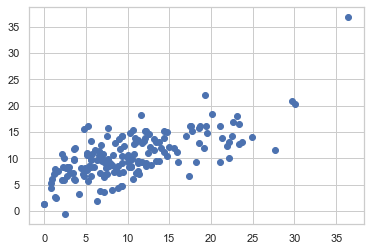

In [102]:
plt.scatter(y.values,predictions)

In [103]:
from sklearn.metrics import r2_score

In [104]:
r2_score(y.values, predictions)

0.4769323650910834

In [105]:
actual = pd.Series(y.values)
predicted = pd.Series(predictions.reshape(173))

In [106]:
result = pd.concat([actual,predicted],axis=1)

In [107]:
result.columns=['actual','predicted']

In [108]:
result

actual  predicted
0    11.744232  12.879881
1    21.279614  13.807800
2     5.103901  10.923683
3     8.107506   8.657767
4     7.490426   6.951054
..         ...        ...
168   2.128543  10.868840
169   6.343165   1.899067
170  10.344203   8.356397
171  17.367010   6.569613
172  36.468521  36.881836

[173 rows x 2 columns]

In [109]:
def corrfit2(data, X, Y, xlabel=None, ylabel=None, log=(False, False), xlim=None, ylim=None, size=None,name=None):
    df = data.loc[:,[X,Y]]

    if log[0]:
        U = f"log({X})"
        xlabel = f"log: {xlabel}"
        df[U] = df[X].map(np.log)
    else:
        U = X

    if log[1]:
        V = f"log({Y})"
        ylabel = f"log: {ylabel}"
        df[V] = df[Y].map(np.log)
    else:
        V = Y

    r = stats.linregress(df[U], df[V])
    df['fit'] = (r.intercept + r.slope*df[U])
    df['residuals'] = df[V]  - df.fit
    df['scaled_residuals'] = df.residuals/df.fit

    dfBULK = df[df.scaled_residuals.abs() <= 2*df.scaled_residuals.std()]
    dfOUT = df[df.scaled_residuals.abs() > 2*df.scaled_residuals.std()]

    if xlim is None:
        xmin = df[U].min()
        xmax = df[U].max()
        xwidth = xmax - xmin
        xmax = xmax + 0.05*xwidth
        xmin = xmin - 0.05*xwidth
        xlim = (xmin,xmax)

    if ylim is None:
        ymin = df[V].min()
        ymax = df[V].max()
        ywidth = ymax - ymin
        ymax = ymax + 0.05*ywidth
        ymin = ymin - 0.05*ywidth
        ylim = (ymin,ymax)

    #print(size, data.columns)
    if size is not None:
        if size not in df.columns:
            if size not in data.columns:
                size = None
            else:
                df[size] = data[size]
    #print('Size:', size, df[size].min(), df[size].max())
        
    df['Outlier'] = df.scaled_residuals.abs() > 2*df.scaled_residuals.std()

    g0 = sns.jointplot(U, V, data=dfBULK,
                      kind="reg", 
                      marker="o",
                      xlim=xlim, ylim=ylim,
                      scatter=False,
                      height=7)    
    g1 = sns.scatterplot(U, V, data=df, hue="Outlier",
                         size=size, sizes=(25,200),
                         alpha=0.75, 
                         marker="o", edgecolor="k",
                         ax=g0.ax_joint)
    #g2 = sns.scatterplot(U, V, data=dfOUT, size="dPOP",
    #                    color="orange", marker="o", edgecolor="k",
    #                    ax=g0.ax_joint)

    if xlabel is not None:
        plt.xlabel(xlabel)

    if ylabel is not None:
        plt.ylabel(ylabel)

    r, p = stats.pearsonr(dfBULK[U],dfBULK[V])
    p_str = f'= {p:.5f}' if p >= 1E-5 else "< 0.00001"
    plt.title(f"$r^2 = {r**2:.5f}$, $p {p_str}$", pad=-5, fontsize = 12)
    plt.savefig(name)
    plt.show()
    
    return stats.linregress(dfBULK[U], dfBULK[V])

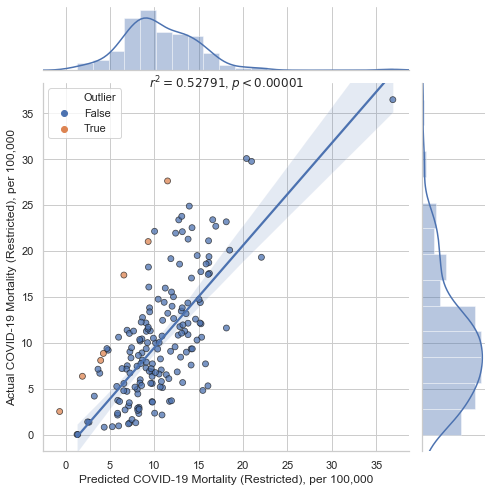

LinregressResult(slope=1.1140108439665821, intercept=-1.679429793067433, rvalue=0.726576594365073, pvalue=1.5850081858610476e-28, stderr=0.082261544546414)

In [110]:
corrfit2(result, X="predicted", Y="actual",
        xlabel="Predicted COVID-19 Mortality (Restricted), per 100,000",
        ylabel="Actual COVID-19 Mortality (Restricted), per 100,000",name = 'RegularizedNN1(6pca_Sigmoid0_40K).jpg')

In [66]:
loss = pd.DataFrame(model.history.history)

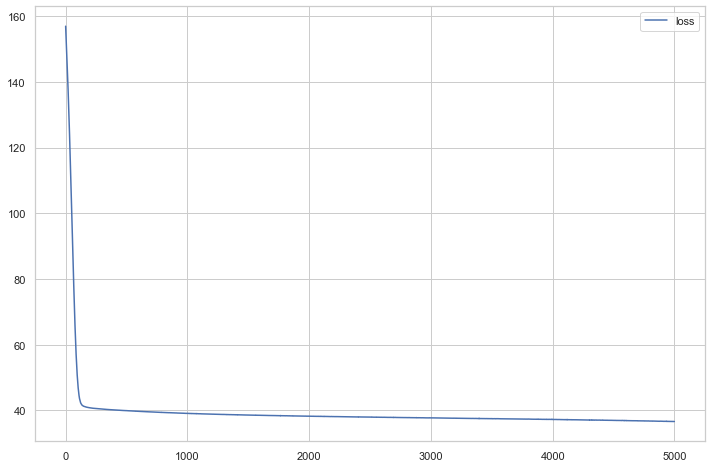

In [111]:
loss.plot(figsize=(12,8))
plt.savefig('RegularizedNN1(Restricted)_6pca_loss_40K.jpg')

In [112]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [113]:
regressor = LinearRegression()  
regressor.fit(X_train, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [114]:
y_pred = regressor.predict(X)

In [115]:
pred_plot = pd.DataFrame({'Actual': y, 'Predicted': y_pred})
pred_plot

Actual  Predicted
code                           
E06000001  11.744232  12.713937
E06000002  21.279614   8.425024
E06000003   5.103901  12.035114
E06000004   8.107506   9.318158
E06000005   7.490426   9.364251
...              ...        ...
W06000020   2.128543   9.506593
W06000021   6.343165   4.687592
W06000022  10.344203   9.808712
W06000023  17.367010   2.683470
W06000024  36.468521  12.761492

[173 rows x 2 columns]

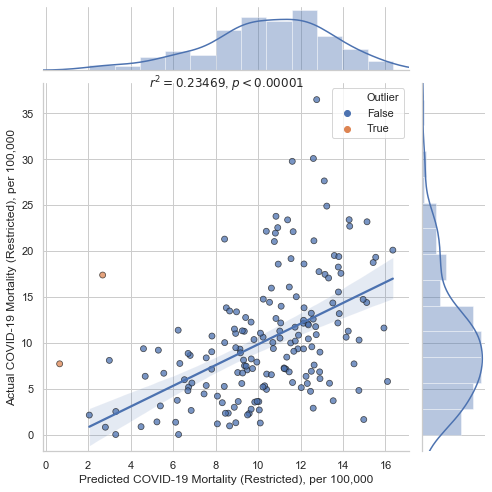

LinregressResult(slope=1.1284268905408803, intercept=-1.4708638893792436, rvalue=0.4844430927550299, pvalue=1.899681682653702e-11, stderr=0.15674994171577106)

In [116]:
corrfit2(pred_plot, X="Predicted", Y="Actual",
        xlabel="Predicted COVID-19 Mortality (Restricted), per 100,000",
        ylabel="Actual COVID-19 Mortality (Restricted), per 100,000",name = 'Linear_Regression_6PCA.jpg')

In [117]:
import statsmodels.api as sm

mod = sm.OLS(y,X_train)

fii = mod.fit()
print(fii.summary())
p_values = fii.summary2().tables[1]['P>|t|']

                                 OLS Regression Results                                
Dep. Variable:           d_restricted   R-squared (uncentered):                   0.060
Model:                            OLS   Adj. R-squared (uncentered):              0.026
Method:                 Least Squares   F-statistic:                              1.776
Date:                Mon, 01 Jun 2020   Prob (F-statistic):                       0.107
Time:                        22:18:49   Log-Likelihood:                         -674.95
No. Observations:                 173   AIC:                                      1362.
Df Residuals:                     167   BIC:                                      1381.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [98]:
regressor.coef_

array([0.70174428, 1.27908228, 1.90305644, 7.40854291, 7.04253457,
       3.81345381])

In [99]:
r, p = stats.pearsonr(X_train[:,6],y)

IndexError: index 6 is out of bounds for axis 1 with size 6

In [ ]:
r